In [2479]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Introduction

Data can be transformed into knowledge and then enhanced intelligence. We use the titanic datasets to explore first its features. The Titanic datasets contains the records of the Titanic passengers during its maiden voyage and tragic demise.  

We apply some data engineering techniques to prepare the data for some various machine learning techniques - including _registic regression, decision trees, random forrests, KNN and artificial neural network_ - for the purpose of predicting survivors. 

We also analyse and compare the predictions from all the classifier methods to explore further how the data and our data preparation may have affected the model fitting as well as the prediction on unseen data.


The notebook is structured in this manner:


- __[Upload libraires](#Libraries)__
- __[Data engineering](#Data-engineering)__
- __[Survival characteristics](#Survival-characteristics)__
- __[Data preparation for classification](#Data-preparation-for-classification)__ 
- __[Method: Logistic regression](#Method-:-Logistic-regression)__
- __[Method: K-Nearest neighorn](#Method:-K-Nearest-neighbourn)__
- __[Method: Decision Trees](#Method-:-Decision-Trees)__   
- __[Method: Random Forrest](#Method:-Random-Forrest)__
- __[Method: Neural AI](#Method:-Neural-AI)__ 






# Libraries

We upload all the libraries required for all the operations of this notebook.

In [2480]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import os
import random as rand
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix

import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__)



Tensorflow version:  2.6.4


# Data engineering

We explore the files in the folder, sets the paths and file names. These variables will be used in each section.

In [2481]:
!ls ../input/titanic/


gender_submission.csv  test.csv  train.csv


In [2482]:
train_data_path = '../input/titanic/train.csv'
test_data_path = '../input/titanic/test.csv'

## Import and explore the data 
Explore and import the training and test dataset provided by the competition.

### Training dataset

In [2483]:
titanic_train = pd.read_csv(train_data_path)
titanic_train.dtypes



PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [2484]:
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [2485]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Test dataset

In [2486]:
titanic_test = pd.read_csv(test_data_path)
titanic_test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [2487]:
titanic_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [2488]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


 ## Meta data 
 
| Column name | Description|
|---|---|
|Passenger_id| unique row indentifier |
|PClass | Categorical data (1 = 1st; 2 = 2nd; 3 = 3rd)|
| Survival | Categoricial data (0 = No; 1 = Yes) |
| Name | Characters  - Name of passenger  |
| Sex  | Categorical data male or female |
| Age  | integer values representing age |
| SigSp | integer Number of Siblings/Spouses Aboard |
| Parch | Number of Parents/Children Aboard |
| Ticket | Ticket number |
| Fare | Fare in GBP at time of travel|
| Cabin | Cabin |
| Embark | Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)|


Source - http://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf (7/12/2022)

# Survival characteristics
We explore the survival characteristics using several combinations of columns. We hope to understand better some features that may guide the predictions of survivors.



## Passenger and survival
The training dataset suggests a minority of passengers survived (i.e., 38% approximately), 62% of passengers perished. Some further decomposition suggests first class passengers may have been more likely to survive than lower classes. The percentages of surviving decreases sharply.

In [2489]:
titanic_train.groupby(["Survived"]).count()["PassengerId"]/titanic_train.shape[0]                                       

Survived
0    0.616162
1    0.383838
Name: PassengerId, dtype: float64

In [2490]:
temp =  titanic_train.groupby(["Pclass","Survived"]).count()["PassengerId"]
temp = temp.groupby(level=0).apply(lambda x:  x / float(x.sum()))     
temp.unstack()

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


## Embarkment and survival
The port of embarkment appears to have less influence on the survival percentages. It appears most passengers embarked at Southampton (72% approximately), 18% of passengers at Cherbourg, and the remaining from Queenstown. Half of the Cherbourg passengers booked first class tickets. Other embarkment ports appears to be much lower. Half of the passengers from Southampton booked third class tickets. We could surmise the latter may have contributed to the lowest percentages of surviving the accident.

In [2491]:
titanic_train.groupby(["Embarked"]).count()["PassengerId"]/titanic_train.shape[0]        

Embarked
C    0.188552
Q    0.086420
S    0.722783
Name: PassengerId, dtype: float64

In [2492]:
temp =  titanic_train.groupby(["Embarked","Pclass"]).count()["PassengerId"]
temp = temp.groupby(level=0).apply(lambda x:  x / float(x.sum()))     
temp.unstack()                                                 

Pclass,1,2,3
Embarked,,,
C,0.505952,0.101190,0.392857
Q,0.025974,0.038961,0.935065
S,0.197205,0.254658,0.548137


In [2493]:
temp =  titanic_train.groupby(["Embarked","Survived"]).count()["PassengerId"]
temp = temp.groupby(level=0).apply(lambda x:  x / float(x.sum()))     
temp.unstack()                                                          

Survived,0,1
Embarked,,
C,0.446429,0.553571
Q,0.610390,0.389610
S,0.663043,0.336957


In [2494]:
temp =  titanic_train.groupby(["Embarked","Pclass","Survived"]).count()["PassengerId"]
temp = temp.groupby(level=0).apply(lambda x:  x / float(x.sum()))     
temp.unstack()                                                        

Survived                0         1
Embarked Pclass                    
C        1       0.154762  0.351190
         2       0.047619  0.053571
         3       0.244048  0.148810
Q        1       0.012987  0.012987
         2       0.012987  0.025974
         3       0.584416  0.350649
S        1       0.082298  0.114907
         2       0.136646  0.118012
         3       0.444099  0.104037

## Gender and survival 
The training dataset suggests that nearly two thirds of passengers were male, and a third were female. Women and girls appears to have a higher survival percentagers -  three quarters of female passengers survived the accident, but only 19% of male survived.

In [2495]:
titanic_train.groupby(["Sex"]).count()["PassengerId"]/titanic_train.shape[0] 

Sex
female    0.352413
male      0.647587
Name: PassengerId, dtype: float64

In [2496]:
temp =  titanic_train.groupby(["Sex","Survived"]).count()["PassengerId"]
temp = temp.groupby(level=0).apply(lambda x:  x / float(x.sum()))     
temp.unstack()                                                                                                              

Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908


In [2497]:
temp =  titanic_train.groupby(["Sex","Pclass","Survived"]).count()["PassengerId"]
temp = temp.groupby(level=1).apply(lambda x:  x / float(x.sum()))     
temp.unstack()                                                           

Survived              0         1
Sex    Pclass                    
female 1       0.013889  0.421296
       2       0.032609  0.380435
       3       0.146640  0.146640
male   1       0.356481  0.208333
       2       0.494565  0.092391
       3       0.610998  0.095723

## Age, siblings and parents

The age distribution appears to be multi-modal with some two peaks at around 0 and 25. Both training and testing datasets have a similar mean and standard deviation. However, some skewness may affect a normal distributions and any normalisation processes of the data.

The survivors and other passengers age appears to be of similar age at the point of centrality. We will need to complete some statistical tests to accept or reject the null hypothesis that the age distribution of survivors and non-survivors are the same. We surmise the values may have be unknown, without any data preparation the tests cannot be completed.

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

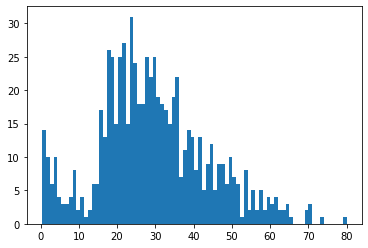

In [2498]:
plt.hist(titanic_train.Age, bins = 80)
titanic_train.Age.describe()

count    332.000000
mean      30.272590
std       14.181209
min        0.170000
25%       21.000000
50%       27.000000
75%       39.000000
max       76.000000
Name: Age, dtype: float64

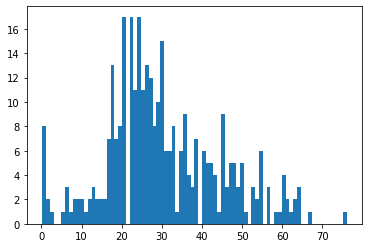

In [2499]:
plt.hist(titanic_test.Age, bins = 80)
titanic_test.Age.describe()

<AxesSubplot:xlabel='Survived', ylabel='Age'>

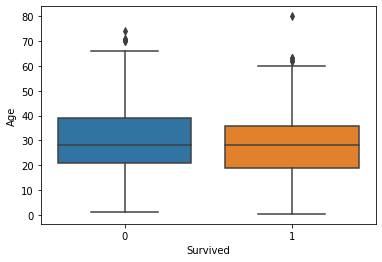

In [2500]:
sns.boxplot(x="Survived", y="Age", data=titanic_train)


The majority of passengers may be travelling on their own without a spouse, sibling, children of parents on board. However, passengers with 1 or 2 siblings/spouse appears to have survived; the percentages is in the range of 46% to 54%. Parents or individuals with one, two or three parents were less likely to perished - the percentages ranges between 50% and 60%.

In [2501]:
titanic_train.groupby(["SibSp"]).count()["PassengerId"]/titanic_train.shape[0]


SibSp
0    0.682379
1    0.234568
2    0.031425
3    0.017957
4    0.020202
5    0.005612
8    0.007856
Name: PassengerId, dtype: float64

In [2502]:
temp =  titanic_train.groupby(["SibSp","Survived"]).count()["PassengerId"]
temp = temp.groupby(level=0).apply(lambda x:  x / float(x.sum()))    
temp.unstack()

Survived,0,1
SibSp,,
0,0.654605,0.345395
1,0.464115,0.535885
2,0.535714,0.464286
3,0.750000,0.250000
4,0.833333,0.166667
5,1.000000,NaN
8,1.000000,NaN


count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64

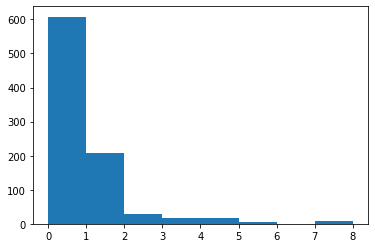

In [2503]:
plt.hist(titanic_train.SibSp, bins = 8)
titanic_train.SibSp.describe()

In [2504]:
titanic_train.groupby(["Parch"]).count()["PassengerId"]/titanic_train.shape[0]


Parch
0    0.760943
1    0.132435
2    0.089787
3    0.005612
4    0.004489
5    0.005612
6    0.001122
Name: PassengerId, dtype: float64

In [2505]:
temp =  titanic_train.groupby(["Parch","Survived"]).count()["PassengerId"]
temp = temp.groupby(level=0).apply(lambda x:  x / float(x.sum()))    
temp.unstack()

Survived,0,1
Parch,,
0,0.656342,0.343658
1,0.449153,0.550847
2,0.500000,0.500000
3,0.400000,0.600000
4,1.000000,NaN
5,0.800000,0.200000
6,1.000000,NaN


count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64

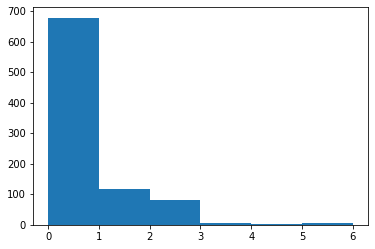

In [2506]:
plt.hist(titanic_train.Parch, bins = 6)
titanic_train.Parch.describe()

We decided to add both fields _Parch_ and _SibSp_ together as a familly. The mean and median age appears to be quite close between the passengers who have survived and perished. For smaller families the spread appears to be smaller than for larger families.  

The highest percentages of surviving the accident suggests that passengers in first and second class with no other familly members. These percentages are loweer than 30%.

In [2507]:
titanic_train["fam_members"] = titanic_train.SibSp + titanic_train.Parch
temp =  titanic_train.groupby(["fam_members","Survived"]).agg([np.median, np.mean, np.std])["Age"]
temp.unstack()

median             mean                   std           
Survived         0     1          0          1          0          1
fam_members                                                         
0             29.0  30.0  32.414234  31.811538  13.334968  11.970452
1             30.0  29.0  32.126984  30.781842  11.599836  14.916443
2             30.5  22.0  31.500000  21.911887  13.776141  17.363697
3             25.0  14.0  22.833333  16.972381  11.196726  15.054360
4             12.5  21.0  17.000000  31.000000  15.528775  19.974984
5              9.0  24.0  17.578947  23.666667  18.637822   0.577350
6              9.0  11.0  14.875000  15.750000  15.169871  16.070159
7             12.5   NaN  15.666667        NaN  14.361987        NaN
10             NaN   NaN        NaN        NaN        NaN        NaN

count    891.000000
mean       0.904602
std        1.613459
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       10.000000
Name: fam_members, dtype: float64

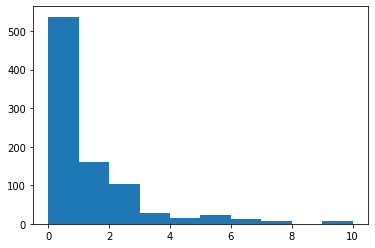

In [2508]:
plt.hist(titanic_train.fam_members, bins = 10)
titanic_train.fam_members.describe()

In [2509]:
temp =  titanic_train.groupby(["fam_members","Pclass","Survived"]).count()["PassengerId"]
temp = temp.groupby(level=1).apply(lambda x:  x / float(x.sum()))      
temp.unstack()                                                    

Survived                   0         1
fam_members Pclass                    
0           1       0.236111  0.268519
            2       0.369565  0.195652
            3       0.519348  0.140530
1           1       0.087963  0.236111
            2       0.086957  0.097826
            3       0.075356  0.040733
2           1       0.027778  0.083333
            2       0.054348  0.114130
            3       0.054990  0.040733
3           1       0.009259  0.023148
            2       0.016304  0.054348
            3       0.006110  0.012220
4           1            NaN  0.009259
            2            NaN  0.005435
            3       0.024440       NaN
5           1       0.009259  0.009259
            2            NaN  0.005435
            3       0.034623       NaN
6           3       0.016293  0.008147
7           3       0.012220       NaN
10          3       0.014257       NaN

## Futher analysis and discussions
The data in their current states suggests that the distribution for the field _Survived_ is likely to be binomial. It has a lowest occurrences of surviving, which is a shocking statistic.

The passenger class has more occurrences of third classes. However, First and second class female passengers were more likely to survive the accident. First class male passengers had the also the highest survival rate. The Age is skewed to the left; some age may be unknown. It appears (see below) the younger passengers may have been traveling with other members of a family and perhaps reduced their survival rates; the largest familly appears to be travelling in third class. Most occurrences were families made of 0, 1, or 3 family members. 

This analysis suggests that perhaps the passenger class familly, and the gender may have contributed to a higher survival rate. However, the familly size may have contributed to survived too. The classifiers will need to identify other patterns that may have contributed to survive the accident. It is likely to be quite challenging as no linear relationships or grouping may be present in the data.



In [2510]:
temp =  titanic_train.groupby(["Pclass","fam_members","Sex","Survived"]).count()["PassengerId"]
temp = temp.groupby(level=3).apply(lambda x:  x / float(x.sum()))      
temp.unstack()       

Survived                          0         1
Pclass fam_members Sex                       
1      0           female  0.001821  0.096491
                   male    0.091075  0.073099
       1           female       NaN  0.114035
                   male    0.034608  0.035088
       2           female       NaN  0.038012
                   male    0.010929  0.014620
       3           female  0.003643  0.005848
                   male         NaN  0.008772
       4           female       NaN  0.005848
       5           female       NaN  0.005848
                   male    0.003643       NaN
2      0           female  0.005464  0.084795
                   male    0.118397  0.020468
       1           female  0.003643  0.049708
                   male    0.025501  0.002924
       2           female  0.001821  0.038012
                   male    0.016393  0.023392
       3           female       NaN  0.026316
                   male    0.005464  0.002924
       4           female       NaN  0.002924
       5           female       NaN  0.002924
3      0           female  0.041894  0.108187
                   male    0.422587  0.093567
       1           female  0.025501  0.043860
                   male    0.041894  0.014620
       2           female  0.018215  0.035088
                   male    0.030965  0.023392
       3           female  0.001821  0.014620
                   male    0.003643  0.002924
       4           female  0.016393       NaN
                   male    0.005464       NaN
       5           female  0.009107       NaN
                   male    0.021858       NaN
       6           female  0.009107  0.008772
                   male    0.005464  0.002924
       7           female  0.003643       NaN
                   male    0.007286       NaN
       10          female  0.005464       NaN
                   male    0.007286       NaN

array([[<AxesSubplot:xlabel='Survived', ylabel='Survived'>,
        <AxesSubplot:xlabel='Pclass', ylabel='Survived'>,
        <AxesSubplot:xlabel='Age', ylabel='Survived'>,
        <AxesSubplot:xlabel='fam_members', ylabel='Survived'>],
       [<AxesSubplot:xlabel='Survived', ylabel='Pclass'>,
        <AxesSubplot:xlabel='Pclass', ylabel='Pclass'>,
        <AxesSubplot:xlabel='Age', ylabel='Pclass'>,
        <AxesSubplot:xlabel='fam_members', ylabel='Pclass'>],
       [<AxesSubplot:xlabel='Survived', ylabel='Age'>,
        <AxesSubplot:xlabel='Pclass', ylabel='Age'>,
        <AxesSubplot:xlabel='Age', ylabel='Age'>,
        <AxesSubplot:xlabel='fam_members', ylabel='Age'>],
       [<AxesSubplot:xlabel='Survived', ylabel='fam_members'>,
        <AxesSubplot:xlabel='Pclass', ylabel='fam_members'>,
        <AxesSubplot:xlabel='Age', ylabel='fam_members'>,
        <AxesSubplot:xlabel='fam_members', ylabel='fam_members'>]],
      dtype=object)

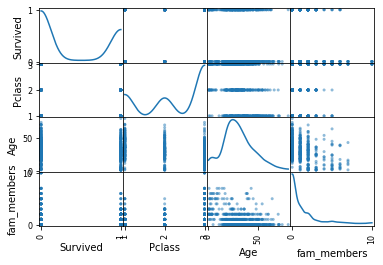

In [2511]:
columns = ["Survived","Pclass","Age", "fam_members"]
titanic_train = titanic_train[columns]
pd.plotting.scatter_matrix(titanic_train, diagonal='kde')

The percentages suggests passenger class and gender may be the factor that may lead to survival. 

# Data preparation for classification
This section prepares the data for classifiers. We transform the data in suitable data types supported by the classifiers, remove null values and imputes some values when required. Some columns are deleted; they may be either character or we surmise not suitable for classification.

## Integer to float
We upload the data for a cleaning and display the columns with their data types to float on both datasets.

In [2512]:
titanic_train = pd.read_csv(train_data_path)
titanic_train.dtypes



PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [2513]:
titanic_test = pd.read_csv(test_data_path)
titanic_test.dtypes



PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [2514]:
titanic_train["PassengerId"] = titanic_train["PassengerId"].astype(float)
titanic_train["SibSp"] = titanic_train["SibSp"].astype(float)
titanic_train["Parch"] = titanic_train["Parch"].astype(float)
titanic_train["Survived"] = titanic_train["Survived"].astype(float)
titanic_train["Pclass"] = titanic_train["Pclass"].astype(float)
titanic_train.dtypes

PassengerId    float64
Survived       float64
Pclass         float64
Name            object
Sex             object
Age            float64
SibSp          float64
Parch          float64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [2515]:
titanic_test["PassengerId"] = titanic_test["PassengerId"].astype(float)
titanic_test["SibSp"] = titanic_test["SibSp"].astype(float)
titanic_test["Parch"] = titanic_test["Parch"].astype(float)
titanic_test["Pclass"] = titanic_test["Pclass"].astype(float)
titanic_test.dtypes

PassengerId    float64
Pclass         float64
Name            object
Sex             object
Age            float64
SibSp          float64
Parch          float64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Null values 

We remove all the nulls values from some of the columns; i.e., PassengerId, Fare, SibSp, Parch, and Embarked. Some fares were unknown, but all passengers ID was set to a unique number. 

In [2516]:
titanic_train.PassengerId.isnull().sum()


0

In [2517]:
titanic_test.PassengerId.isnull().sum()


0

In [2518]:
titanic_train.Fare.isnull().sum()


0

In [2519]:
titanic_test.Fare.isnull().sum()

1

In [2520]:
titanic_train.Parch.isnull().sum()

0

In [2521]:
titanic_test.SibSp.isnull().sum()

0

In [2522]:
titanic_train.SibSp.isnull().sum()

0

In [2523]:
titanic_test.loc[titanic_test["Fare"].isnull(),"Fare"] = -1.0
titanic_test.Fare.isnull().sum()

0

Quite a few passengers' age is unknown. We will try to input a value based using the sibling/spouse and parents/children statistical values to infer some replacement values. 

We discover that the median age for parents, single, children, and couples. We rely on age and perception at the time the Titanic sunk. We input the median age for the age that is unknown. We hope to reduce the noise with more meaningful inputations. 

__Conditions applied:__

|Category| Age condition | Sibling/spouse | Parents/children|
|---|---|---|---|
|Parents| >= 14| >= 0 | > 0| 
|Children | < 14 | none | > 0|
|Singles| >= 14| == 0 | == 0|
|Couples| >= 14 | == 1 | == 0|

In [2524]:
titanic_train.Age.isnull().sum()

177

In [2525]:
filter_rows    = (titanic_train["Age"] >= 14.0) & (titanic_train["Parch"] >= 0.0) & (titanic_train["SibSp"] >= 0.0)
median_parents  = titanic_train.loc[filter_rows, "Age"].median()
mean_parents    = titanic_train.loc[filter_rows, "Age"].mean()
print("median age ", median_parents, " mean age ", mean_parents)


median age  30.0  mean age  32.426127527216174


In [2526]:
filter_rows    = (titanic_train["Age"].isnull()) & (titanic_train["Parch"] >= 0.0) & (titanic_train["SibSp"] >= 0.0)
titanic_train.loc[filter_rows, "Age"] = median_parents
titanic_train.loc[filter_rows, "Age"]


5      30.0
17     30.0
19     30.0
26     30.0
28     30.0
       ... 
859    30.0
863    30.0
868    30.0
878    30.0
888    30.0
Name: Age, Length: 177, dtype: float64

In [2527]:
filter_rows    = (titanic_train["Age"] < 14 ) & (titanic_train["Parch"] > 0.0) & ((titanic_train["Name"].str.contains("Master")) | (titanic_train["Name"].str.contains("Miss")))
                                                    
median_children  = titanic_train.loc[filter_rows, "Age"].median()
mean_children   = titanic_train.loc[filter_rows, "Age"].mean()
print("median age ", median_children, " mean age ", mean_children)


median age  4.0  mean age  4.689104477611941


In [2528]:
filter_rows    = (titanic_train["Age"].isnull()) & (titanic_train["Parch"] > 0.0) & ((titanic_train["Name"].str.contains("Master")) | (titanic_train["Name"].str.contains("Miss")))
titanic_train.loc[filter_rows, "Age"] = median_children
titanic_train.loc[filter_rows, "Age"]


Series([], Name: Age, dtype: float64)

In [2529]:
filter_rows    = (titanic_train["Age"] >= 14) & (titanic_train["Parch"] < 1.0) & (titanic_train["SibSp"] < 1.0)
median_single  = titanic_train.loc[filter_rows, "Age"].median()
mean_single    = titanic_train.loc[filter_rows, "Age"].mean()
print("median age ", median_single, " mean age ", mean_single)



median age  30.0  mean age  31.794007490636705


In [2530]:
filter_rows    = (titanic_train["Age"].isnull()) & (titanic_train["Parch"] < 1.0) & (titanic_train["SibSp"] < 1.0)
titanic_train.loc[filter_rows, "Age"] = median_single
titanic_train.loc[filter_rows, "Age"]


Series([], Name: Age, dtype: float64)

In [2531]:
filter_rows    = (titanic_train["Age"] >= 14) & (titanic_train["SibSp"] == 1.0) & (titanic_train["Parch"] == 0.0)

median_couple  = titanic_train.loc[filter_rows, "Age"].median()
mean_couple    = titanic_train.loc[filter_rows, "Age"].mean()
print("median age ", median_couple, " mean age ", mean_couple)


median age  30.0  mean age  31.87704918032787


In [2532]:
filter_rows    = (titanic_train["Age"].isnull()) & (titanic_train["SibSp"] == 1.0) & (titanic_train["Parch"] == 0.0)
titanic_train.loc[filter_rows, "Age"] = median_couple
titanic_train.loc[filter_rows, "Age"]


Series([], Name: Age, dtype: float64)

In [2533]:
titanic_train.Age.isnull().sum()

0

The testing dataset has all ages known.

In [2534]:
titanic_test.Age.isnull().sum()

86

In [2535]:
filter_rows    = (titanic_test["Age"] >= 14.0) & (titanic_test["Parch"] >= 0.0) & (titanic_test["SibSp"] >= 0.0)
median_parents  = titanic_test.loc[filter_rows, "Age"].median()
mean_parents    = titanic_test.loc[filter_rows, "Age"].mean()
print("median age ", median_parents, " mean age ", mean_parents)


median age  29.0  mean age  32.49671052631579


In [2536]:
filter_rows    = (titanic_test["Age"].isnull()) & (titanic_test["Parch"] >= 0.0) & (titanic_test["SibSp"] >= 0.0)
titanic_test.loc[filter_rows, "Age"] = median_parents
titanic_test.loc[filter_rows, "Age"]


10     29.0
22     29.0
29     29.0
33     29.0
36     29.0
       ... 
408    29.0
410    29.0
413    29.0
416    29.0
417    29.0
Name: Age, Length: 86, dtype: float64

In [2537]:
filter_rows    = (titanic_train["Age"] < 14 ) & (titanic_train["Parch"] > 0.0) & ((titanic_train["Name"].str.contains("Master")) | (titanic_train["Name"].str.contains("Miss")))
                                                    
median_children  = titanic_train.loc[filter_rows, "Age"].median()
mean_children   = titanic_train.loc[filter_rows, "Age"].mean()
print("median age ", median_children, " mean age ", mean_children)


median age  4.0  mean age  4.689104477611941


In [2538]:
filter_rows    = (titanic_test["Age"] < 14 ) & (titanic_test["Parch"] > 0.0) & ((titanic_test["Name"].str.contains("Master")) | (titanic_test["Name"].str.contains("Miss")))
                                                    
median_children  = titanic_test.loc[filter_rows, "Age"].median()
mean_children   = titanic_test.loc[filter_rows, "Age"].mean()
print("median age ", median_children, " mean age ", mean_children)


median age  6.0  mean age  5.907407407407407


In [2539]:
filter_rows    = (titanic_test["Age"].isnull()) & (titanic_test["Parch"] > 0.0) & ((titanic_test["Name"].str.contains("Master")) | (titanic_test["Name"].str.contains("Miss")))
titanic_test.loc[filter_rows, "Age"] = median_children
titanic_test.loc[filter_rows, "Age"]


Series([], Name: Age, dtype: float64)

In [2540]:
filter_rows    = (titanic_test["Age"] >= 14) & (titanic_test["Parch"] < 1.0) & (titanic_test["SibSp"] < 1.0)
median_single  = titanic_test.loc[filter_rows, "Age"].median()
mean_single    = titanic_test.loc[filter_rows, "Age"].mean()
print("median age ", median_single, " mean age ", mean_single)



median age  29.0  mean age  29.785714285714285


In [2541]:
filter_rows    = (titanic_test["Age"].isnull()) & (titanic_test["Parch"] < 1.0) & (titanic_test["SibSp"] < 1.0)
titanic_test.loc[filter_rows, "Age"] = median_single
titanic_test.loc[filter_rows, "Age"]


Series([], Name: Age, dtype: float64)

In [2542]:
filter_rows    = (titanic_test["Age"] >= 14) & (titanic_test["SibSp"] == 1.0) & (titanic_test["Parch"] == 0.0)

median_couple  = titanic_test.loc[filter_rows, "Age"].median()
mean_couple    = titanic_test.loc[filter_rows, "Age"].mean()
print("median age ", median_couple, " mean age ", mean_couple)


median age  30.0  mean age  36.075


In [2543]:
filter_rows    = (titanic_test["Age"].isnull()) & (titanic_test["SibSp"] == 1.0) & (titanic_test["Parch"] == 0.0)
titanic_test.loc[filter_rows, "Age"] = median_couple
titanic_test.loc[filter_rows, "Age"]


Series([], Name: Age, dtype: float64)

In [2544]:
titanic_test.Age.isnull().sum()

0

## Embarkment 
We remove any NAs from the embarked column. We replace NaNs values with unknown. However, only the training datasets has some unknown values. It could lower accuracy on the prediction on the  testing dataset.

In [2545]:
print("Training : " , titanic_train.Embarked.unique())
print("Testing  : " , titanic_test.Embarked.unique())

Training :  ['S' 'C' 'Q' nan]
Testing  :  ['Q' 'S' 'C']


In [2546]:
titanic_train.loc[titanic_train['Embarked'].isna(),'Embarked'] = 'U'

In [2547]:
titanic_test.loc[titanic_test['Embarked'].isna(),'Embarked'] = 'U'


In [2548]:
print("Training : " , titanic_train.Embarked.unique())
print("Testing  : " , titanic_test.Embarked.unique())

Training :  ['S' 'C' 'Q' 'U']
Testing  :  ['Q' 'S' 'C']


In [2549]:
print("Training : " , titanic_train.Sex.unique())
print("Testing  : " , titanic_test.Sex.unique())

Training :  ['male' 'female']
Testing  :  ['male' 'female']


## Passenger class
No unknown values is present in both datasets.

In [2550]:
print("Training : " , titanic_train.Pclass.unique())
print("Testing  : " , titanic_test.Pclass.unique())

Training :  [3. 1. 2.]
Testing  :  [3. 2. 1.]


## PClass and Fare

The Fare decreases as the passenger class decrease. However the range is can be quite large and the data data imbalanced; there are a lot more third class tickets than other classes.  So we scale robustly the data based on non-parametric statistics.

In [2551]:
temp =  titanic_train.groupby(["Pclass","Fare"]).count()["PassengerId"]
temp = temp.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))                               
temp.unstack()

Fare,0.0000,4.0125,5.0000,6.2375,6.4375,6.4500,6.4958,6.7500,6.8583,6.9500,...,153.4625,164.8667,211.3375,211.5000,221.7792,227.5250,247.5208,262.3750,263.0000,512.3292
Pclass,,,,,,,,,,,,,,,,,,,,,
1.0,2.314815,NaN,0.462963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.388889,0.925926,1.388889,0.462963,0.462963,1.851852,0.925926,0.925926,1.851852,1.388889
2.0,3.260870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,0.814664,0.203666,NaN,0.203666,0.203666,0.203666,0.407332,0.407332,0.203666,0.203666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

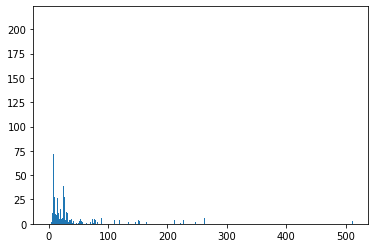

In [2552]:
plt.hist(titanic_train.Fare, bins=512)
titanic_train.Fare.describe()

<AxesSubplot:title={'center':'Fare'}, xlabel='Pclass'>

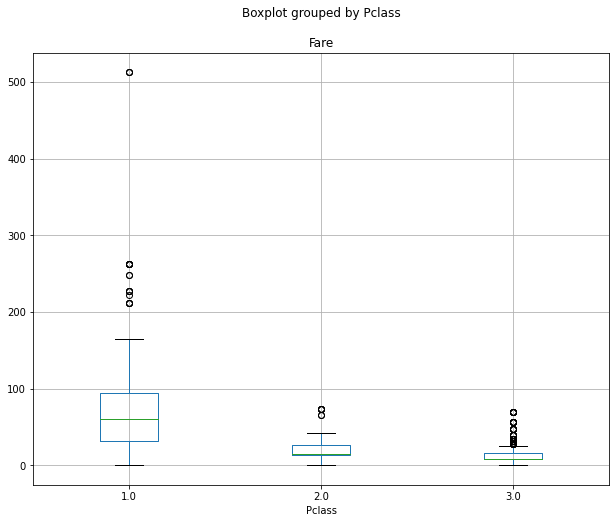

In [2553]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
titanic_train.boxplot(column=['Fare'], by='Pclass', ax=ax)

In [2554]:
titanic_train.groupby("Pclass").describe()["Fare"]

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1.0,216.0,84.154687,78.380373,0.0,30.92395,60.2875,93.5,512.3292
2.0,184.0,20.662183,13.417399,0.0,13.00000,14.2500,26.0,73.5000
3.0,491.0,13.675550,11.778142,0.0,7.75000,8.0500,15.5,69.5500


count    891.000000
mean       0.768745
std        2.152200
min       -0.626005
25%       -0.283409
50%        0.000000
75%        0.716591
max       21.562738
Name: Fare, dtype: float64

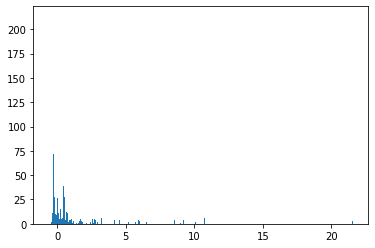

In [2555]:
median_fare = titanic_train.Fare.median()
IQR_fare = titanic_train.Fare.quantile(0.75) -  titanic_train.Fare.quantile(0.25)
titanic_train.loc[:,"Fare"] = (titanic_train.Fare - median_fare)/IQR_fare
plt.hist(titanic_train.Fare, bins = 512)
titanic_train.Fare.describe()


count    891.000000
mean       0.768745
std        2.152200
min       -0.626005
25%       -0.283409
50%        0.000000
75%        0.716591
max       21.562738
Name: Fare, dtype: float64

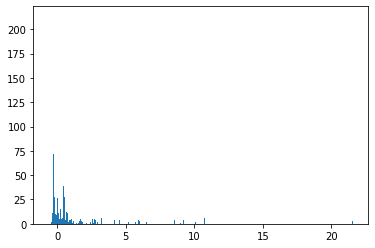

In [2556]:
plt.hist(titanic_train.Fare, bins = 512)
titanic_train.Fare.describe()

In [2557]:
titanic_train.dtypes

PassengerId    float64
Survived       float64
Pclass         float64
Name            object
Sex             object
Age            float64
SibSp          float64
Parch          float64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

We repeat the same process with the test dataset. The distribution is much different and therefore could lower the accuracy of the prediction.

In [2558]:
titanic_test.groupby("Pclass").describe()["Fare"]

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1.0,107.0,94.280297,84.435858,0.0000,30.10,60.0000,134.500000,512.3292
2.0,93.0,22.202104,13.991877,9.6875,13.00,15.7500,26.000000,73.5000
3.0,218.0,12.397936,10.817256,-1.0000,7.75,7.8958,14.327075,69.5500


count    418.000000
mean       0.894354
std        2.369743
min       -0.655504
25%       -0.278180
50%        0.000000
75%        0.721820
max       21.117807
Name: Fare, dtype: float64

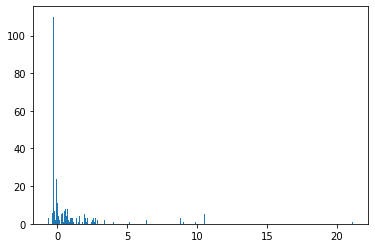

In [2559]:
median_fare = titanic_test.Fare.median()
IQR_fare = titanic_test.Fare.quantile(0.75) -  titanic_test.Fare.quantile(0.25)
titanic_test.loc[:,"Fare"] = (titanic_test.Fare - median_fare)/IQR_fare
plt.hist(titanic_test.Fare, bins = 512)
titanic_test.Fare.describe()


count    418.000000
mean       0.894354
std        2.369743
min       -0.655504
25%       -0.278180
50%        0.000000
75%        0.721820
max       21.117807
Name: Fare, dtype: float64

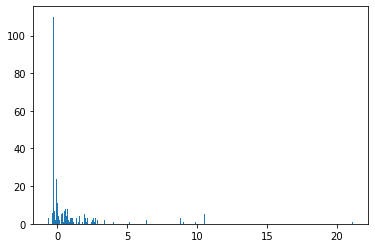

In [2560]:
plt.hist(titanic_test.Fare, bins = 512)
titanic_test.Fare.describe()

In [2561]:
titanic_test.dtypes

PassengerId    float64
Pclass         float64
Name            object
Sex             object
Age            float64
SibSp          float64
Parch          float64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Age
We normalise the age to bring more the data towards the median. The previous transformation have brought more data centrally.

count    891.000000
mean      29.758889
std       13.002570
min        0.420000
25%       22.000000
50%       30.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

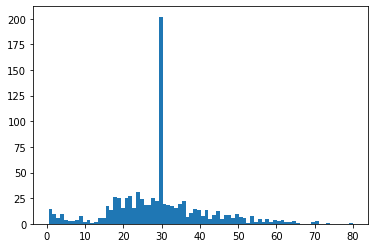

In [2562]:
plt.hist(titanic_train.Age, bins = 80)
titanic_train["Age"].describe()

In [2563]:
median_age = titanic_train.Age.median()
IQR_age = titanic_train.Age.quantile(0.75) - titanic_train.Age.quantile(0.25)
titanic_train.loc[:,"Age"] = (titanic_train.Age - median_age)/IQR_age
titanic_train.Age.describe()


count    891.000000
mean      -0.018547
std        1.000198
min       -2.275385
25%       -0.615385
50%        0.000000
75%        0.384615
max        3.846154
Name: Age, dtype: float64

count    891.000000
mean      -0.018547
std        1.000198
min       -2.275385
25%       -0.615385
50%        0.000000
75%        0.384615
max        3.846154
Name: Age, dtype: float64

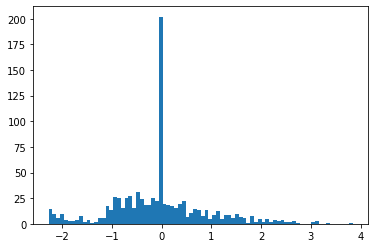

In [2564]:
plt.hist(titanic_train.Age, bins = 80)
titanic_train.Age.describe()

count    418.000000
mean      30.010766
std       12.645028
min        0.170000
25%       23.000000
50%       29.000000
75%       35.750000
max       76.000000
Name: Age, dtype: float64

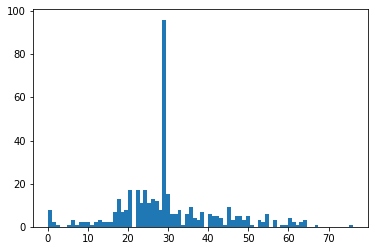

In [2565]:
plt.hist(titanic_test.Age, bins = 80)
titanic_test["Age"].describe()

In [2566]:
median_age = titanic_test.Age.median()
IQR_age = titanic_test.Age.quantile(0.75) - titanic_test.Age.quantile(0.25)
titanic_test.loc[:,"Age"] = (titanic_test.Age - median_age)/IQR_age
titanic_test.Age.describe()


count    418.000000
mean       0.079276
std        0.991767
min       -2.261176
25%       -0.470588
50%        0.000000
75%        0.529412
max        3.686275
Name: Age, dtype: float64

count    418.000000
mean       0.079276
std        0.991767
min       -2.261176
25%       -0.470588
50%        0.000000
75%        0.529412
max        3.686275
Name: Age, dtype: float64

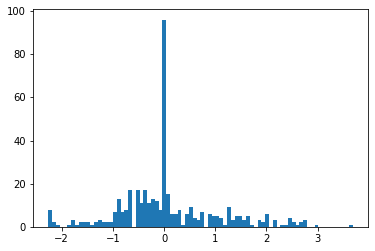

In [2567]:
plt.hist(titanic_test.Age, bins = 80)
titanic_test.Age.describe()

## Gender 
We replace the male with 1 and female with the value 2.

In [2568]:
print("Training : ", titanic_train['Sex'].unique())
print("Test     : ", titanic_train['Sex'].unique())



Training :  ['male' 'female']
Test     :  ['male' 'female']


In [2569]:
titanic_train["Sex"].replace({"male":1.0, "female":2.0}, inplace = True)
titanic_train["Sex"] = titanic_train["Sex"].astype(float)
titanic_train.groupby("Sex").count()["PassengerId"]

Sex
1.0    577
2.0    314
Name: PassengerId, dtype: int64

In [2570]:
titanic_test["Sex"].replace({"male":1.0, "female":2.0}, inplace = True)
titanic_test["Sex"] = titanic_test["Sex"].astype(float)
titanic_test.groupby("Sex").count()["PassengerId"]


Sex
1.0    266
2.0    152
Name: PassengerId, dtype: int64

## Sibling and parentage

We add both sibling, parents, and children into a family variables. 

In [2571]:
titanic_train["SibSp"].unique()


array([1., 0., 3., 4., 2., 5., 8.])

In [2572]:
titanic_train["Parch"].unique()

array([0., 1., 2., 5., 3., 4., 6.])

In [2573]:
titanic_train["fam_members"] = titanic_train["SibSp"] + titanic_train["Parch"]
titanic_train["fam_members"].describe()

count    891.000000
mean       0.904602
std        1.613459
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       10.000000
Name: fam_members, dtype: float64

In [2574]:
titanic_test["fam_members"] = titanic_test["SibSp"] + titanic_test["Parch"]
titanic_test["fam_members"].describe()

count    418.000000
mean       0.839713
std        1.519072
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       10.000000
Name: fam_members, dtype: float64

In [2575]:
titanic_test["fam_members"] = titanic_test["SibSp"] + titanic_test["Parch"]
titanic_test["fam_members"].describe()

count    418.000000
mean       0.839713
std        1.519072
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       10.000000
Name: fam_members, dtype: float64

In [2576]:
titanic_train.dtypes

PassengerId    float64
Survived       float64
Pclass         float64
Name            object
Sex            float64
Age            float64
SibSp          float64
Parch          float64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
fam_members    float64
dtype: object

In [2577]:
titanic_test.dtypes

PassengerId    float64
Pclass         float64
Name            object
Sex            float64
Age            float64
SibSp          float64
Parch          float64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
fam_members    float64
dtype: object

## Embarked 
We transform the port of embarkment as unknown for Nan Values and transform those values into numerical ones. 



In [2578]:
titanic_train.Embarked.unique()

array(['S', 'C', 'Q', 'U'], dtype=object)

In [2579]:
titanic_test.Embarked.unique()

array(['Q', 'S', 'C'], dtype=object)

In [2580]:
titanic_train.loc[titanic_train["Embarked"].isnull(), "Embarked"] = "U"
titanic_train.Embarked.unique()

array(['S', 'C', 'Q', 'U'], dtype=object)

In [2581]:
titanic_train["Embarked"].replace({"U":1.0, "S":2.0, "Q": 3.0, "C":4.0}, inplace = True)

In [2582]:
titanic_test["Embarked"].replace({"U":1.0, "S":2.0, "Q": 3.0, "C":4.0}, inplace = True)

## Columns to drop 
We drop some columns; they may have too many unknown values. Some of them may be dependent statistical variables. We assume the price of a ticket may be dependent of the fare.  

In [2583]:
titanic_train.drop("Name", axis = 1, inplace = True)
titanic_train.drop("Ticket", axis = 1, inplace = True)
titanic_train.drop("Cabin", axis = 1, inplace = True)
titanic_train.drop("SibSp", axis = 1, inplace = True)
titanic_train.drop("Parch", axis = 1, inplace = True)

titanic_train.dtypes

PassengerId    float64
Survived       float64
Pclass         float64
Sex            float64
Age            float64
Fare           float64
Embarked       float64
fam_members    float64
dtype: object

In [2584]:
titanic_test.drop("Name", axis = 1, inplace = True)
titanic_test.drop("Ticket", axis = 1, inplace = True)
titanic_test.drop("Cabin", axis = 1, inplace = True)
titanic_test.drop("SibSp", axis = 1, inplace = True)
titanic_test.drop("Parch", axis = 1, inplace = True)

titanic_test.dtypes

PassengerId    float64
Pclass         float64
Sex            float64
Age            float64
Fare           float64
Embarked       float64
fam_members    float64
dtype: object

We make of both datasets. These copies will be used to analysed the predictions values from all the classifiers.

In [2585]:
results_test  = titanic_test.copy(deep = True)
results_train = titanic_train.copy(deep = True) 

# Method : Logistic regression

Our first classifier is a logistic regression. We surmise it may be  the most suitable methods as two classes of labels exist; survived  or not. The data is imbalanced towards perishing sadly. So we add some class weight to represent this situation in the data. 

We choose the passenger class, sex, familly members. We surmise the passenger class, gender and being part of a familly or not may have influenced surviving the accident. The training dataset is split into training and validation for validating the model fitting. 

## Preparation Cross validation 
We show how the transformation have affected both datasets

In [2586]:
titanic_train.dtypes

PassengerId    float64
Survived       float64
Pclass         float64
Sex            float64
Age            float64
Fare           float64
Embarked       float64
fam_members    float64
dtype: object

In [2587]:
titanic_train.shape

(891, 8)

In [2588]:
titanic_test.dtypes

PassengerId    float64
Pclass         float64
Sex            float64
Age            float64
Fare           float64
Embarked       float64
fam_members    float64
dtype: object

In [2589]:
titanic_test.shape

(418, 7)

### Split  data sets for cross validation

We use  a stratified shuffle split to aim at reducing the variation between the training and validation datasets.

In [2590]:


y_col = 'Survived'
X = titanic_train.copy(deep = True)
#X = X[x_cols]
#X = X.apply(pd.to_numeric)
y = titanic_train[y_col].apply(pd.to_numeric)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid  = X.iloc[test_valid_index]
    y_valid  = y.iloc[test_valid_index]

# we see our training set follows the same distribution
print(y_train.value_counts(normalize=True), '\n\n')

# we see our test set follows the same distribution
print(y_valid.value_counts(normalize=True))


0.0    0.616105
1.0    0.383895
Name: Survived, dtype: float64 


0.0    0.616246
1.0    0.383754
Name: Survived, dtype: float64


We keep the passengers ids for building up the training dataset results. It will be used to compare all the classifier.

In [2591]:
x_train_pass_id = X_train["PassengerId"]
x_train_pass_id


844    845.0
316    317.0
768    769.0
255    256.0
130    131.0
       ...  
476    477.0
58      59.0
736    737.0
462    463.0
747    748.0
Name: PassengerId, Length: 534, dtype: float64

In [2592]:
x_cols =["Pclass","Sex","fam_members"]
X_train = X_train[x_cols]
X_train.head()

,Pclass,Sex,fam_members
844,3.0,1.0,0.0
316,2.0,2.0,1.0
768,3.0,1.0,1.0
255,3.0,2.0,2.0
130,3.0,1.0,0.0


In [2593]:
x_valid_pass_id = X_valid["PassengerId"]
x_valid_pass_id


369    370.0
541    542.0
196    197.0
810    811.0
427    428.0
       ...  
174    175.0
297    298.0
244    245.0
38      39.0
371    372.0
Name: PassengerId, Length: 357, dtype: float64

In [2594]:

X_valid = X_valid[x_cols]
X_valid.head()

,Pclass,Sex,fam_members
369,1.0,2.0,0.0
541,3.0,2.0,6.0
196,3.0,1.0,0.0
810,3.0,1.0,0.0
427,2.0,2.0,0.0


## Model fitting

We fit the model using a stochastic average gradient.  We achieve approximately 82% accuracy on the validation dataset. There is not sign of over fitting. 

In [2595]:
classifier = LogisticRegression(random_state = 0, C = 1000, max_iter= 10000, 
                                solver="sag", penalty="l2",class_weight={0:6.,1:4})
classifier.fit(X_train, y_train)
classifier.coef_

array([[-0.96687438,  2.71046703, -0.09242397]])

In [2596]:
log_reg_score_train = classifier.score(X_train, y_train)
log_reg_score_train

0.7921348314606742

In [2597]:
log_reg_score_valid = classifier.score(X_valid, y_valid)
log_reg_score_valid

0.8207282913165266

### Which passengers were misclassified ?

Two confusion matrices show an improvement on predicting the validation dataset.  We also store the predicted results in the results_train dataframe. We will use this dataframe later on to analyse difference between classifiers. 




In [2598]:
y_pred_train = classifier.predict(X_train)
cm = confusion_matrix(y_train, y_pred_train)
cm

array([[297,  32],
       [ 79, 126]])

In [2599]:
accuracy          = (cm[0][0] + cm[1][1])/len(y_pred_train)
misclassification = (cm[0][1] + cm[1][0])/len(y_pred_train)
sensitivity       = (cm[0][0])/(cm[0][0] + cm[0][1])
specificity       = (cm[1][1])/(cm[1][0] + cm[1][1])
print("Accuracy         : ", accuracy)
print("Misclassfication : ", misclassification)
print("Sensitivivity    : ", sensitivity)
print("Specificity      : ", specificity)


Accuracy         :  0.7921348314606742
Misclassfication :  0.20786516853932585
Sensitivivity    :  0.9027355623100304
Specificity      :  0.6146341463414634


In [2600]:
y_pred_valid = classifier.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred_valid)
cm

array([[206,  14],
       [ 50,  87]])

In [2601]:
accuracy          = (cm[0][0] + cm[1][1])/len(y_pred_valid)
misclassification = (cm[0][1] + cm[1][0])/len(y_pred_valid)
sensitivity       = (cm[0][0])/(cm[0][0] + cm[0][1])
specificity       = (cm[1][1])/(cm[1][0] + cm[1][1])
print("Accuracy         : ", accuracy)
print("Misclassfication : ", misclassification)
print("Sensitivivity    : ", sensitivity)
print("Specificity      : ", specificity)


Accuracy         :  0.8207282913165266
Misclassfication :  0.1792717086834734
Sensitivivity    :  0.9363636363636364
Specificity      :  0.635036496350365


#### Capture classification for analysis

In [2602]:
results_train_copy = results_train.copy(deep=True)

In [2603]:
y_pred = classifier.predict(X_train)
log_reg_pred                = X_train.copy()
log_reg_pred["lr_y_pred"]   = y_pred
log_reg_pred["y"]           = y_train
log_reg_pred["PassengerId"] = x_train_pass_id
log_reg_pred.head()

,Pclass,Sex,fam_members,lr_y_pred,y,PassengerId
844,3.0,1.0,0.0,0.0,0.0,845.0
316,2.0,2.0,1.0,1.0,1.0,317.0
768,3.0,1.0,1.0,0.0,0.0,769.0
255,3.0,2.0,2.0,0.0,1.0,256.0
130,3.0,1.0,0.0,0.0,0.0,131.0


In [2604]:
results_train = results_train.merge(log_reg_pred[["PassengerId","y", "lr_y_pred"]], 
                                     on = "PassengerId", how="outer")

results_train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,fam_members,y,lr_y_pred
0,1.0,0.0,3.0,1.0,-0.615385,-0.312011,2.0,1.0,0.0,0.0
1,2.0,1.0,1.0,2.0,0.615385,2.461242,4.0,1.0,NaN,NaN
2,3.0,1.0,3.0,2.0,-0.307692,-0.282777,2.0,0.0,1.0,1.0
3,4.0,1.0,1.0,2.0,0.384615,1.673732,2.0,1.0,NaN,NaN
4,5.0,0.0,3.0,1.0,0.384615,-0.277363,2.0,0.0,NaN,NaN


In [2605]:
y_pred = classifier.predict(X_valid)
log_reg_pred = X_valid.copy()
log_reg_pred["lr_y_pred"] = y_pred
log_reg_pred["y"] = y_valid
log_reg_pred["PassengerId"] = x_valid_pass_id
log_reg_pred

,Pclass,Sex,fam_members,lr_y_pred,y,PassengerId
369,1.0,2.0,0.0,1.0,1.0,370.0
541,3.0,2.0,6.0,0.0,0.0,542.0
196,3.0,1.0,0.0,0.0,0.0,197.0
810,3.0,1.0,0.0,0.0,0.0,811.0
427,2.0,2.0,0.0,1.0,1.0,428.0
...,...,...,...,...,...,...
174,1.0,1.0,0.0,0.0,0.0,175.0
297,1.0,2.0,3.0,1.0,0.0,298.0
244,3.0,1.0,0.0,0.0,0.0,245.0
38,3.0,2.0,2.0,0.0,0.0,39.0


In [2606]:
results_train.loc[results_train.PassengerId.isin(log_reg_pred.PassengerId), "y"] = log_reg_pred["y"]
results_train.loc[results_train.PassengerId.isin(log_reg_pred.PassengerId), "lr_y_pred"] = log_reg_pred["lr_y_pred"]
results_train.head()


,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,fam_members,y,lr_y_pred
0,1.0,0.0,3.0,1.0,-0.615385,-0.312011,2.0,1.0,0.0,0.0
1,2.0,1.0,1.0,2.0,0.615385,2.461242,4.0,1.0,1.0,1.0
2,3.0,1.0,3.0,2.0,-0.307692,-0.282777,2.0,0.0,1.0,1.0
3,4.0,1.0,1.0,2.0,0.384615,1.673732,2.0,1.0,1.0,1.0
4,5.0,0.0,3.0,1.0,0.384615,-0.277363,2.0,0.0,0.0,0.0


#### Misclassification
We explore further the statistical variables and their values that may have led to misclassification for the training and validation dataset. The model predicted that more passengers appeared perished during the accident, than the labels suggest. We notice that most mispredictions involves single passengers - both genders. Male singles passengers appears to have been misclassified the most as perishing, when they have survived and single women the reverse. 


We start with the training dataset. It may be quite unconventional, but it can help us understanding better the features of the data.

In [2607]:
errors_pd = X_train.copy(deep=True)
errors_pd["Y_true"] = y_train
errors_pd["Y_pred"] = y_pred_train
errors_pd = errors_pd.loc[errors_pd["Y_true"] != errors_pd["Y_pred"], :]
errors_pd.head()



,Pclass,Sex,fam_members,Y_true,Y_pred
255,3.0,2.0,2.0,1.0,0.0
707,1.0,1.0,0.0,1.0,0.0
172,3.0,2.0,2.0,1.0,0.0
78,2.0,1.0,2.0,1.0,0.0
233,3.0,2.0,6.0,1.0,0.0


We complete the same activities to the validation dataset. It appears many male first class passengers traveling alone may have survived more than we anticipated. 

In [2608]:
errors_pd = X_valid.copy(deep=True)
errors_pd["Y_true"] = y_valid
errors_pd["Y_pred"] = y_pred_valid
errors_pd = errors_pd.loc[errors_pd["Y_true"] != errors_pd["Y_pred"], :]
errors_pd.head()



,Pclass,Sex,fam_members,Y_true,Y_pred
340,2.0,1.0,2.0,1.0,0.0
534,3.0,2.0,0.0,0.0,1.0
279,3.0,2.0,2.0,1.0,0.0
607,1.0,1.0,0.0,1.0,0.0
804,3.0,1.0,0.0,1.0,0.0


In [2609]:
errors_pd.groupby(["Pclass","fam_members","Sex","Y_pred"]).count()["Y_true"]

Pclass  fam_members  Sex  Y_pred
1.0     0.0          1.0  0.0        9
        1.0          1.0  0.0        6
        2.0          1.0  0.0        1
        3.0          1.0  0.0        2
                     2.0  1.0        1
2.0     0.0          1.0  0.0        3
                     2.0  1.0        1
        2.0          1.0  0.0        3
3.0     0.0          1.0  0.0       13
                     2.0  1.0        8
        1.0          1.0  0.0        1
                     2.0  1.0        4
        2.0          1.0  0.0        4
                     2.0  0.0        4
        3.0          2.0  0.0        2
        6.0          1.0  0.0        1
                     2.0  0.0        1
Name: Y_true, dtype: int64

#### Correctly classified
We repeat the same analysis to explore the correct classification. The training dataset has let classified well across the passenger class, family and gender. 

In [2610]:
correct_pd = X_train.copy(deep=True)
correct_pd["Y_true"] = y_train
correct_pd["Y_pred"] = y_pred_train
correct_pd = correct_pd.loc[correct_pd["Y_true"] == correct_pd["Y_pred"], :]
correct_pd.head()



,Pclass,Sex,fam_members,Y_true,Y_pred
844,3.0,1.0,0.0,0.0,0.0
316,2.0,2.0,1.0,1.0,1.0
768,3.0,1.0,1.0,0.0,0.0
130,3.0,1.0,0.0,0.0,0.0
110,1.0,1.0,0.0,0.0,0.0


In [2611]:
correct_pd.groupby(["Pclass","fam_members","Sex","Y_pred"]).count()["Y_true"]

Pclass  fam_members  Sex  Y_pred
1.0     0.0          1.0  0.0        33
                     2.0  1.0        22
        1.0          1.0  0.0        13
                     2.0  1.0        20
        2.0          2.0  1.0         9
        3.0          2.0  1.0         1
        4.0          2.0  1.0         1
2.0     0.0          1.0  0.0        38
                     2.0  1.0        14
        1.0          1.0  0.0        10
                     2.0  1.0         8
        2.0          1.0  0.0         3
                     2.0  1.0        10
        3.0          1.0  0.0         2
                     2.0  1.0         6
        4.0          2.0  1.0         1
        5.0          2.0  1.0         1
3.0     0.0          1.0  0.0       138
                     2.0  1.0        29
        1.0          1.0  0.0        15
                     2.0  1.0         4
        2.0          1.0  0.0        10
                     2.0  0.0         5
        3.0          1.0  0.0         2
       

The prediction on the validation dataset has been correct across the classes the family and the genders. It appears 

Other elements may be affecting the misclassification. We will add more statistical variable for random forrest and decision trees classifiers. 

In [2612]:
correct_pd = X_valid.copy(deep=True)
correct_pd["Y_true"] = y_valid
correct_pd["Y_pred"] = y_pred_valid
correct_pd = correct_pd.loc[correct_pd["Y_true"] == correct_pd["Y_pred"], :]
correct_pd.head()



,Pclass,Sex,fam_members,Y_true,Y_pred
369,1.0,2.0,0.0,1.0,1.0
541,3.0,2.0,6.0,0.0,0.0
196,3.0,1.0,0.0,0.0,0.0
810,3.0,1.0,0.0,0.0,0.0
427,2.0,2.0,0.0,1.0,1.0


In [2613]:
correct_pd.groupby(["Pclass","fam_members","Sex","Y_pred"]).count()["Y_true"]

Pclass  fam_members  Sex  Y_pred
1.0     0.0          1.0  0.0       17
                     2.0  1.0       11
        1.0          1.0  0.0        6
                     2.0  1.0       19
        2.0          1.0  0.0        6
                     2.0  1.0        4
        3.0          2.0  1.0        1
        4.0          2.0  1.0        1
        5.0          1.0  0.0        2
                     2.0  1.0        2
2.0     0.0          1.0  0.0       27
                     2.0  1.0       15
        1.0          1.0  0.0        4
                     2.0  1.0        9
        2.0          1.0  0.0        6
                     2.0  1.0        3
        3.0          1.0  0.0        1
                     2.0  1.0        3
3.0     0.0          1.0  0.0       94
                     2.0  1.0        8
        1.0          1.0  0.0        8
                     2.0  1.0       11
        2.0          1.0  0.0        7
                     2.0  0.0        5
        4.0          1.0  0.0  

### Predict with testing dataset

In [2614]:
y_pred = classifier.predict(X_test)
log_reg_pred = X_test.copy()
log_reg_pred["lr_y_pred"] = y_pred
log_reg_pred["PassengerId"] = titanic_test.PassengerId
#log_reg_pred = pd.DataFrame({"PassengerId": titanic_test.PassengerId,
#                                   "Survived": y_pred})

#log_reg_pred.to_csv('../output/log_reg_pred.csv', index=False)
log_reg_pred

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- C
- Class_1
- Class_2
- Class_3
- Parch
- ...
Feature names seen at fit time, yet now missing:
- Pclass
- Sex
- fam_members

  warnings.warn(message, FutureWarning)


ValueError: X has 25 features, but LogisticRegression is expecting 3 features as input.

In [2615]:
results_test_copy = results_test.copy(deep=True)

In [2616]:
log_reg_pred[["PassengerId","lr_y_pred"]]

,PassengerId,lr_y_pred
369,370.0,1.0
541,542.0,0.0
196,197.0,0.0
810,811.0,0.0
427,428.0,1.0
...,...,...
174,175.0,0.0
297,298.0,1.0
244,245.0,0.0
38,39.0,0.0


In [2617]:
results_test = results_test.merge(log_reg_pred[["PassengerId","lr_y_pred"]], on = 'PassengerId', how = "outer")
results_test.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,fam_members,lr_y_pred
0,892.0,3.0,1.0,0.431373,-0.281005,3.0,0.0,NaN
1,893.0,3.0,2.0,1.411765,-0.316176,2.0,1.0,NaN
2,894.0,2.0,1.0,2.588235,-0.202184,3.0,0.0,NaN
3,895.0,3.0,1.0,-0.156863,-0.245660,2.0,0.0,NaN
4,896.0,3.0,2.0,-0.549020,-0.091902,2.0,2.0,NaN


# Method: K-Nearest-neighbourn

We explore whether a reduction of statistical variables may be beneficial to the classification.  We focus our model fitting on the same statistical variables as the logistic regression. 


The K-NN classifier overfits to the training dataset. We have yet to find a better result. So Decision tree may have found its limit. 

## Model fitting
We discover the hyper-parametrisation of approximately 7 neighbors and the algorithm set the brute.

In [2618]:
neighbors = range(2, 100)
for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors = neighbor, algorithm="brute", weights = "distance", p=2)
    knn.fit(X_train,y_train)
    train_score = knn.score(X_train, y_train)
    valid_score = knn.score(X_valid, y_valid)
    print(" - n neighbor : ", neighbor , " - train score : ", train_score, " - valid score : ", valid_score)

 - n neighbor :  2  - train score :  0.7771535580524345  - valid score :  0.7478991596638656
 - n neighbor :  3  - train score :  0.7771535580524345  - valid score :  0.7478991596638656
 - n neighbor :  4  - train score :  0.8089887640449438  - valid score :  0.7591036414565826
 - n neighbor :  5  - train score :  0.8258426966292135  - valid score :  0.7815126050420168
 - n neighbor :  6  - train score :  0.8164794007490637  - valid score :  0.7927170868347339
 - n neighbor :  7  - train score :  0.8258426966292135  - valid score :  0.7871148459383753
 - n neighbor :  8  - train score :  0.8202247191011236  - valid score :  0.7899159663865546
 - n neighbor :  9  - train score :  0.8258426966292135  - valid score :  0.7871148459383753
 - n neighbor :  10  - train score :  0.8258426966292135  - valid score :  0.7871148459383753
 - n neighbor :  11  - train score :  0.8258426966292135  - valid score :  0.7871148459383753
 - n neighbor :  12  - train score :  0.8258426966292135  - valid sc

In [2619]:
knn = KNeighborsClassifier(n_neighbors = 7, algorithm="brute", weights = "distance", p=2)
knn.fit(X_train,y_train)
knn_train_score = knn.score(X_train, y_train)
knn_valid_score = knn.score(X_valid, y_valid)
print(" - n neighbor : ", 7 , " - train score : ", knn_train_score, " - valid score : ", knn_valid_score)

 - n neighbor :  7  - train score :  0.8258426966292135  - valid score :  0.7871148459383753


### Which passengers were misclassified ?

We explore further the statistical variables and their values that may have led to misclassification for the training and validation dataset. The model predicted that more passengers appeared perished during the accident, than the labels suggest. We notice that most mispredictions involves single passengers - both genders. Male singles passengers appears to have been misclassified the most as perishing, when they have survived and single women the reverse. 



In [2620]:
y_pred_train = knn.predict(X_train)
cm = confusion_matrix(y_train, y_pred_train)
cm

array([[299,  30],
       [ 63, 142]])

In [2621]:
accuracy          = (cm[0][0] + cm[1][1])/len(y_pred_train)
misclassification = (cm[0][1] + cm[1][0])/len(y_pred_train)
sensitivity       = (cm[0][0])/(cm[0][0] + cm[0][1])
specificity       = (cm[1][1])/(cm[1][0] + cm[1][1])
print("Accuracy         : ", accuracy)
print("Misclassfication : ", misclassification)
print("Sensitivivity    : ", sensitivity)
print("Specificity      : ", specificity)


Accuracy         :  0.8258426966292135
Misclassfication :  0.17415730337078653
Sensitivivity    :  0.9088145896656535
Specificity      :  0.6926829268292682


In [2622]:
y_pred_valid = knn.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred_valid)
cm

array([[194,  26],
       [ 50,  87]])

In [2623]:
accuracy          = (cm[0][0] + cm[1][1])/len(y_pred_valid)
misclassification = (cm[0][1] + cm[1][0])/len(y_pred_valid)
sensitivity       = (cm[0][0])/(cm[0][0] + cm[0][1])
specificity       = (cm[1][1])/(cm[1][0] + cm[1][1])
print("Accuracy         : ", accuracy)
print("Misclassfication : ", misclassification)
print("Sensitivivity    : ", sensitivity)
print("Specificity      : ", specificity)


Accuracy         :  0.7871148459383753
Misclassfication :  0.21288515406162464
Sensitivivity    :  0.8818181818181818
Specificity      :  0.635036496350365


#### Capture classification for analysis

In [2624]:
results_train_copy = results_train.copy(deep=True)

In [2625]:
y_pred = knn.predict(X_train)
knn_pred                 = X_train.copy()
knn_pred["knn_y_pred"]   = y_pred
knn_pred["PassengerId"]  = x_train_pass_id
knn_pred.head()

,Pclass,Sex,fam_members,knn_y_pred,PassengerId
844,3.0,1.0,0.0,0.0,845.0
316,2.0,2.0,1.0,1.0,317.0
768,3.0,1.0,1.0,0.0,769.0
255,3.0,2.0,2.0,1.0,256.0
130,3.0,1.0,0.0,0.0,131.0


In [2626]:
results_train = results_train.merge(knn_pred[["PassengerId", "knn_y_pred"]], 
                                     on = "PassengerId", how="outer")

results_train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,fam_members,y,lr_y_pred,knn_y_pred
0,1.0,0.0,3.0,1.0,-0.615385,-0.312011,2.0,1.0,0.0,0.0,0.0
1,2.0,1.0,1.0,2.0,0.615385,2.461242,4.0,1.0,1.0,1.0,NaN
2,3.0,1.0,3.0,2.0,-0.307692,-0.282777,2.0,0.0,1.0,1.0,1.0
3,4.0,1.0,1.0,2.0,0.384615,1.673732,2.0,1.0,1.0,1.0,NaN
4,5.0,0.0,3.0,1.0,0.384615,-0.277363,2.0,0.0,0.0,0.0,NaN


In [2627]:
y_pred = knn.predict(X_valid)
knn_pred = X_valid.copy()
knn_pred["knn_y_pred"] = y_pred
knn_pred["PassengerId"] = x_valid_pass_id
knn_pred

,Pclass,Sex,fam_members,knn_y_pred,PassengerId
369,1.0,2.0,0.0,1.0,370.0
541,3.0,2.0,6.0,0.0,542.0
196,3.0,1.0,0.0,0.0,197.0
810,3.0,1.0,0.0,0.0,811.0
427,2.0,2.0,0.0,1.0,428.0
...,...,...,...,...,...
174,1.0,1.0,0.0,0.0,175.0
297,1.0,2.0,3.0,0.0,298.0
244,3.0,1.0,0.0,0.0,245.0
38,3.0,2.0,2.0,1.0,39.0


In [2628]:

results_train.loc[results_train.PassengerId.isin(knn_pred.PassengerId), "knn_y_pred"] = knn_pred["knn_y_pred"]
results_train.head()


,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,fam_members,y,lr_y_pred,knn_y_pred
0,1.0,0.0,3.0,1.0,-0.615385,-0.312011,2.0,1.0,0.0,0.0,0.0
1,2.0,1.0,1.0,2.0,0.615385,2.461242,4.0,1.0,1.0,1.0,1.0
2,3.0,1.0,3.0,2.0,-0.307692,-0.282777,2.0,0.0,1.0,1.0,1.0
3,4.0,1.0,1.0,2.0,0.384615,1.673732,2.0,1.0,1.0,1.0,1.0
4,5.0,0.0,3.0,1.0,0.384615,-0.277363,2.0,0.0,0.0,0.0,0.0


#### Misclassification
We explore further the statistical variables and their values that may have led to misclassification for the training and validation dataset. The model predicted that more passengers appeared perished during the accident, than the labels suggest. We notice that most mispredictions involves single passengers - both genders. Male singles passengers appears to have been misclassified the most as perishing, when they have survived and single women the reverse. 


#### Misclassified entries

In [2629]:
errors_pd = X_train.copy(deep=True)
errors_pd["Y_true"] = y_train
errors_pd["Y_pred"] = y_pred_train
errors_pd = errors_pd.loc[errors_pd["Y_true"] != errors_pd["Y_pred"], :]
errors_pd.head()



,Pclass,Sex,fam_members,Y_true,Y_pred
707,1.0,1.0,0.0,1.0,0.0
233,3.0,2.0,6.0,1.0,0.0
788,3.0,1.0,3.0,1.0,0.0
183,2.0,1.0,3.0,1.0,0.0
654,3.0,2.0,0.0,0.0,1.0


In [2630]:
errors_pd.groupby(["Pclass","fam_members","Sex","Y_pred"]).count()["Y_true"]

Pclass  fam_members  Sex  Y_pred
1.0     0.0          1.0  0.0       16
                     2.0  1.0        1
        1.0          1.0  0.0        6
        3.0          2.0  0.0        1
2.0     0.0          1.0  0.0        4
                     2.0  1.0        2
        1.0          1.0  0.0        1
                     2.0  1.0        2
        2.0          1.0  1.0        3
                     2.0  1.0        1
        3.0          1.0  0.0        1
3.0     0.0          1.0  0.0       19
                     2.0  1.0       15
        1.0          1.0  0.0        4
                     2.0  0.0        4
        2.0          1.0  0.0        4
                     2.0  1.0        5
        3.0          1.0  0.0        1
                     2.0  1.0        1
        6.0          2.0  0.0        2
Name: Y_true, dtype: int64

In [2631]:
y_pred_valid = knn.predict(X_valid)
confusion_matrix(y_valid, y_pred_valid)

array([[194,  26],
       [ 50,  87]])

In [2632]:
errors_pd = X_valid.copy(deep=True)
errors_pd["Y_true"] = y_valid
errors_pd["Y_pred"] = y_pred_valid
errors_pd = errors_pd.loc[errors_pd["Y_true"] != errors_pd["Y_pred"], :]
errors_pd.head()



,Pclass,Sex,fam_members,Y_true,Y_pred
534,3.0,2.0,0.0,0.0,1.0
607,1.0,1.0,0.0,1.0,0.0
804,3.0,1.0,0.0,1.0,0.0
429,3.0,1.0,0.0,1.0,0.0
501,3.0,2.0,0.0,0.0,1.0


In [2633]:
errors_pd.groupby(["Pclass","fam_members","Sex","Y_pred"]).count()["Y_true"]

Pclass  fam_members  Sex  Y_pred
1.0     0.0          1.0  0.0        9
        1.0          1.0  0.0        6
        2.0          1.0  1.0        6
        3.0          2.0  0.0        1
2.0     0.0          1.0  0.0        3
                     2.0  1.0        1
        2.0          1.0  1.0        6
3.0     0.0          1.0  0.0       13
                     2.0  1.0        8
        1.0          1.0  0.0        1
                     2.0  0.0       11
        2.0          1.0  0.0        4
                     2.0  1.0        5
        6.0          1.0  0.0        1
                     2.0  0.0        1
Name: Y_true, dtype: int64

#### Correctly classified
We repeat the same analysis to explore the correct classification. The training dataset has let classified well across the passenger class, family and gender. 

In [2634]:
correct_pd = X_train.copy(deep=True)
correct_pd["Y_true"] = y_train
correct_pd["Y_pred"] = y_pred_train
correct_pd = correct_pd.loc[correct_pd["Y_true"] == correct_pd["Y_pred"], :]
correct_pd.head()



,Pclass,Sex,fam_members,Y_true,Y_pred
844,3.0,1.0,0.0,0.0,0.0
316,2.0,2.0,1.0,1.0,1.0
768,3.0,1.0,1.0,0.0,0.0
255,3.0,2.0,2.0,1.0,1.0
130,3.0,1.0,0.0,0.0,0.0


In [2635]:
correct_pd.groupby(["Pclass","fam_members","Sex","Y_pred"]).count()["Y_true"]

Pclass  fam_members  Sex  Y_pred
1.0     0.0          1.0  0.0        33
                     2.0  1.0        22
        1.0          1.0  0.0        13
                     2.0  1.0        20
        2.0          1.0  1.0         4
                     2.0  1.0         9
        3.0          1.0  1.0         1
                     2.0  0.0         1
        4.0          2.0  1.0         1
2.0     0.0          1.0  0.0        38
                     2.0  1.0        14
        1.0          1.0  0.0        10
                     2.0  1.0         8
        2.0          1.0  1.0         5
                     2.0  1.0        10
        3.0          1.0  0.0         2
                     2.0  1.0         6
        4.0          2.0  1.0         1
        5.0          2.0  1.0         1
3.0     0.0          1.0  0.0       138
                     2.0  1.0        29
        1.0          1.0  0.0        15
                     2.0  0.0        10
        2.0          1.0  0.0        10
       

The prediction on the validation dataset has been correct across the classes the family and the genders. Other elements may be affecting the misclassification. We will add more statistical variable for random forrest and decision trees. 

In [2636]:
correct_pd = X_valid.copy(deep=True)
correct_pd["Y_true"] = y_valid
correct_pd["Y_pred"] = y_pred_valid
correct_pd = correct_pd.loc[correct_pd["Y_true"] == correct_pd["Y_pred"], :]
correct_pd.head()



,Pclass,Sex,fam_members,Y_true,Y_pred
369,1.0,2.0,0.0,1.0,1.0
541,3.0,2.0,6.0,0.0,0.0
196,3.0,1.0,0.0,0.0,0.0
810,3.0,1.0,0.0,0.0,0.0
427,2.0,2.0,0.0,1.0,1.0


In [2637]:
correct_pd.groupby(["Pclass","fam_members","Sex","Y_pred"]).count()["Y_true"]

Pclass  fam_members  Sex  Y_pred
1.0     0.0          1.0  0.0       17
                     2.0  1.0       11
        1.0          1.0  0.0        6
                     2.0  1.0       19
        2.0          1.0  1.0        1
                     2.0  1.0        4
        3.0          1.0  1.0        2
                     2.0  0.0        1
        4.0          2.0  1.0        1
        5.0          1.0  0.0        2
                     2.0  1.0        2
2.0     0.0          1.0  0.0       27
                     2.0  1.0       15
        1.0          1.0  0.0        4
                     2.0  1.0        9
        2.0          1.0  1.0        3
                     2.0  1.0        3
        3.0          1.0  0.0        1
                     2.0  1.0        3
3.0     0.0          1.0  0.0       94
                     2.0  1.0        8
        1.0          1.0  0.0        8
                     2.0  0.0        4
        2.0          1.0  0.0        7
                     2.0  1.0  

The passenger class  and being  male can lead  to errors. However, the number of female passengers increases as the class lower.

## Prediction on the test dataset

In [2638]:
y_pred = knn.predict(X_test)
knn_pred = X_test.copy()
knn_pred["knn_y_pred"] = y_pred
knn_pred["PassengerId"] = titanic_test.PassengerId
#log_reg_pred = pd.DataFrame({"PassengerId": titanic_test.PassengerId,
#                                   "Survived": y_pred})

#log_reg_pred.to_csv('../output/log_reg_pred.csv', index=False)
knn_pred


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- C
- Class_1
- Class_2
- Class_3
- Parch
- ...
Feature names seen at fit time, yet now missing:
- Pclass
- Sex
- fam_members

  warnings.warn(message, FutureWarning)


ValueError: X has 25 features, but KNeighborsClassifier is expecting 3 features as input.

In [2639]:
results_test_copy = results_test.copy(deep=True)

In [2640]:
knn_pred[["PassengerId","knn_y_pred"]]

,PassengerId,knn_y_pred
369,370.0,1.0
541,542.0,0.0
196,197.0,0.0
810,811.0,0.0
427,428.0,1.0
...,...,...
174,175.0,0.0
297,298.0,0.0
244,245.0,0.0
38,39.0,1.0


In [2641]:
results_test = results_test.merge(knn_pred[["PassengerId","knn_y_pred"]], on = 'PassengerId', how = "outer")
results_test.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,fam_members,lr_y_pred,knn_y_pred
0,892.0,3.0,1.0,0.431373,-0.281005,3.0,0.0,NaN,NaN
1,893.0,3.0,2.0,1.411765,-0.316176,2.0,1.0,NaN,NaN
2,894.0,2.0,1.0,2.588235,-0.202184,3.0,0.0,NaN,NaN
3,895.0,3.0,1.0,-0.156863,-0.245660,2.0,0.0,NaN,NaN
4,896.0,3.0,2.0,-0.549020,-0.091902,2.0,2.0,NaN,NaN


# Method : Decision Trees

We use a decision tree classifier and some automated search of the hyper-parametrisation to discover suitable hyper-parameters and validate the quality of a model. 


In [2642]:

y_col = 'Survived'
X = titanic_train.copy(deep = True)

#X = X.apply(pd.to_numeric)
y = titanic_train[y_col].apply(pd.to_numeric)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid  = X.iloc[test_valid_index]
    y_valid  = y.iloc[test_valid_index]

# we see our training set follows the same distribution
print(y_train.value_counts(normalize=True), '\n\n')

# we see our test set follows the same distribution
print(y_valid.value_counts(normalize=True))

0.0    0.616105
1.0    0.383895
Name: Survived, dtype: float64 


0.0    0.616246
1.0    0.383754
Name: Survived, dtype: float64


In [2643]:
x_cols = ["Fare","Pclass","Sex","Embarked","fam_members", "Age"]
x_train_pass_id = X_train.PassengerId
X_train = X_train [x_cols]
X_train.head()

,Fare,Pclass,Sex,Embarked,fam_members,Age
844,-0.250836,3.0,1.0,2.0,0.0,-1.000000
316,0.500043,2.0,2.0,2.0,1.0,-0.461538
768,0.419921,3.0,1.0,3.0,1.0,0.000000
255,0.034284,3.0,2.0,4.0,2.0,-0.076923
130,-0.284041,3.0,1.0,4.0,0.0,0.230769


In [2644]:

x_valid_pass_id = X_valid.PassengerId
X_valid = X_valid[x_cols]
X_valid.head()

,Fare,Pclass,Sex,Embarked,fam_members,Age
369,2.375346,1.0,2.0,4.0,0.0,-0.461538
541,0.728501,3.0,2.0,2.0,6.0,-1.615385
196,-0.290356,3.0,1.0,3.0,0.0,0.000000
810,-0.284401,3.0,1.0,2.0,0.0,-0.307692
427,0.500043,2.0,2.0,2.0,0.0,-0.846154


In [2645]:

X = titanic_test.copy(deep = True)
X_test = X[x_cols]
X_test.columns

Index(['Fare', 'Pclass', 'Sex', 'Embarked', 'fam_members', 'Age'], dtype='object')

## Decision Tree classifier

We explore the maximum depths hyper parameter using a deterministic and incremental search. Then we applied the most efficient parametrisation. We chose a low maximum depth, as the model may be overfitting.

In [2646]:

depths = range(3, 200)
for depth in depths:
    clf = DecisionTreeClassifier(max_depth = depth, criterion ="entropy",class_weight={0:6.,1:4}, max_features = 6)

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)
    train_score = clf.score(X_train,y_train)
    valid_score = clf.score(X_valid,y_valid)
    print("- depth : ", depth, " - train score : ", train_score, " -  valid score : ", valid_score)
   


- depth :  3  - train score :  0.8295880149812734  -  valid score :  0.8011204481792717
- depth :  4  - train score :  0.8295880149812734  -  valid score :  0.8151260504201681
- depth :  5  - train score :  0.8595505617977528  -  valid score :  0.8067226890756303
- depth :  6  - train score :  0.8820224719101124  -  valid score :  0.8235294117647058
- depth :  7  - train score :  0.8913857677902621  -  valid score :  0.8235294117647058
- depth :  8  - train score :  0.9063670411985019  -  valid score :  0.8067226890756303
- depth :  9  - train score :  0.9119850187265918  -  valid score :  0.7927170868347339
- depth :  10  - train score :  0.9250936329588015  -  valid score :  0.7927170868347339
- depth :  11  - train score :  0.9438202247191011  -  valid score :  0.7787114845938375
- depth :  12  - train score :  0.9550561797752809  -  valid score :  0.7647058823529411
- depth :  13  - train score :  0.9625468164794008  -  valid score :  0.7563025210084033
- depth :  14  - train score

In [2647]:
clf = DecisionTreeClassifier(max_depth = 8, criterion ="entropy",class_weight={0:6.,1:4}, max_features = 6)


# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
clf_train_score = clf.score(X_train,y_train)
clf_valid_score = clf.score(X_valid,y_valid)
print("- depth : ", 8, " - train score : ", clf_train_score, " -  valid score : ", clf_valid_score)

- depth :  8  - train score :  0.9063670411985019  -  valid score :  0.8011204481792717


We discover that the gender, Fare and age could be contribute to the classification. It constrast to our previous assumptions for KNN and logistic regression.

In [2648]:
importances = clf.feature_importances_
importances =  pd.DataFrame(x_cols, importances)
importances

,0
0.212325,Fare
0.126698,Pclass
0.317697,Sex
0.025936,Embarked
0.084083,fam_members
0.233261,Age


### Which passengers were misclassified ?

We explore further the statistical variables and their values that may have led to misclassification for the training and validation dataset. The model predicted that more passengers appeared perished during the accident, than the labels suggest. We notice that most mispredictions involves single passengers - both genders. Male singles passengers appears to have been misclassified the most as perishing, when they have survived and single women the reverse. 



In [2649]:
y_pred_train = clf.predict(X_train)
cm = confusion_matrix(y_train, y_pred_train)
cm

array([[326,   3],
       [ 47, 158]])

In [2650]:
accuracy          = (cm[0][0] + cm[1][1])/len(y_pred_train)
misclassification = (cm[0][1] + cm[1][0])/len(y_pred_train)
sensitivity       = (cm[0][0])/(cm[0][0] + cm[0][1])
specificity       = (cm[1][1])/(cm[1][0] + cm[1][1])
print("Accuracy         : ", accuracy)
print("Misclassfication : ", misclassification)
print("Sensitivivity    : ", sensitivity)
print("Specificity      : ", specificity)


Accuracy         :  0.9063670411985019
Misclassfication :  0.09363295880149813
Sensitivivity    :  0.9908814589665653
Specificity      :  0.7707317073170732


In [2651]:
y_pred_valid = clf.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred_valid)
cm

array([[202,  18],
       [ 53,  84]])

In [2652]:
accuracy          = (cm[0][0] + cm[1][1])/len(y_pred_valid)
misclassification = (cm[0][1] + cm[1][0])/len(y_pred_valid)
sensitivity       = (cm[0][0])/(cm[0][0] + cm[0][1])
specificity       = (cm[1][1])/(cm[1][0] + cm[1][1])
print("Accuracy         : ", accuracy)
print("Misclassfication : ", misclassification)
print("Sensitivivity    : ", sensitivity)
print("Specificity      : ", specificity)


Accuracy         :  0.8011204481792717
Misclassfication :  0.19887955182072828
Sensitivivity    :  0.9181818181818182
Specificity      :  0.6131386861313869


#### Capture classification for analysis

In [2653]:
results_train_copy = results_train.copy(deep=True)

In [2654]:
y_pred = clf.predict(X_train)
clf_pred                 = X_train.copy()
clf_pred["clf_y_pred"]   = y_pred
clf_pred["PassengerId"]  = x_train_pass_id
clf_pred.head()

,Fare,Pclass,Sex,Embarked,fam_members,Age,clf_y_pred,PassengerId
844,-0.250836,3.0,1.0,2.0,0.0,-1.000000,0.0,845.0
316,0.500043,2.0,2.0,2.0,1.0,-0.461538,1.0,317.0
768,0.419921,3.0,1.0,3.0,1.0,0.000000,0.0,769.0
255,0.034284,3.0,2.0,4.0,2.0,-0.076923,0.0,256.0
130,-0.284041,3.0,1.0,4.0,0.0,0.230769,0.0,131.0


In [2655]:
results_train = results_train.merge(clf_pred[["PassengerId", "clf_y_pred"]], 
                                     on = "PassengerId", how="outer")

results_train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,fam_members,y,lr_y_pred,knn_y_pred,clf_y_pred
0,1.0,0.0,3.0,1.0,-0.615385,-0.312011,2.0,1.0,0.0,0.0,0.0,0.0
1,2.0,1.0,1.0,2.0,0.615385,2.461242,4.0,1.0,1.0,1.0,1.0,NaN
2,3.0,1.0,3.0,2.0,-0.307692,-0.282777,2.0,0.0,1.0,1.0,1.0,0.0
3,4.0,1.0,1.0,2.0,0.384615,1.673732,2.0,1.0,1.0,1.0,1.0,NaN
4,5.0,0.0,3.0,1.0,0.384615,-0.277363,2.0,0.0,0.0,0.0,0.0,NaN


In [2656]:
y_pred = clf.predict(X_valid)
clf_pred = X_valid.copy()
clf_pred["clf_y_pred"] = y_pred
clf_pred["PassengerId"] = x_valid_pass_id
clf_pred

,Fare,Pclass,Sex,Embarked,fam_members,Age,clf_y_pred,PassengerId
369,2.375346,1.0,2.0,4.0,0.0,-0.461538,1.0,370.0
541,0.728501,3.0,2.0,2.0,6.0,-1.615385,0.0,542.0
196,-0.290356,3.0,1.0,3.0,0.0,0.000000,0.0,197.0
810,-0.284401,3.0,1.0,2.0,0.0,-0.307692,0.0,811.0
427,0.500043,2.0,2.0,2.0,0.0,-0.846154,1.0,428.0
...,...,...,...,...,...,...,...,...
174,0.703416,1.0,1.0,4.0,0.0,2.000000,0.0,175.0
297,5.937556,1.0,2.0,2.0,3.0,-2.153846,0.0,298.0
244,-0.313093,3.0,1.0,4.0,0.0,0.000000,0.0,245.0
38,0.153567,3.0,2.0,2.0,2.0,-0.923077,1.0,39.0


In [2657]:

results_train.loc[results_train.PassengerId.isin(clf_pred.PassengerId), "clf_y_pred"] = clf_pred["clf_y_pred"]
results_train.head()


,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,fam_members,y,lr_y_pred,knn_y_pred,clf_y_pred
0,1.0,0.0,3.0,1.0,-0.615385,-0.312011,2.0,1.0,0.0,0.0,0.0,0.0
1,2.0,1.0,1.0,2.0,0.615385,2.461242,4.0,1.0,1.0,1.0,1.0,1.0
2,3.0,1.0,3.0,2.0,-0.307692,-0.282777,2.0,0.0,1.0,1.0,1.0,0.0
3,4.0,1.0,1.0,2.0,0.384615,1.673732,2.0,1.0,1.0,1.0,1.0,1.0
4,5.0,0.0,3.0,1.0,0.384615,-0.277363,2.0,0.0,0.0,0.0,0.0,0.0


#### Misclassification
We explore further the statistical variables and their values that may have led to misclassification for the training and validation dataset. The model predicted that more passengers appeared perished during the accident, than the labels suggest. We notice that most mispredictions involves single passengers - both genders. Male singles passengers appears to have been misclassified the most as perishing, when they have survived and single women the reverse. 


#### Misclassified entries

In [2658]:
errors_pd = X_train.copy(deep=True)
errors_pd["Y_true"] = y_train
errors_pd["Y_pred"] = y_pred_train
errors_pd = errors_pd.loc[errors_pd["Y_true"] != errors_pd["Y_pred"], :]
errors_pd.head()



,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
255,0.034284,3.0,2.0,4.0,2.0,-0.076923,1.0,0.0
821,-0.250836,3.0,1.0,2.0,0.0,-0.230769,1.0,0.0
673,-0.062981,2.0,1.0,2.0,0.0,0.076923,1.0,0.0
220,-0.277363,3.0,1.0,2.0,0.0,-1.076923,1.0,0.0
510,-0.290356,3.0,1.0,3.0,0.0,-0.076923,1.0,0.0


In [2659]:
errors_pd.groupby(["Pclass","fam_members","Sex","Y_pred"]).count()["Y_true"]

Pclass  fam_members  Sex  Y_pred
1.0     0.0          1.0  0.0       10
                     2.0  1.0        1
        1.0          1.0  0.0        6
        2.0          1.0  0.0        2
2.0     0.0          1.0  0.0        4
        1.0          1.0  0.0        1
                     2.0  1.0        1
3.0     0.0          1.0  0.0       14
                     2.0  0.0        6
                          1.0        1
        1.0          1.0  0.0        1
        2.0          1.0  0.0        2
                     2.0  0.0        1
Name: Y_true, dtype: int64

In [2660]:
y_pred_valid = clf.predict(X_valid)
confusion_matrix(y_valid, y_pred_valid)

array([[202,  18],
       [ 53,  84]])

<AxesSubplot:title={'center':'Age'}, xlabel='[Pclass, fam_members, Sex, Y_true]'>

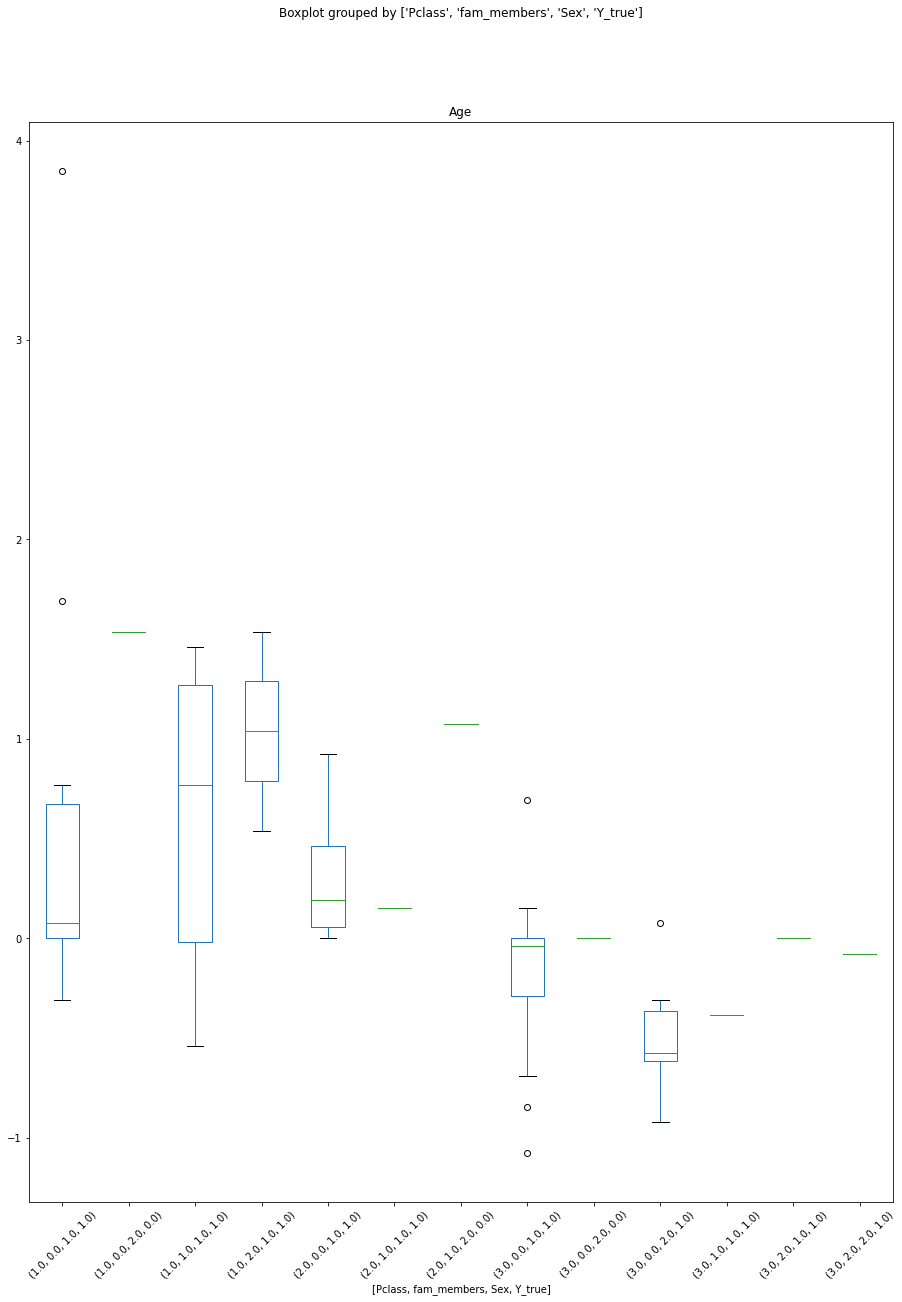

In [2661]:
errors_pd.boxplot(column='Age', 
                  by=['Pclass',"fam_members", "Sex", "Y_true"], 
                  figsize= (15,20), 
                  grid=False,
                  rot = 45)

In [2662]:
errors_pd = X_valid.copy(deep=True)
errors_pd["Y_true"] = y_valid
errors_pd["Y_pred"] = y_pred_valid
errors_pd = errors_pd.loc[errors_pd["Y_true"] != errors_pd["Y_pred"], :]
errors_pd.head()



,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
607,0.694936,1.0,1.0,2.0,0.0,-0.230769,1.0,0.0
804,-0.323921,3.0,1.0,2.0,0.0,-0.230769,1.0,0.0
429,-0.277363,3.0,1.0,2.0,0.0,0.153846,1.0,0.0
501,-0.290356,3.0,2.0,3.0,0.0,-0.692308,0.0,1.0
17,-0.062981,2.0,1.0,2.0,0.0,0.000000,1.0,0.0


In [2663]:
errors_pd.groupby(["Pclass","fam_members","Sex","Y_pred"]).count()["Y_true"]

Pclass  fam_members  Sex  Y_pred
1.0     0.0          1.0  0.0        6
                          1.0        1
        1.0          1.0  0.0        6
        2.0          1.0  0.0        1
        3.0          1.0  0.0        2
        5.0          2.0  0.0        2
2.0     0.0          1.0  0.0        3
                     2.0  0.0        3
                          1.0        1
        1.0          2.0  0.0        1
        2.0          1.0  1.0        1
3.0     0.0          1.0  0.0       12
                          1.0        3
                     2.0  0.0        4
                          1.0        2
        1.0          1.0  0.0        1
                     2.0  0.0        9
                          1.0        1
        2.0          1.0  0.0        1
                          1.0        2
                     2.0  1.0        2
        4.0          1.0  1.0        1
        6.0          1.0  0.0        1
                     2.0  0.0        1
        7.0          2.0  1.0  

<AxesSubplot:title={'center':'Age'}, xlabel='[Pclass, fam_members, Sex, Y_true]'>

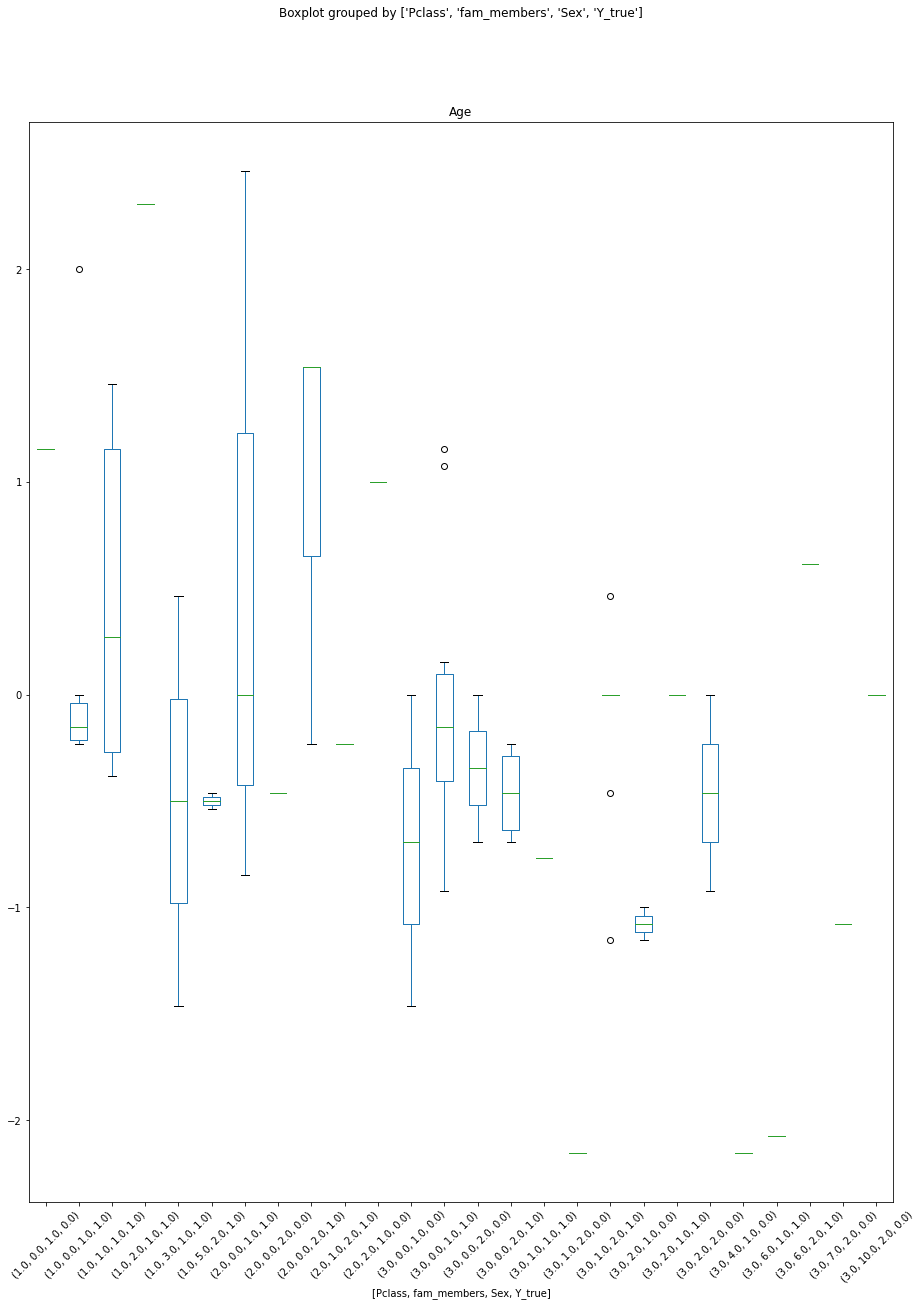

In [2664]:
errors_pd.boxplot(column='Age', 
                  by=['Pclass',"fam_members", "Sex", "Y_true"], 
                  figsize= (15,20), 
                  grid=False,
                  rot = 45)

#### Correctly classified
We repeat the same analysis to explore the correct classification. The training dataset has let classified well the dataset. However it tends to overfit. 

In [2665]:
correct_pd = X_train.copy(deep=True)
correct_pd["Y_true"] = y_train
correct_pd["Y_pred"] = y_pred_train
correct_pd = correct_pd.loc[correct_pd["Y_true"] == correct_pd["Y_pred"], :]
correct_pd.head()



,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
844,-0.250836,3.0,1.0,2.0,0.0,-1.000000,0.0,0.0
316,0.500043,2.0,2.0,2.0,1.0,-0.461538,1.0,1.0
768,0.419921,3.0,1.0,3.0,1.0,0.000000,0.0,0.0
130,-0.284041,3.0,1.0,4.0,0.0,0.230769,0.0,0.0
110,1.626091,1.0,1.0,2.0,0.0,1.307692,0.0,0.0


In [2666]:
correct_pd.groupby(["Pclass","fam_members","Sex","Y_pred"]).count()["Y_true"]

Pclass  fam_members  Sex  Y_pred
1.0     0.0          1.0  0.0        33
                          1.0         6
                     2.0  1.0        22
        1.0          1.0  0.0        13
                     2.0  1.0        20
        2.0          1.0  1.0         2
                     2.0  1.0         9
        3.0          1.0  1.0         1
                     2.0  0.0         1
                          1.0         1
        4.0          2.0  1.0         1
2.0     0.0          1.0  0.0        38
                     2.0  0.0         2
                          1.0        14
        1.0          1.0  0.0        10
                     2.0  0.0         1
                          1.0         8
        2.0          1.0  0.0         3
                          1.0         5
                     2.0  0.0         1
                          1.0        10
        3.0          1.0  0.0         2
                          1.0         1
                     2.0  1.0         6
       

<AxesSubplot:title={'center':'Age'}, xlabel='[Pclass, fam_members, Sex, Y_true]'>

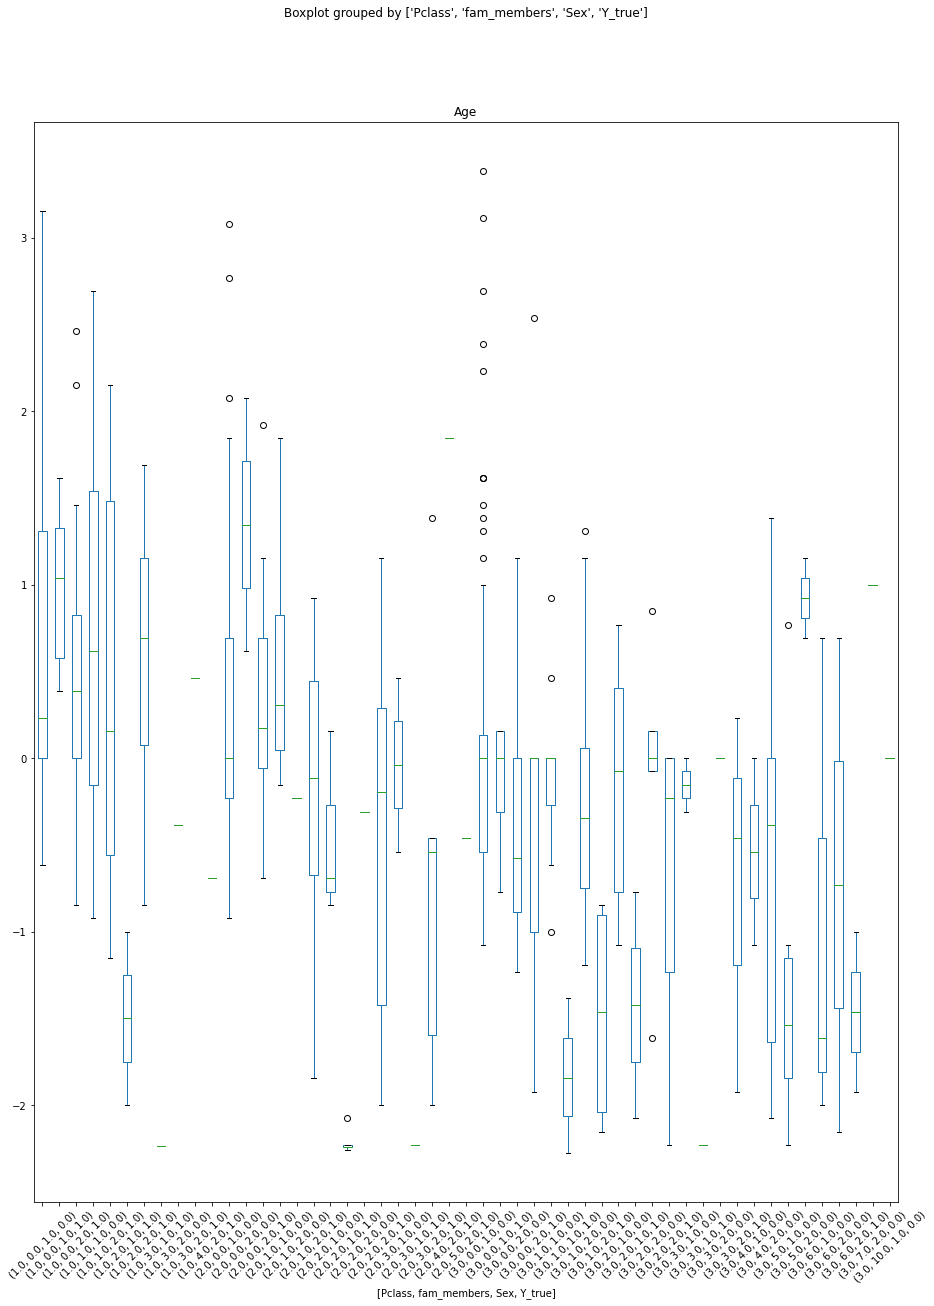

In [2667]:
correct_pd.boxplot(column='Age', 
                  by=['Pclass',"fam_members", "Sex", "Y_true"], 
                  figsize= (15,20), 
                  grid=False,
                  rot = 45)

The prediction on the validation dataset has been correct across the classes the family and the genders. Other elements may be affecting the misclassification. We will add more statistical variable for random forrest and decision trees. 

In [2668]:
correct_pd = X_valid.copy(deep=True)
correct_pd["Y_true"] = y_valid
correct_pd["Y_pred"] = y_pred_valid
correct_pd = correct_pd.loc[correct_pd["Y_true"] == correct_pd["Y_pred"], :]
correct_pd.head()



,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
369,2.375346,1.0,2.0,4.0,0.0,-0.461538,1.0,1.0
541,0.728501,3.0,2.0,2.0,6.0,-1.615385,0.0,0.0
196,-0.290356,3.0,1.0,3.0,0.0,0.000000,0.0,0.0
810,-0.284401,3.0,1.0,2.0,0.0,-0.307692,0.0,0.0
427,0.500043,2.0,2.0,2.0,0.0,-0.846154,1.0,1.0


In [2669]:
correct_pd.groupby(["Pclass","fam_members","Sex","Y_pred"]).count()["Y_true"]

Pclass  fam_members  Sex  Y_pred
1.0     0.0          1.0  0.0       16
                          1.0        3
                     2.0  1.0       11
        1.0          1.0  0.0        6
                     2.0  1.0       19
        2.0          1.0  0.0        6
                     2.0  1.0        4
        3.0          2.0  0.0        1
                          1.0        1
        4.0          2.0  1.0        1
        5.0          1.0  0.0        2
2.0     0.0          1.0  0.0       27
                     2.0  1.0       12
        1.0          1.0  0.0        4
                     2.0  1.0        8
        2.0          1.0  0.0        5
                          1.0        3
                     2.0  1.0        3
        3.0          1.0  0.0        1
                     2.0  1.0        3
3.0     0.0          1.0  0.0       91
                          1.0        1
                     2.0  0.0        6
                          1.0        4
        1.0          1.0  0.0  

<AxesSubplot:title={'center':'Age'}, xlabel='[Pclass, fam_members, Sex, Y_true]'>

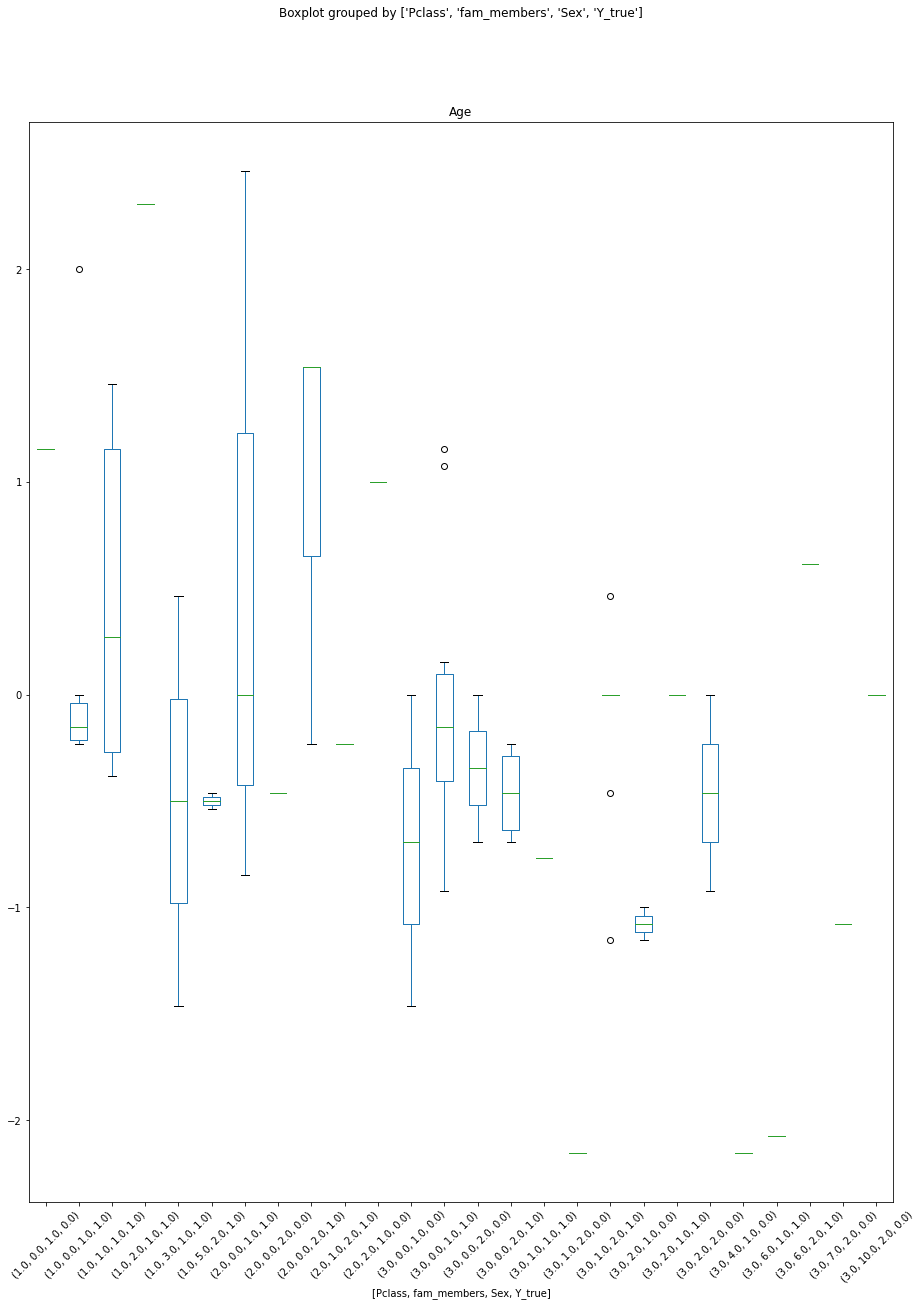

In [2670]:
errors_pd.boxplot(column='Age', 
                  by=['Pclass',"fam_members", "Sex", "Y_true"], 
                  figsize= (15,20), 
                  grid=False,
                  rot = 45)

The passenger class  and being  male can lead  to errors. However, the number of female passengers increases as the class lower. The importance suggests the Age, Sex and Fare may play an important to identify a survivor to someone who perished. The fare may indicate the passenger class. 

The distribution of age grouped by gender and passenger class appears to to varies between the validation and training datasets. Many of the grouping appears to be skewed too. Therefore, it could lower the accuracy of the decision tree predictions on validation and prediction datasets. 

count      mean       std       min       25%       50%       75%  \
Sex Pclass                                                                      
1.0 1.0      73.0  0.670622  1.126949 -2.236923  0.000000  0.538462  1.384615   
    2.0      64.0  0.079123  1.120334 -2.256154 -0.403846  0.000000  0.480769   
    3.0     207.0 -0.128421  0.815541 -2.275385 -0.615385  0.000000  0.000000   
2.0 1.0      55.0  0.425175  0.919849 -1.153846 -0.192308  0.384615  1.115385   
    2.0      45.0 -0.009402  1.034607 -2.000000 -0.461538  0.000000  0.769231   
    3.0      90.0 -0.414530  0.893464 -2.230769 -0.923077 -0.269231  0.000000   

                 max  
Sex Pclass            
1.0 1.0     3.846154  
    2.0     3.076923  
    3.0     3.384615  
2.0 1.0     2.461538  
    2.0     2.076923  
    3.0     2.538462

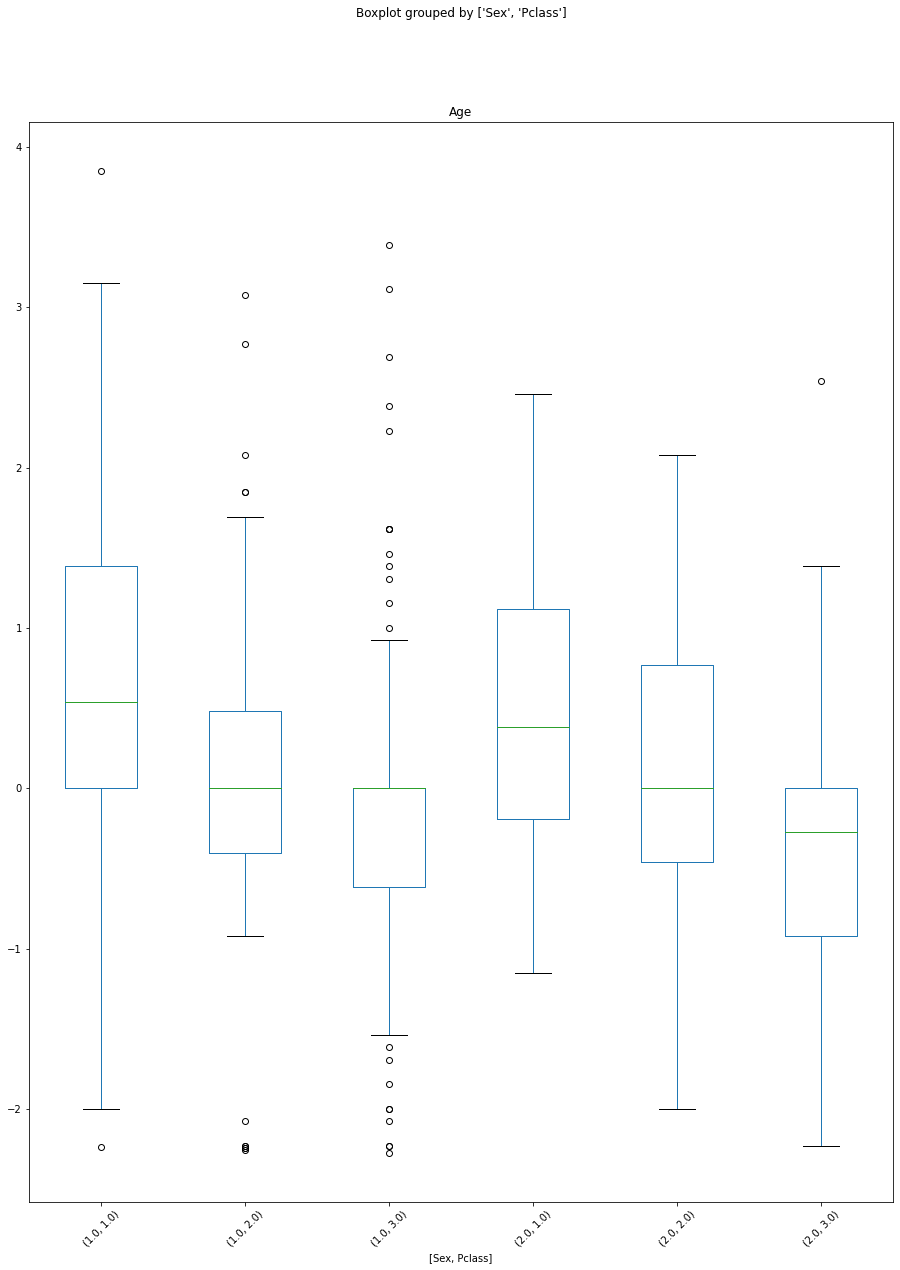

In [2671]:
X_train.boxplot(column='Age', 
                  by=["Sex", "Pclass"], 
                  figsize= (15,20), 
                  grid=False,
                  rot = 45)
X_train.groupby(["Sex", "Pclass"]).describe()["Age"]

count      mean       std       min       25%       50%       75%  \
Sex Pclass                                                                      
1.0 1.0      49.0  0.789639  1.088398 -1.461538  0.000000  0.461538  1.692308   
    2.0      44.0  0.013112  1.053801 -2.153846 -0.538462 -0.038462  0.403846   
    3.0     140.0 -0.295604  0.786890 -2.230769 -0.769231 -0.076923  0.000000   
2.0 1.0      39.0  0.173570  1.100058 -2.153846 -0.576923  0.000000  0.692308   
    2.0      31.0 -0.220844  0.888396 -2.153846 -0.846154 -0.230769  0.269231   
    3.0      54.0 -0.507835  0.841030 -2.250000 -1.038462  0.000000  0.000000   

                 max  
Sex Pclass            
1.0 1.0     3.076923  
    2.0     2.461538  
    3.0     1.961538  
2.0 1.0     2.538462  
    2.0     1.538462  
    3.0     0.846154

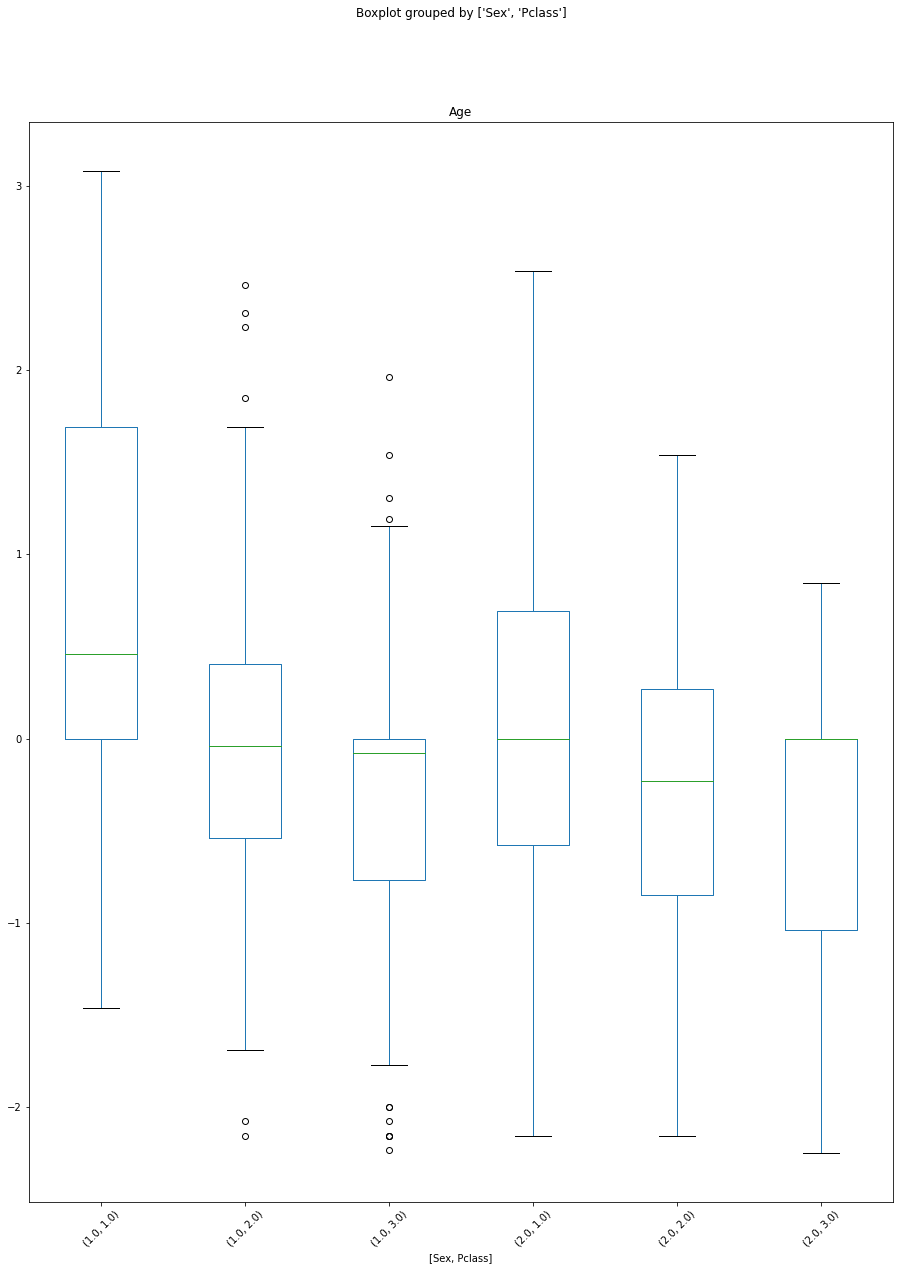

In [2672]:
X_valid.boxplot(column='Age', 
                  by=["Sex", "Pclass"], 
                  figsize= (15,20), 
                  grid=False,
                  rot = 45)
X_valid.groupby(["Sex", "Pclass"]).describe()["Age"]

The distibution per gender and passenger class of fare also varies between the training and validation dataset. For that reason, we surmise it could lead to overfitting to towards the training datasets and affect the predictions on the validation and testing datasets.

count      mean       std       min       25%       50%       75%  \
Sex Pclass                                                                      
1.0 1.0      73.0  2.129921  3.147516 -0.626005  0.574570  1.041413  2.721281   
    2.0      64.0  0.225744  0.636260 -0.626005 -0.068124 -0.052153  0.500043   
    3.0     207.0 -0.081902  0.490356 -0.626005 -0.290356 -0.282777 -0.214564   
2.0 1.0      55.0  4.189039  3.469143  0.496977  1.862310  3.233057  5.483978   
    2.0      45.0  0.381259  0.532352 -0.171255 -0.062981  0.370115  0.510871   
    3.0      90.0 -0.019152  0.362029 -0.333665 -0.288686 -0.199856  0.097265   

                  max  
Sex Pclass             
1.0 1.0     21.562738  
    2.0      2.557247  
    3.0      2.386174  
2.0 1.0     21.562738  
    2.0      2.189115  
    3.0      1.405213

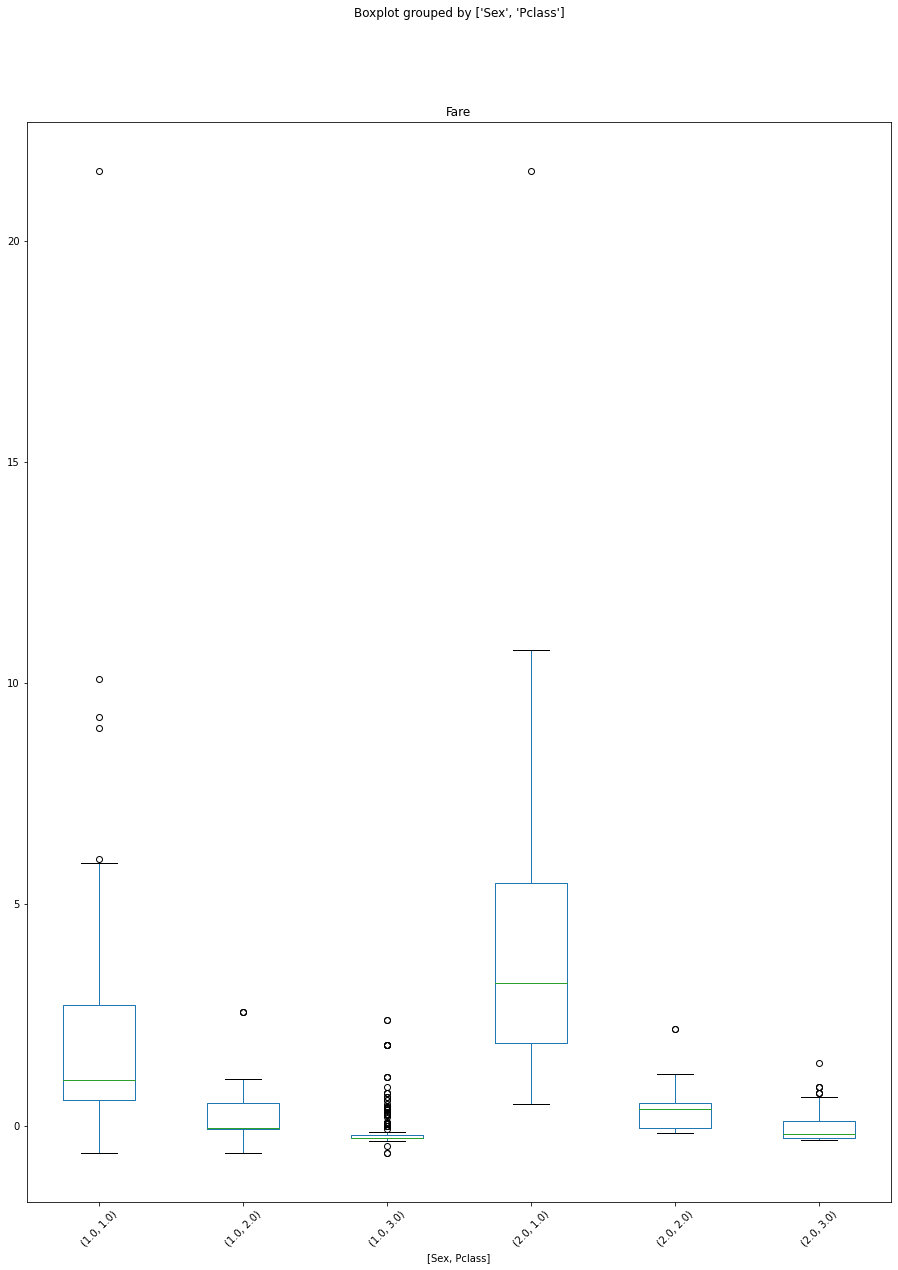

In [2673]:
X_train.boxplot(column='Fare', 
                  by=["Sex", "Pclass"], 
                  figsize= (15,20), 
                  grid=False,
                  rot = 45)
X_train.groupby(["Sex", "Pclass"]).describe()["Fare"]

count      mean       std       min       25%       50%       75%  \
Sex Pclass                                                                      
1.0 1.0      49.0  2.517351  3.671920 -0.626005  0.694936  1.626091  2.804111   
    2.0      44.0  0.233743  0.667956 -0.626005 -0.127945 -0.062981  0.500043   
    3.0     140.0 -0.071327  0.529842 -0.626005 -0.290356 -0.282777 -0.175091   
2.0 1.0      39.0  3.661714  2.836481  0.523864  1.863843  2.788953  3.347646   
    2.0      31.0  0.244587  0.359467 -0.171255 -0.062981  0.283496  0.500043   
    3.0      54.0  0.224169  0.658672 -0.312011 -0.277363  0.050527  0.419921   

                  max  
Sex Pclass             
1.0 1.0     21.562738  
    2.0      2.557247  
    3.0      2.386174  
2.0 1.0     10.764405  
    2.0      1.174771  
    3.0      2.386174

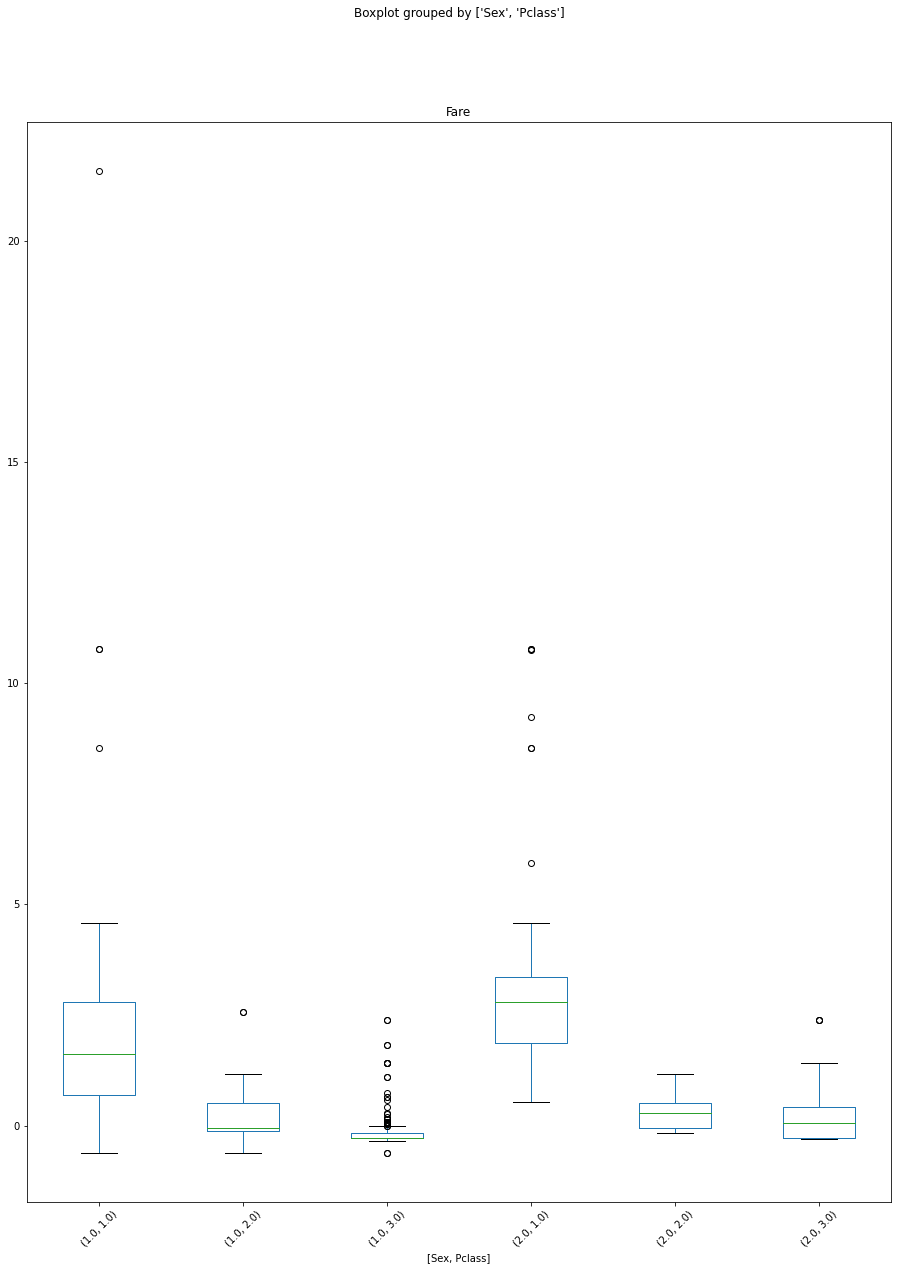

In [2674]:
X_valid.boxplot(column='Fare', 
                  by=["Sex", "Pclass"], 
                  figsize= (15,20), 
                  grid=False,
                  rot = 45)
X_valid.groupby(["Sex", "Pclass"]).describe()["Fare"]

## Classification using test datasets

In [2675]:
y_pred = clf.predict(X_test)
decision_tree_pred = pd.DataFrame({"PassengerId": titanic_test.PassengerId,
                                   "clf_y_pred": y_pred})
decision_tree_pred

,PassengerId,clf_y_pred
0,892.0,0.0
1,893.0,0.0
2,894.0,0.0
3,895.0,0.0
4,896.0,1.0
...,...,...
413,1305.0,0.0
414,1306.0,1.0
415,1307.0,0.0
416,1308.0,0.0


In [2676]:
results_test_copy = results_test.copy(deep=True)

In [2677]:
decision_tree_pred[["PassengerId","clf_y_pred"]]

,PassengerId,clf_y_pred
0,892.0,0.0
1,893.0,0.0
2,894.0,0.0
3,895.0,0.0
4,896.0,1.0
...,...,...
413,1305.0,0.0
414,1306.0,1.0
415,1307.0,0.0
416,1308.0,0.0


In [2678]:
results_test = results_test.merge(decision_tree_pred[["PassengerId","clf_y_pred"]], on = 'PassengerId', how = "outer")
results_test.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,fam_members,lr_y_pred,knn_y_pred,clf_y_pred
0,892.0,3.0,1.0,0.431373,-0.281005,3.0,0.0,NaN,NaN,0.0
1,893.0,3.0,2.0,1.411765,-0.316176,2.0,1.0,NaN,NaN,0.0
2,894.0,2.0,1.0,2.588235,-0.202184,3.0,0.0,NaN,NaN,0.0
3,895.0,3.0,1.0,-0.156863,-0.245660,2.0,0.0,NaN,NaN,0.0
4,896.0,3.0,2.0,-0.549020,-0.091902,2.0,2.0,NaN,NaN,1.0


# Method: Random Forrest

We use Random Forrest to classify the titanic passengers as either surviving or not the accident. We use again the same statistical variable as Decisiont Trees.

## Model fitting and classification

Random Forrest overfits to the training dataset. 

In [2679]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = range(1,20)
max_depths   = range(1,40)

for est in n_estimators:
    for depth in max_depths:
        rf = RandomForestClassifier(n_estimators = est, max_depth = depth, 
                                    random_state = 42, class_weight={0:6.,1:4},max_features = 6)
        rf.fit(X_train, y_train)
        train_score = rf.score(X_train, y_train)
        test_score  = rf.score(X_valid, y_valid)
        print(" - estimators : ", est, 
              " - max depths : ", depth, 
              " - train score : ", train_score,
              " - valid score : ", valid_score)
        
        


 - estimators :  1  - max depths :  1  - train score :  0.7808988764044944  - valid score :  0.773109243697479
 - estimators :  1  - max depths :  2  - train score :  0.7771535580524345  - valid score :  0.773109243697479
 - estimators :  1  - max depths :  3  - train score :  0.8071161048689138  - valid score :  0.773109243697479
 - estimators :  1  - max depths :  4  - train score :  0.8277153558052435  - valid score :  0.773109243697479
 - estimators :  1  - max depths :  5  - train score :  0.8314606741573034  - valid score :  0.773109243697479
 - estimators :  1  - max depths :  6  - train score :  0.8651685393258427  - valid score :  0.773109243697479
 - estimators :  1  - max depths :  7  - train score :  0.8820224719101124  - valid score :  0.773109243697479
 - estimators :  1  - max depths :  8  - train score :  0.8857677902621723  - valid score :  0.773109243697479
 - estimators :  1  - max depths :  9  - train score :  0.8895131086142322  - valid score :  0.773109243697479
 

We discover again the learning overfit on the training dataset. So we choose  a maximum depth at around 6 and n estimator of 11. 

In [2680]:
rf = RandomForestClassifier(n_estimators = 11, max_depth=6, random_state = 42, class_weight={0:6.,1:4}, max_features = 6)
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight={0: 6.0, 1: 4}, max_depth=6, max_features=6,
                       n_estimators=11, random_state=42)

In [2681]:
rf_train_score = rf.score(X_train, y_train)
rf_train_score

0.8801498127340824

In [2682]:
rf_valid_score = rf.score(X_valid, y_valid)
rf_valid_score

0.8067226890756303

The age, the fare and the gender appears to contribute the most to predicting accurately the surviving or not the accident.  It is surprising the passenger class influence less random forrest. 

In [2683]:
importances = rf.feature_importances_
importances =  pd.DataFrame(x_cols, importances)
importances


,0
0.199528,Fare
0.140924,Pclass
0.390318,Sex
0.023663,Embarked
0.053330,fam_members
0.192238,Age


We found the classes of importances are Fares, Sex, and Age.  

### Which passengers were misclassified ?

We explore further the statistical variables and their values that may have led to misclassification for the training and validation dataset. The model predicted that more passengers appeared perished during the accident, than the labels suggest. We notice that most mispredictions involves single passengers - both genders. Male singles passengers appears to have been misclassified the most as perishing, when they have survived and single women the reverse. 



In [2684]:
y_pred_train = rf.predict(X_train)
cm = confusion_matrix(y_train, y_pred_train)
cm

array([[319,  10],
       [ 54, 151]])

In [2685]:
accuracy          = (cm[0][0] + cm[1][1])/len(y_pred_train)
misclassification = (cm[0][1] + cm[1][0])/len(y_pred_train)
sensitivity       = (cm[0][0])/(cm[0][0] + cm[0][1])
specificity       = (cm[1][1])/(cm[1][0] + cm[1][1])
print("Accuracy         : ", accuracy)
print("Misclassfication : ", misclassification)
print("Sensitivivity    : ", sensitivity)
print("Specificity      : ", specificity)


Accuracy         :  0.8801498127340824
Misclassfication :  0.1198501872659176
Sensitivivity    :  0.9696048632218845
Specificity      :  0.7365853658536585


In [2686]:
y_pred_valid = rf.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred_valid)
cm

array([[203,  17],
       [ 52,  85]])

In [2687]:
accuracy          = (cm[0][0] + cm[1][1])/len(y_pred_valid)
misclassification = (cm[0][1] + cm[1][0])/len(y_pred_valid)
sensitivity       = (cm[0][0])/(cm[0][0] + cm[0][1])
specificity       = (cm[1][1])/(cm[1][0] + cm[1][1])
print("Accuracy         : ", accuracy)
print("Misclassfication : ", misclassification)
print("Sensitivivity    : ", sensitivity)
print("Specificity      : ", specificity)


Accuracy         :  0.8067226890756303
Misclassfication :  0.19327731092436976
Sensitivivity    :  0.9227272727272727
Specificity      :  0.6204379562043796


#### Capture classification for analysis

In [2688]:
results_train_copy = results_train.copy(deep=True)

In [2689]:
y_pred = rf.predict(X_train)
rf_pred                 = X_train.copy()
rf_pred["rf_y_pred"]   = y_pred
rf_pred["PassengerId"]  = x_train_pass_id
rf_pred.head()

,Fare,Pclass,Sex,Embarked,fam_members,Age,rf_y_pred,PassengerId
844,-0.250836,3.0,1.0,2.0,0.0,-1.000000,0.0,845.0
316,0.500043,2.0,2.0,2.0,1.0,-0.461538,1.0,317.0
768,0.419921,3.0,1.0,3.0,1.0,0.000000,0.0,769.0
255,0.034284,3.0,2.0,4.0,2.0,-0.076923,0.0,256.0
130,-0.284041,3.0,1.0,4.0,0.0,0.230769,0.0,131.0


In [2690]:
results_train = results_train.merge(rf_pred[["PassengerId", "rf_y_pred"]], 
                                     on = "PassengerId", how="outer")

results_train.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/displayhook.py:276: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,fam_members,y,lr_y_pred,knn_y_pred,clf_y_pred,rf_y_pred
0,1.0,0.0,3.0,1.0,-0.615385,-0.312011,2.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,1.0,2.0,0.615385,2.461242,4.0,1.0,1.0,1.0,1.0,1.0,NaN
2,3.0,1.0,3.0,2.0,-0.307692,-0.282777,2.0,0.0,1.0,1.0,1.0,0.0,0.0
3,4.0,1.0,1.0,2.0,0.384615,1.673732,2.0,1.0,1.0,1.0,1.0,1.0,NaN
4,5.0,0.0,3.0,1.0,0.384615,-0.277363,2.0,0.0,0.0,0.0,0.0,0.0,NaN


In [2691]:
y_pred = rf.predict(X_valid)
rf_pred = X_valid.copy()
rf_pred["rf_y_pred"] = y_pred
rf_pred["PassengerId"] = x_valid_pass_id
rf_pred.head()

,Fare,Pclass,Sex,Embarked,fam_members,Age,rf_y_pred,PassengerId
369,2.375346,1.0,2.0,4.0,0.0,-0.461538,1.0,370.0
541,0.728501,3.0,2.0,2.0,6.0,-1.615385,0.0,542.0
196,-0.290356,3.0,1.0,3.0,0.0,0.000000,0.0,197.0
810,-0.284401,3.0,1.0,2.0,0.0,-0.307692,0.0,811.0
427,0.500043,2.0,2.0,2.0,0.0,-0.846154,1.0,428.0


In [2692]:

results_train.loc[results_train.PassengerId.isin(rf_pred.PassengerId), "rf_y_pred"] = rf_pred["rf_y_pred"]
results_train.head()


,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,fam_members,y,lr_y_pred,knn_y_pred,clf_y_pred,rf_y_pred
0,1.0,0.0,3.0,1.0,-0.615385,-0.312011,2.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,1.0,2.0,0.615385,2.461242,4.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3.0,1.0,3.0,2.0,-0.307692,-0.282777,2.0,0.0,1.0,1.0,1.0,0.0,0.0
3,4.0,1.0,1.0,2.0,0.384615,1.673732,2.0,1.0,1.0,1.0,1.0,1.0,1.0
4,5.0,0.0,3.0,1.0,0.384615,-0.277363,2.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Capture classification for analysis

In [2693]:
results_train_copy = results_train.copy(deep=True)

In [2833]:
y_pred = rf.predict(X_train)
rf_pred                 = X_train.copy()
rf_pred["rf_y_pred"]   = y_pred
rf_pred["PassengerId"]  = x_train_pass_id
rf_pred.head()

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- C
- Class_1
- Class_2
- Class_3
- Parch
- ...
Feature names seen at fit time, yet now missing:
- Age
- Embarked
- Fare
- Pclass
- Sex
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 25 features, but RandomForestClassifier is expecting 6 features as input.

In [2695]:
results_train = results_train.merge(rf_pred[["PassengerId", "rf_y_pred"]], 
                                     on = "PassengerId", how="outer")

results_train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,fam_members,y,lr_y_pred,knn_y_pred,clf_y_pred_x,rf_y_pred,clf_y_pred_y
0,1.0,0.0,3.0,1.0,-0.615385,-0.312011,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,1.0,2.0,0.615385,2.461242,4.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
2,3.0,1.0,3.0,2.0,-0.307692,-0.282777,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,4.0,1.0,1.0,2.0,0.384615,1.673732,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
4,5.0,0.0,3.0,1.0,0.384615,-0.277363,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [2696]:
y_pred = rf.predict(X_valid)
rf_pred = X_valid.copy()
rf_pred["rf_y_pred"] = y_pred
rf_pred["PassengerId"] = x_valid_pass_id
rf_pred

,Fare,Pclass,Sex,Embarked,fam_members,Age,clf_y_pred,PassengerId
369,2.375346,1.0,2.0,4.0,0.0,-0.461538,1.0,370.0
541,0.728501,3.0,2.0,2.0,6.0,-1.615385,0.0,542.0
196,-0.290356,3.0,1.0,3.0,0.0,0.000000,0.0,197.0
810,-0.284401,3.0,1.0,2.0,0.0,-0.307692,0.0,811.0
427,0.500043,2.0,2.0,2.0,0.0,-0.846154,1.0,428.0
...,...,...,...,...,...,...,...,...
174,0.703416,1.0,1.0,4.0,0.0,2.000000,0.0,175.0
297,5.937556,1.0,2.0,2.0,3.0,-2.153846,0.0,298.0
244,-0.313093,3.0,1.0,4.0,0.0,0.000000,0.0,245.0
38,0.153567,3.0,2.0,2.0,2.0,-0.923077,1.0,39.0


In [2697]:

results_train.loc[results_train.PassengerId.isin(rf_pred.PassengerId), "rf_y_pred"] = rf_pred["rf_y_pred"]
results_train.head()


,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,fam_members,y,lr_y_pred,knn_y_pred,clf_y_pred_x,rf_y_pred,clf_y_pred_y,clf_y_pred
0,1.0,0.0,3.0,1.0,-0.615385,-0.312011,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,2.0,1.0,1.0,2.0,0.615385,2.461242,4.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0
2,3.0,1.0,3.0,2.0,-0.307692,-0.282777,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN
3,4.0,1.0,1.0,2.0,0.384615,1.673732,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0
4,5.0,0.0,3.0,1.0,0.384615,-0.277363,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


#### Misclassified entries

In [2698]:
errors_pd = X_train.copy(deep=True)
errors_pd["Y_true"] = y_train
errors_pd["Y_pred"] = y_pred_train
errors_pd = errors_pd.loc[errors_pd["Y_true"] != errors_pd["Y_pred"], :]
errors_pd.head()



,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
255,0.034284,3.0,2.0,4.0,2.0,-0.076923,1.0,0.0
233,0.733373,3.0,2.0,2.0,6.0,-1.923077,1.0,0.0
821,-0.250836,3.0,1.0,2.0,0.0,-0.230769,1.0,0.0
673,-0.062981,2.0,1.0,2.0,0.0,0.076923,1.0,0.0
235,-0.299018,3.0,2.0,2.0,0.0,0.000000,0.0,1.0


In [2699]:
errors_pd.groupby(["Pclass","fam_members","Sex","Y_pred"]).count()["Y_true"]

Pclass  fam_members  Sex  Y_pred
1.0     0.0          1.0  0.0       12
        1.0          1.0  0.0        6
        2.0          1.0  0.0        1
2.0     0.0          1.0  0.0        4
                     2.0  1.0        1
        1.0          1.0  0.0        1
                     2.0  1.0        1
        2.0          2.0  1.0        1
3.0     0.0          1.0  0.0       19
                     2.0  0.0        5
                          1.0        4
        1.0          1.0  0.0        2
                     2.0  1.0        1
        2.0          1.0  0.0        1
                          1.0        1
                     2.0  0.0        2
        5.0          1.0  1.0        1
        6.0          2.0  0.0        1
Name: Y_true, dtype: int64

In [2700]:
y_pred_valid = rf.predict(X_valid)
confusion_matrix(y_valid, y_pred_valid)

array([[203,  17],
       [ 52,  85]])

<AxesSubplot:title={'center':'Age'}, xlabel='[Pclass, fam_members, Sex, Y_true]'>

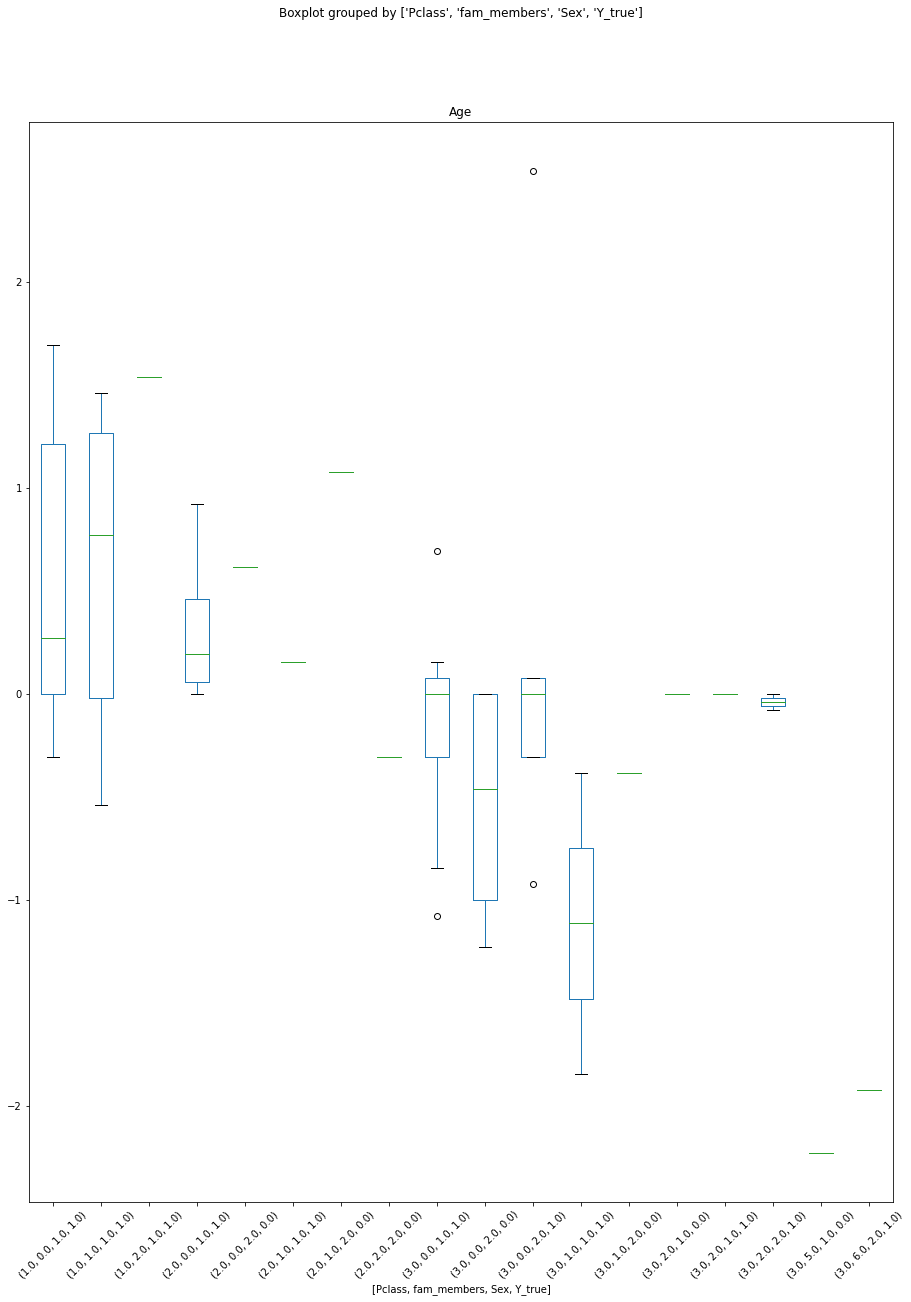

In [2701]:
errors_pd.boxplot(column='Age', 
                  by=['Pclass',"fam_members", "Sex", "Y_true"], 
                  figsize= (15,20), 
                  grid=False,
                  rot = 45)

In [2702]:
errors_pd = X_valid.copy(deep=True)
errors_pd["Y_true"] = y_valid
errors_pd["Y_pred"] = y_pred_valid
errors_pd = errors_pd.loc[errors_pd["Y_true"] != errors_pd["Y_pred"], :]
errors_pd.head()



,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
386,1.405213,3.0,1.0,2.0,7.0,-2.230769,0.0,1.0
607,0.694936,1.0,1.0,2.0,0.0,-0.230769,1.0,0.0
804,-0.323921,3.0,1.0,2.0,0.0,-0.230769,1.0,0.0
824,1.092843,3.0,1.0,2.0,5.0,-2.153846,0.0,1.0
429,-0.277363,3.0,1.0,2.0,0.0,0.153846,1.0,0.0


In [2703]:
errors_pd.groupby(["Pclass","fam_members","Sex","Y_pred"]).count()["Y_true"]

Pclass  fam_members  Sex  Y_pred
1.0     0.0          1.0  0.0        7
                     2.0  0.0        1
        1.0          1.0  0.0        5
        2.0          1.0  0.0        1
                          1.0        1
        3.0          2.0  1.0        1
        5.0          2.0  0.0        1
2.0     0.0          1.0  0.0        3
                     2.0  0.0        2
                          1.0        1
        2.0          1.0  0.0        1
                          1.0        1
3.0     0.0          1.0  0.0       13
                          1.0        1
                     2.0  0.0        1
                          1.0        3
        1.0          1.0  0.0        1
                     2.0  0.0       11
                          1.0        1
        2.0          1.0  0.0        3
                          1.0        2
                     2.0  0.0        1
                          1.0        2
        4.0          1.0  1.0        1
        5.0          1.0  1.0  

<AxesSubplot:title={'center':'Age'}, xlabel='[Pclass, fam_members, Sex, Y_true]'>

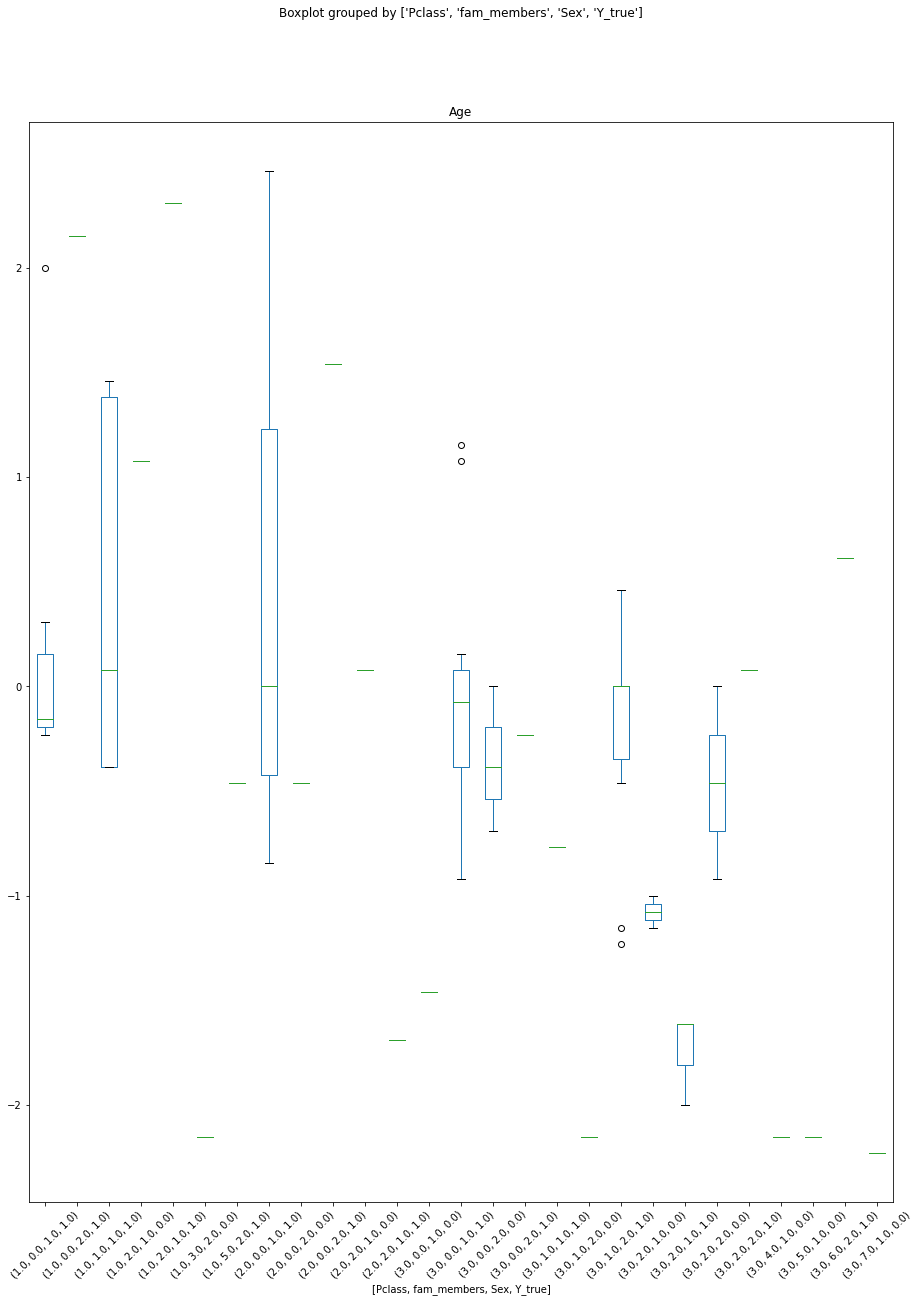

In [2704]:
errors_pd.boxplot(column='Age', 
                  by=['Pclass',"fam_members", "Sex", "Y_true"], 
                  figsize= (15,20), 
                  grid=False,
                  rot = 45)

#### Correctly classified
We repeat the same analysis to explore the correct classification. The training dataset has let classified well the dataset. However it tends to overfit. 

In [2705]:
correct_pd = X_train.copy(deep=True)
correct_pd["Y_true"] = y_train
correct_pd["Y_pred"] = y_pred_train
correct_pd = correct_pd.loc[correct_pd["Y_true"] == correct_pd["Y_pred"], :]
correct_pd.head()



,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
844,-0.250836,3.0,1.0,2.0,0.0,-1.000000,0.0,0.0
316,0.500043,2.0,2.0,2.0,1.0,-0.461538,1.0,1.0
768,0.419921,3.0,1.0,3.0,1.0,0.000000,0.0,0.0
130,-0.284041,3.0,1.0,4.0,0.0,0.230769,0.0,0.0
110,1.626091,1.0,1.0,2.0,0.0,1.307692,0.0,0.0


In [2706]:
correct_pd.groupby(["Pclass","fam_members","Sex","Y_pred"]).count()["Y_true"]

Pclass  fam_members  Sex  Y_pred
1.0     0.0          1.0  0.0        33
                          1.0         4
                     2.0  0.0         1
                          1.0        22
        1.0          1.0  0.0        13
                     2.0  1.0        20
        2.0          1.0  1.0         3
                     2.0  1.0         9
        3.0          1.0  1.0         1
                     2.0  0.0         1
                          1.0         1
        4.0          2.0  1.0         1
2.0     0.0          1.0  0.0        38
                     2.0  0.0         1
                          1.0        14
        1.0          1.0  0.0        10
                     2.0  0.0         1
                          1.0         8
        2.0          1.0  0.0         3
                          1.0         5
                     2.0  1.0        10
        3.0          1.0  0.0         2
                          1.0         1
                     2.0  1.0         6
       

<AxesSubplot:title={'center':'Age'}, xlabel='[Pclass, fam_members, Sex, Y_true]'>

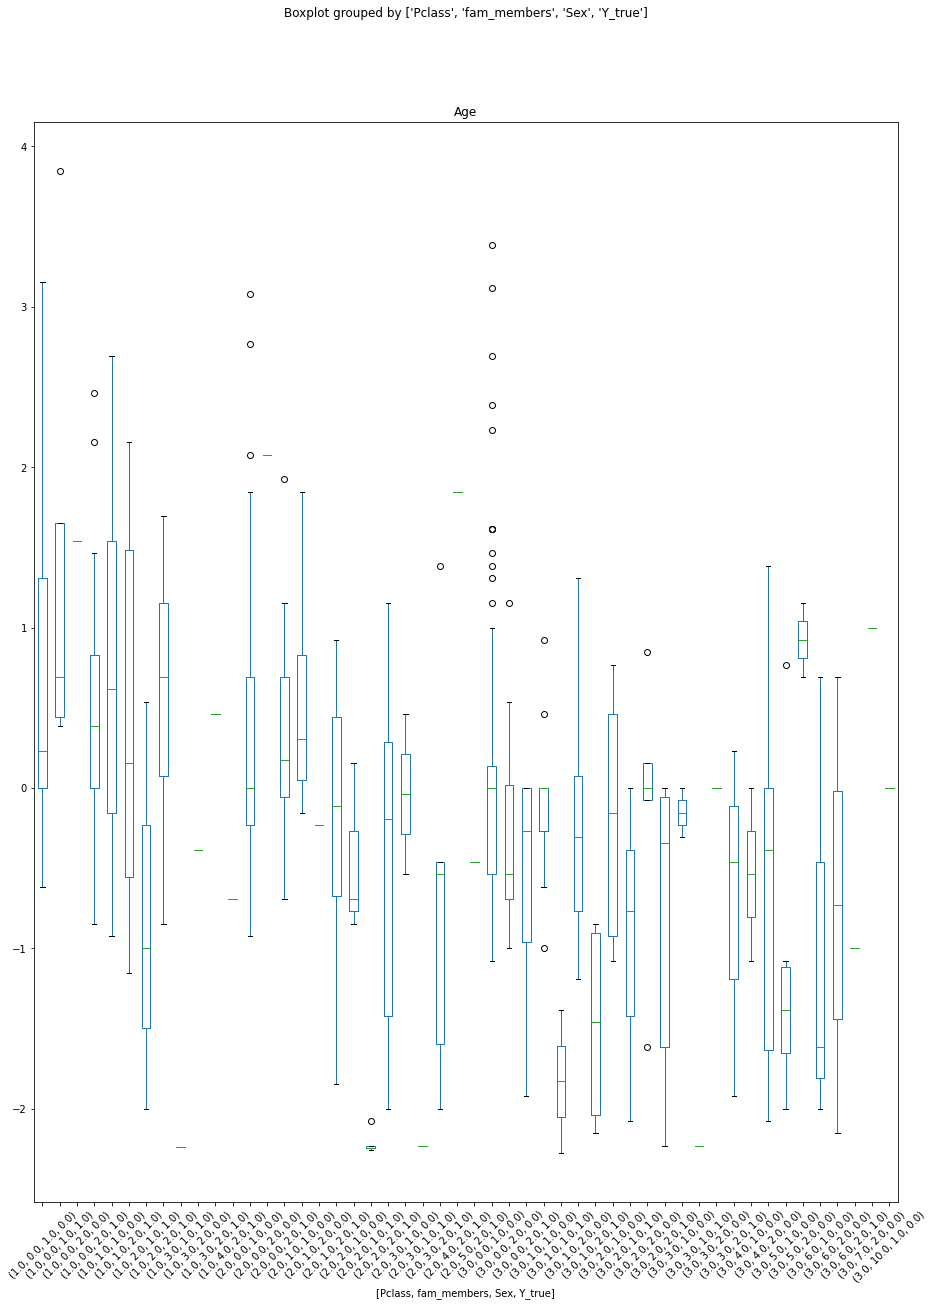

In [2707]:
correct_pd.boxplot(column='Age', 
                  by=['Pclass',"fam_members", "Sex", "Y_true"], 
                  figsize= (15,20), 
                  grid=False,
                  rot = 45)

The prediction on the validation dataset has been correct across the classes the family and the genders. Other elements may be affecting the misclassification. We will add more statistical variable for random forrest and decision trees. 

In [2708]:
correct_pd = X_valid.copy(deep=True)
correct_pd["Y_true"] = y_valid
correct_pd["Y_pred"] = y_pred_valid
correct_pd = correct_pd.loc[correct_pd["Y_true"] == correct_pd["Y_pred"], :]
correct_pd.head()



,Fare,Pclass,Sex,Embarked,fam_members,Age,Y_true,Y_pred
369,2.375346,1.0,2.0,4.0,0.0,-0.461538,1.0,1.0
541,0.728501,3.0,2.0,2.0,6.0,-1.615385,0.0,0.0
196,-0.290356,3.0,1.0,3.0,0.0,0.000000,0.0,0.0
810,-0.284401,3.0,1.0,2.0,0.0,-0.307692,0.0,0.0
427,0.500043,2.0,2.0,2.0,0.0,-0.846154,1.0,1.0


In [2709]:
correct_pd.groupby(["Pclass","fam_members","Sex","Y_pred"]).count()["Y_true"]

Pclass  fam_members  Sex  Y_pred
1.0     0.0          1.0  0.0       17
                          1.0        2
                     2.0  1.0       10
        1.0          1.0  0.0        6
                          1.0        1
                     2.0  1.0       19
        2.0          1.0  0.0        5
                     2.0  1.0        4
        3.0          1.0  1.0        2
                     2.0  1.0        1
        4.0          2.0  1.0        1
        5.0          1.0  0.0        2
                     2.0  1.0        1
2.0     0.0          1.0  0.0       27
                     2.0  1.0       13
        1.0          1.0  0.0        4
                     2.0  1.0        9
        2.0          1.0  0.0        5
                          1.0        2
                     2.0  1.0        3
        3.0          1.0  0.0        1
                     2.0  1.0        3
3.0     0.0          1.0  0.0       93
                     2.0  0.0        5
                          1.0  

<AxesSubplot:title={'center':'Age'}, xlabel='[Pclass, fam_members, Sex, Y_true]'>

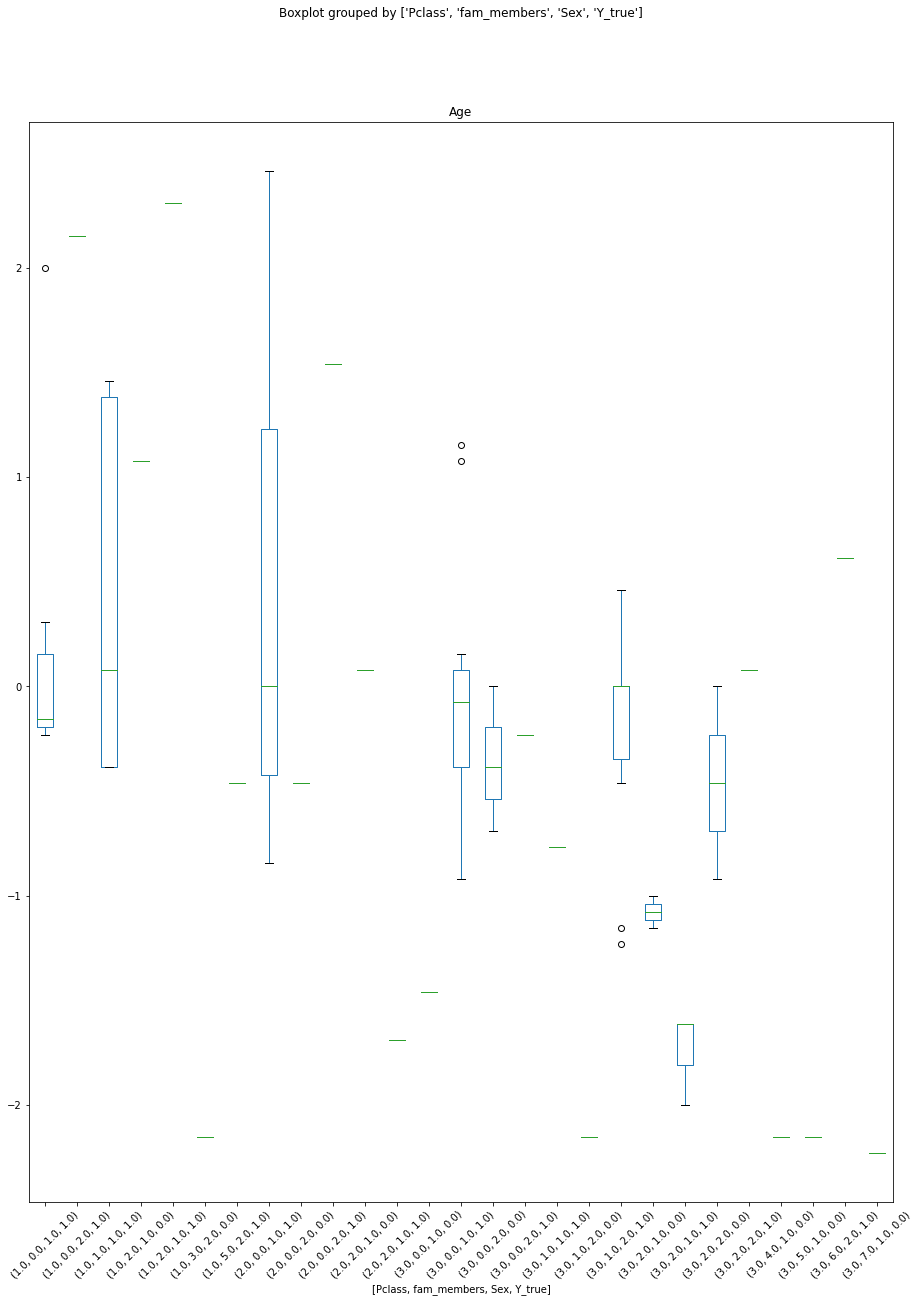

In [2710]:
errors_pd.boxplot(column='Age', 
                  by=['Pclass',"fam_members", "Sex", "Y_true"], 
                  figsize= (15,20), 
                  grid=False,
                  rot = 45)

The passenger class  and being  male can lead  to errors. However, the number of female passengers increases as the class lower. The importance suggests the Age, Sex and Fare may play an important to identify a survivor to someone who perished. The fare may indicate the passenger class. 

The distribution of age grouped by gender and passenger class appears to to varies between the validation and training datasets. Many of the grouping appears to be skewed too. Therefore, it could lower the accuracy of the decision tree predictions on validation and prediction datasets. 

count      mean       std       min       25%       50%       75%  \
Sex Pclass                                                                      
1.0 1.0      73.0  0.670622  1.126949 -2.236923  0.000000  0.538462  1.384615   
    2.0      64.0  0.079123  1.120334 -2.256154 -0.403846  0.000000  0.480769   
    3.0     207.0 -0.128421  0.815541 -2.275385 -0.615385  0.000000  0.000000   
2.0 1.0      55.0  0.425175  0.919849 -1.153846 -0.192308  0.384615  1.115385   
    2.0      45.0 -0.009402  1.034607 -2.000000 -0.461538  0.000000  0.769231   
    3.0      90.0 -0.414530  0.893464 -2.230769 -0.923077 -0.269231  0.000000   

                 max  
Sex Pclass            
1.0 1.0     3.846154  
    2.0     3.076923  
    3.0     3.384615  
2.0 1.0     2.461538  
    2.0     2.076923  
    3.0     2.538462

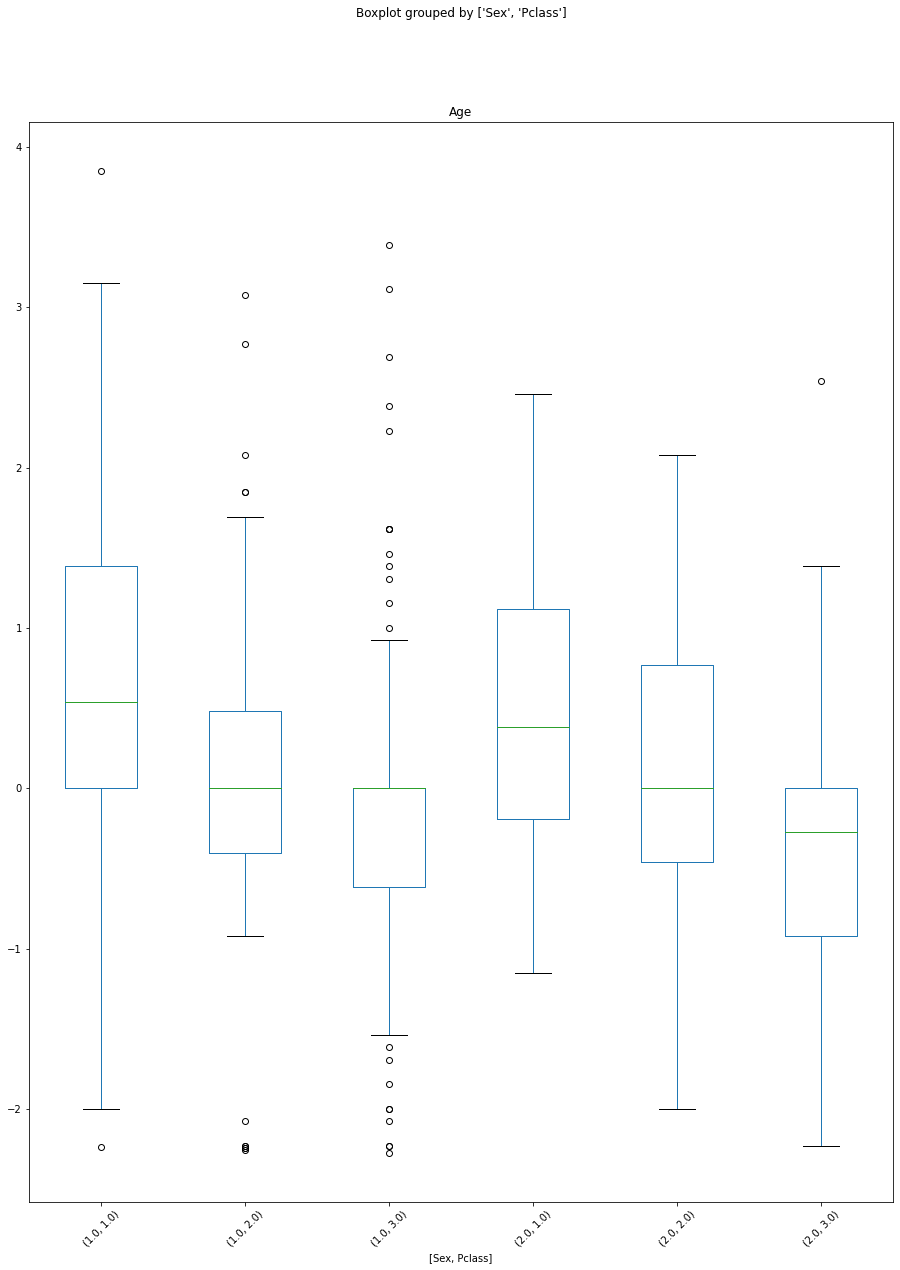

In [2711]:
X_train.boxplot(column='Age', 
                  by=["Sex", "Pclass"], 
                  figsize= (15,20), 
                  grid=False,
                  rot = 45)
X_train.groupby(["Sex", "Pclass"]).describe()["Age"]

count      mean       std       min       25%       50%       75%  \
Sex Pclass                                                                      
1.0 1.0      49.0  0.789639  1.088398 -1.461538  0.000000  0.461538  1.692308   
    2.0      44.0  0.013112  1.053801 -2.153846 -0.538462 -0.038462  0.403846   
    3.0     140.0 -0.295604  0.786890 -2.230769 -0.769231 -0.076923  0.000000   
2.0 1.0      39.0  0.173570  1.100058 -2.153846 -0.576923  0.000000  0.692308   
    2.0      31.0 -0.220844  0.888396 -2.153846 -0.846154 -0.230769  0.269231   
    3.0      54.0 -0.507835  0.841030 -2.250000 -1.038462  0.000000  0.000000   

                 max  
Sex Pclass            
1.0 1.0     3.076923  
    2.0     2.461538  
    3.0     1.961538  
2.0 1.0     2.538462  
    2.0     1.538462  
    3.0     0.846154

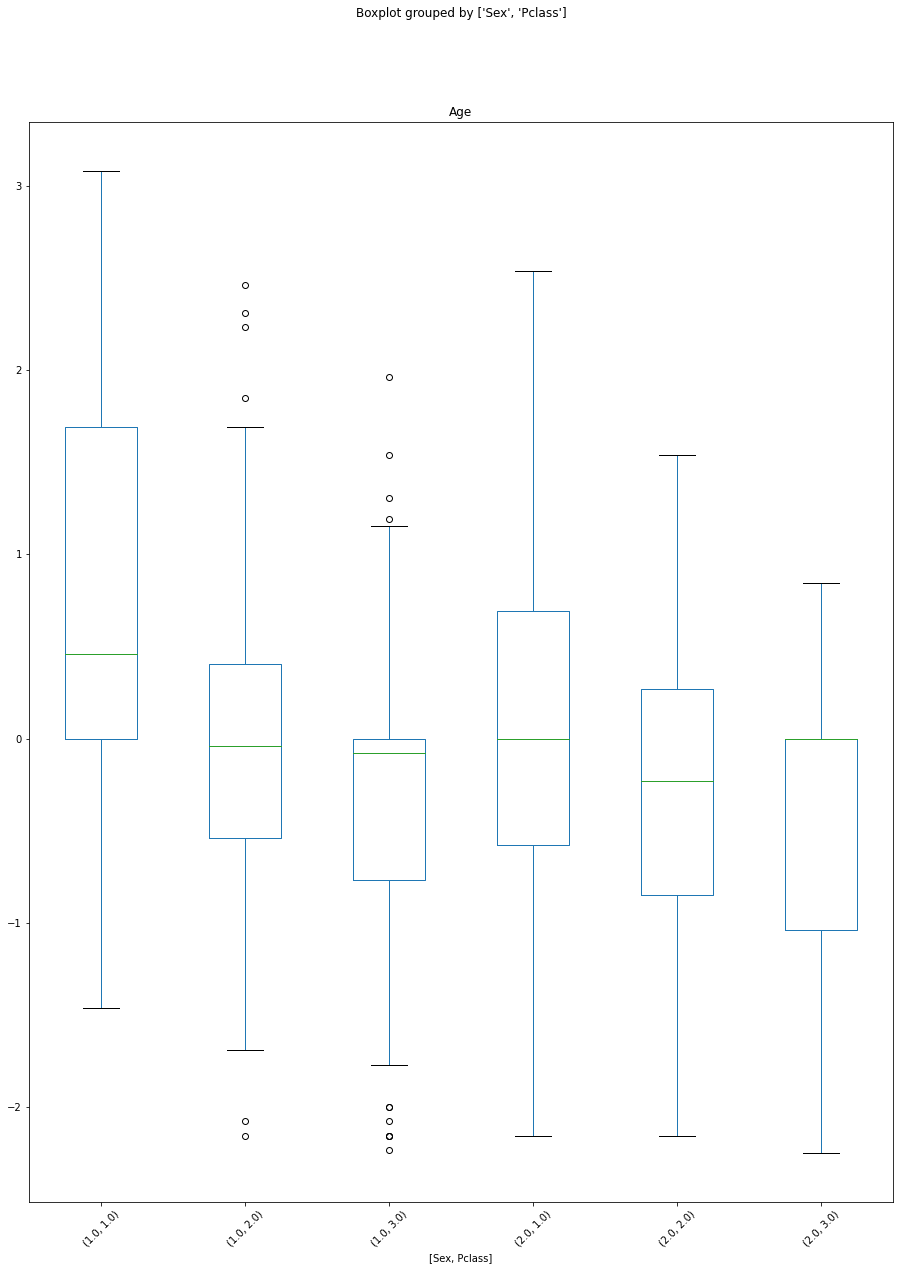

In [2712]:
X_valid.boxplot(column='Age', 
                  by=["Sex", "Pclass"], 
                  figsize= (15,20), 
                  grid=False,
                  rot = 45)
X_valid.groupby(["Sex", "Pclass"]).describe()["Age"]

The distibution per gender and passenger class of fare also varies between the training and validation dataset. For that reason, we surmise it could lead to overfitting to towards the training datasets and affect the predictions on the validation and testing datasets.

count      mean       std       min       25%       50%       75%  \
Sex Pclass                                                                      
1.0 1.0      73.0  2.129921  3.147516 -0.626005  0.574570  1.041413  2.721281   
    2.0      64.0  0.225744  0.636260 -0.626005 -0.068124 -0.052153  0.500043   
    3.0     207.0 -0.081902  0.490356 -0.626005 -0.290356 -0.282777 -0.214564   
2.0 1.0      55.0  4.189039  3.469143  0.496977  1.862310  3.233057  5.483978   
    2.0      45.0  0.381259  0.532352 -0.171255 -0.062981  0.370115  0.510871   
    3.0      90.0 -0.019152  0.362029 -0.333665 -0.288686 -0.199856  0.097265   

                  max  
Sex Pclass             
1.0 1.0     21.562738  
    2.0      2.557247  
    3.0      2.386174  
2.0 1.0     21.562738  
    2.0      2.189115  
    3.0      1.405213

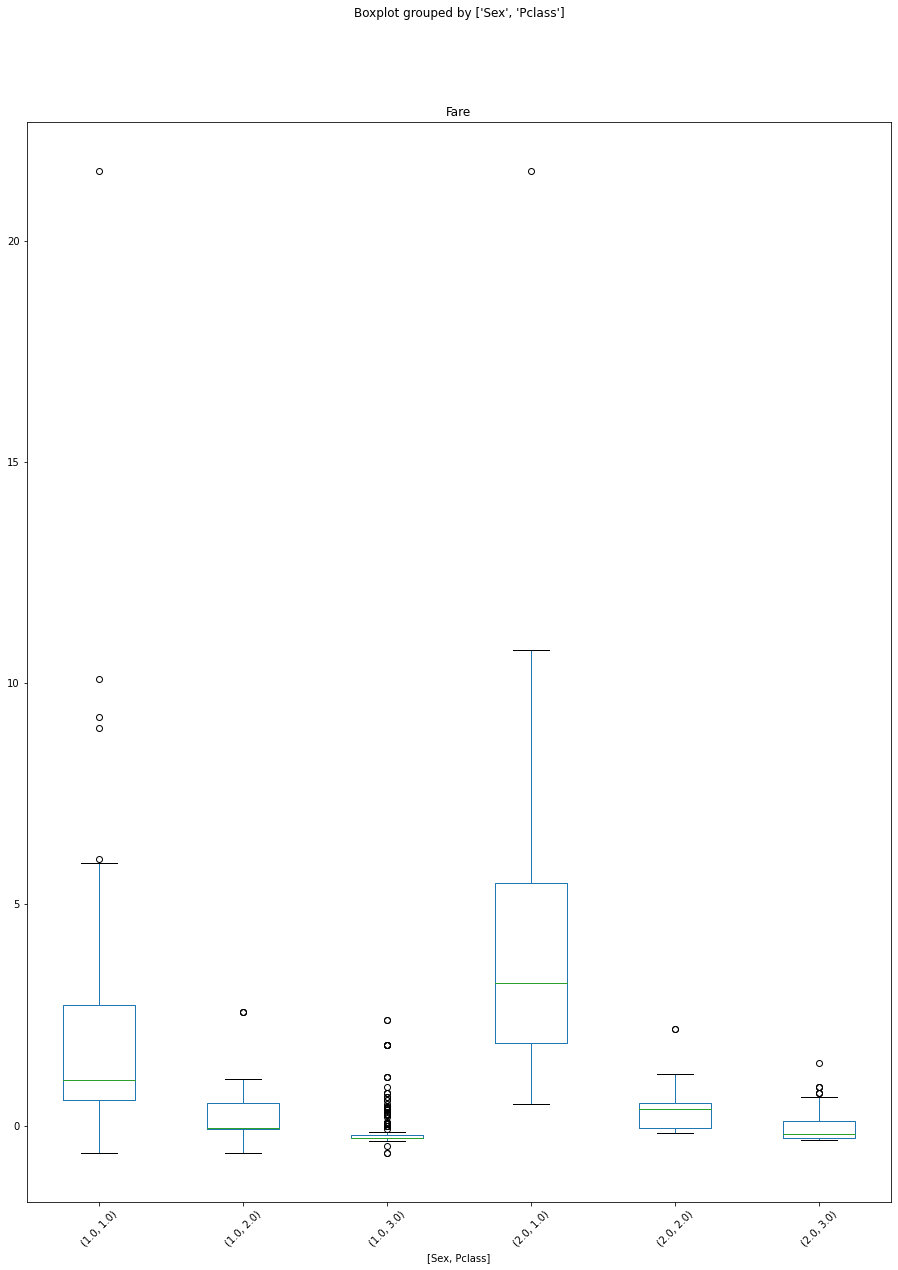

In [2713]:
X_train.boxplot(column='Fare', 
                  by=["Sex", "Pclass"], 
                  figsize= (15,20), 
                  grid=False,
                  rot = 45)
X_train.groupby(["Sex", "Pclass"]).describe()["Fare"]

count      mean       std       min       25%       50%       75%  \
Sex Pclass                                                                      
1.0 1.0      49.0  2.517351  3.671920 -0.626005  0.694936  1.626091  2.804111   
    2.0      44.0  0.233743  0.667956 -0.626005 -0.127945 -0.062981  0.500043   
    3.0     140.0 -0.071327  0.529842 -0.626005 -0.290356 -0.282777 -0.175091   
2.0 1.0      39.0  3.661714  2.836481  0.523864  1.863843  2.788953  3.347646   
    2.0      31.0  0.244587  0.359467 -0.171255 -0.062981  0.283496  0.500043   
    3.0      54.0  0.224169  0.658672 -0.312011 -0.277363  0.050527  0.419921   

                  max  
Sex Pclass             
1.0 1.0     21.562738  
    2.0      2.557247  
    3.0      2.386174  
2.0 1.0     10.764405  
    2.0      1.174771  
    3.0      2.386174

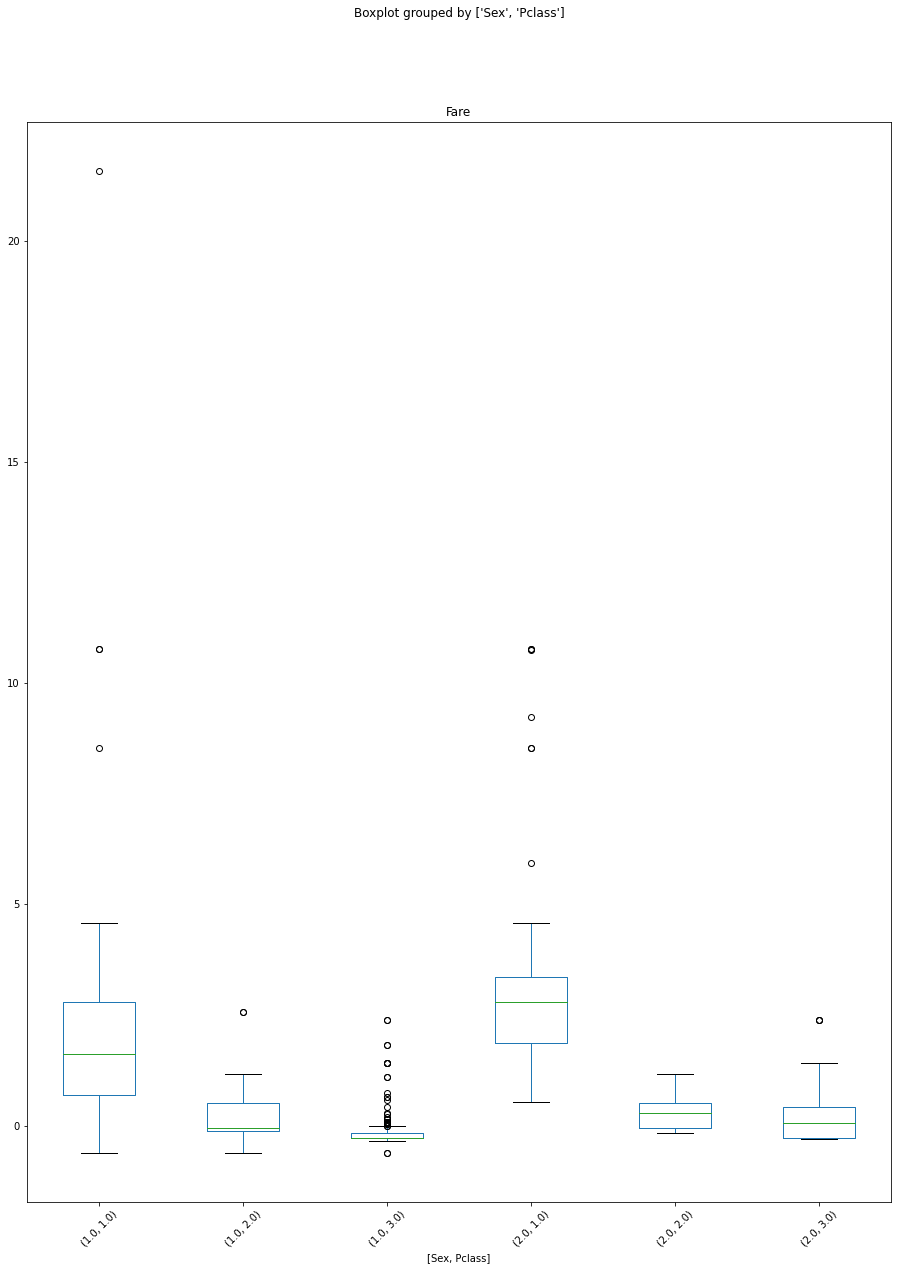

In [2714]:
X_valid.boxplot(column='Fare', 
                  by=["Sex", "Pclass"], 
                  figsize= (15,20), 
                  grid=False,
                  rot = 45)
X_valid.groupby(["Sex", "Pclass"]).describe()["Fare"]

The passenger class  and being  male can lead  to errors. However, the number of female passengers increases as the class lower. Nonetheless, the various distribution of age and fare may lower the accuracy of the validation and testing datasets.

## Classification using test datasets

In [2715]:
y_pred = rf.predict(X_test)
random_forrest_pred = pd.DataFrame({"PassengerId": titanic_test.PassengerId,
                                   "rf_y_pred": y_pred})
random_forrest_pred

,PassengerId,rf_y_pred
0,892.0,0.0
1,893.0,0.0
2,894.0,0.0
3,895.0,0.0
4,896.0,1.0
...,...,...
413,1305.0,0.0
414,1306.0,1.0
415,1307.0,0.0
416,1308.0,0.0


In [2716]:
results_test_copy = results_test.copy(deep=True)

In [2717]:
random_forrest_pred[["PassengerId","rf_y_pred"]]

,PassengerId,rf_y_pred
0,892.0,0.0
1,893.0,0.0
2,894.0,0.0
3,895.0,0.0
4,896.0,1.0
...,...,...
413,1305.0,0.0
414,1306.0,1.0
415,1307.0,0.0
416,1308.0,0.0


In [2718]:
results_test = results_test.merge(random_forrest_pred[["PassengerId","rf_y_pred"]], on = 'PassengerId', how = "outer")
results_test.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,fam_members,lr_y_pred,knn_y_pred,clf_y_pred,rf_y_pred
0,892.0,3.0,1.0,0.431373,-0.281005,3.0,0.0,NaN,NaN,0.0,0.0
1,893.0,3.0,2.0,1.411765,-0.316176,2.0,1.0,NaN,NaN,0.0,0.0
2,894.0,2.0,1.0,2.588235,-0.202184,3.0,0.0,NaN,NaN,0.0,0.0
3,895.0,3.0,1.0,-0.156863,-0.245660,2.0,0.0,NaN,NaN,0.0,0.0
4,896.0,3.0,2.0,-0.549020,-0.091902,2.0,2.0,NaN,NaN,1.0,1.0


# Method: Neural AI 
In this section we use some neural network to classify the data. We prepare the data so that it is more suitable for neural networks. We apply cross validation. 

## Prepare data for Neural-AI

In [2719]:
titanic_train = pd.read_csv(train_data_path)
titanic_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [2720]:
titanic_test = pd.read_csv(test_data_path)
titanic_test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [2721]:
titanic_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [2722]:
titanic_test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

I propose to keep Pclass,Sex, Age, SibSP,Parch,Ticket, Fare,Cabin, Embarked, Survived

In [2723]:
columns_to_keep = ['PassengerId','Pclass', "Name", 'Sex',  'Age',  'SibSp', 'Parch','Ticket', 'Fare','Cabin', 'Embarked', 'Survived']
titanic_train = titanic_train.loc[:,columns_to_keep]
titanic_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [2724]:
columns_to_keep = ['PassengerId','Pclass', "Name", 'Sex',  'Age',  'SibSp', 'Parch','Ticket', 'Fare','Cabin', 'Embarked']
titanic_test = titanic_test.loc[:,columns_to_keep]
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Passengers ID
Transforms to float

In [2725]:

titanic_train["PassengerId"] = titanic_train["PassengerId"].astype(float)
titanic_test["PassengerId"]  = titanic_test["PassengerId"].astype(float)

### Age

Quite a few passengers' age is unknown. We will try to input a value based using the sibling/spouse and parents/children statistical values to infer some replacement values. 

We discover that the median age for parents, single, children, and couples. We rely on age and perception at the time the Titanic sunk. We input the median age for the age that is unknown. We hope to reduce the noise with more meaningful inputations. 

__Conditions applied:__

|Category| Age condition | Sibling/spouse | Parents/children|
|---|---|---|---|
|Parents| >= 14| >= 0 | > 0| 
|Children | < 14 | none | > 0|
|Singles| >= 14| == 0 | == 0|
|Couples| >= 14 | == 1 | == 0|

In [2726]:
titanic_train.Age.isnull().sum()

177

In [2727]:
filter_rows    = (titanic_train["Age"] >= 14.0) & (titanic_train["Parch"] >= 0.0) & (titanic_train["SibSp"] >= 0.0)
median_parents  = titanic_train.loc[filter_rows, "Age"].median()
mean_parents    = titanic_train.loc[filter_rows, "Age"].mean()
print("median age ", median_parents, " mean age ", mean_parents)


median age  30.0  mean age  32.426127527216174


In [2728]:
filter_rows    = (titanic_train["Age"].isnull()) & (titanic_train["Parch"] >= 0.0) & (titanic_train["SibSp"] >= 0.0)
titanic_train.loc[filter_rows, "Age"] = median_parents
titanic_train.loc[filter_rows, "Age"]


5      30.0
17     30.0
19     30.0
26     30.0
28     30.0
       ... 
859    30.0
863    30.0
868    30.0
878    30.0
888    30.0
Name: Age, Length: 177, dtype: float64

In [2729]:
filter_rows    = (titanic_train["Age"] < 14 ) & (titanic_train["Parch"] > 0.0) & ((titanic_train["Name"].str.contains("Master")) | (titanic_train["Name"].str.contains("Miss")))
                                                    
median_children  = titanic_train.loc[filter_rows, "Age"].median()
mean_children   = titanic_train.loc[filter_rows, "Age"].mean()
print("median age ", median_children, " mean age ", mean_children)


median age  4.0  mean age  4.689104477611941


In [2730]:
filter_rows    = (titanic_train["Age"].isnull()) & (titanic_train["Parch"] > 0.0) & ((titanic_train["Name"].str.contains("Master")) | (titanic_train["Name"].str.contains("Miss")))
titanic_train.loc[filter_rows, "Age"] = median_children
titanic_train.loc[filter_rows, "Age"]


Series([], Name: Age, dtype: float64)

In [2731]:
filter_rows    = (titanic_train["Age"] >= 14) & (titanic_train["Parch"] < 1.0) & (titanic_train["SibSp"] < 1.0)
median_single  = titanic_train.loc[filter_rows, "Age"].median()
mean_single    = titanic_train.loc[filter_rows, "Age"].mean()
print("median age ", median_single, " mean age ", mean_single)



median age  30.0  mean age  31.794007490636705


In [2732]:
filter_rows    = (titanic_train["Age"].isnull()) & (titanic_train["Parch"] < 1.0) & (titanic_train["SibSp"] < 1.0)
titanic_train.loc[filter_rows, "Age"] = median_single
titanic_train.loc[filter_rows, "Age"]


Series([], Name: Age, dtype: float64)

In [2733]:
filter_rows    = (titanic_train["Age"] >= 14) & (titanic_train["SibSp"] == 1.0) & (titanic_train["Parch"] == 0.0)

median_couple  = titanic_train.loc[filter_rows, "Age"].median()
mean_couple    = titanic_train.loc[filter_rows, "Age"].mean()
print("median age ", median_couple, " mean age ", mean_couple)


median age  30.0  mean age  31.87704918032787


In [2734]:
filter_rows    = (titanic_train["Age"].isnull()) & (titanic_train["SibSp"] == 1.0) & (titanic_train["Parch"] == 0.0)
titanic_train.loc[filter_rows, "Age"] = median_couple
titanic_train.loc[filter_rows, "Age"]


Series([], Name: Age, dtype: float64)

In [2735]:
titanic_train.Age.isnull().sum()

0

The testing dataset has all ages known.

In [2736]:
titanic_test.Age.isnull().sum()

86

In [2737]:
filter_rows    = (titanic_test["Age"] >= 14.0) & (titanic_test["Parch"] >= 0.0) & (titanic_test["SibSp"] >= 0.0)
median_parents  = titanic_test.loc[filter_rows, "Age"].median()
mean_parents    = titanic_test.loc[filter_rows, "Age"].mean()
print("median age ", median_parents, " mean age ", mean_parents)


median age  29.0  mean age  32.49671052631579


In [2738]:
filter_rows    = (titanic_test["Age"].isnull()) & (titanic_test["Parch"] >= 0.0) & (titanic_test["SibSp"] >= 0.0)
titanic_test.loc[filter_rows, "Age"] = median_parents
titanic_test.loc[filter_rows, "Age"]


10     29.0
22     29.0
29     29.0
33     29.0
36     29.0
       ... 
408    29.0
410    29.0
413    29.0
416    29.0
417    29.0
Name: Age, Length: 86, dtype: float64

In [2739]:
filter_rows    = (titanic_train["Age"] < 14 ) & (titanic_train["Parch"] > 0.0) & ((titanic_train["Name"].str.contains("Master")) | (titanic_train["Name"].str.contains("Miss")))
                                                    
median_children  = titanic_train.loc[filter_rows, "Age"].median()
mean_children   = titanic_train.loc[filter_rows, "Age"].mean()
print("median age ", median_children, " mean age ", mean_children)


median age  4.0  mean age  4.689104477611941


In [2740]:
filter_rows    = (titanic_test["Age"] < 14 ) & (titanic_test["Parch"] > 0.0) & ((titanic_test["Name"].str.contains("Master")) | (titanic_test["Name"].str.contains("Miss")))
                                                    
median_children  = titanic_test.loc[filter_rows, "Age"].median()
mean_children   = titanic_test.loc[filter_rows, "Age"].mean()
print("median age ", median_children, " mean age ", mean_children)


median age  6.0  mean age  5.907407407407407


In [2741]:
filter_rows    = (titanic_test["Age"].isnull()) & (titanic_test["Parch"] > 0.0) & ((titanic_test["Name"].str.contains("Master")) | (titanic_test["Name"].str.contains("Miss")))
titanic_test.loc[filter_rows, "Age"] = median_children
titanic_test.loc[filter_rows, "Age"]


Series([], Name: Age, dtype: float64)

In [2742]:
filter_rows    = (titanic_test["Age"] >= 14) & (titanic_test["Parch"] < 1.0) & (titanic_test["SibSp"] < 1.0)
median_single  = titanic_test.loc[filter_rows, "Age"].median()
mean_single    = titanic_test.loc[filter_rows, "Age"].mean()
print("median age ", median_single, " mean age ", mean_single)



median age  29.0  mean age  29.785714285714285


In [2743]:
filter_rows    = (titanic_test["Age"].isnull()) & (titanic_test["Parch"] < 1.0) & (titanic_test["SibSp"] < 1.0)
titanic_test.loc[filter_rows, "Age"] = median_single
titanic_test.loc[filter_rows, "Age"]


Series([], Name: Age, dtype: float64)

In [2744]:
filter_rows    = (titanic_test["Age"] >= 14) & (titanic_test["SibSp"] == 1.0) & (titanic_test["Parch"] == 0.0)

median_couple  = titanic_test.loc[filter_rows, "Age"].median()
mean_couple    = titanic_test.loc[filter_rows, "Age"].mean()
print("median age ", median_couple, " mean age ", mean_couple)


median age  30.0  mean age  36.075


In [2745]:
filter_rows    = (titanic_test["Age"].isnull()) & (titanic_test["SibSp"] == 1.0) & (titanic_test["Parch"] == 0.0)
titanic_test.loc[filter_rows, "Age"] = median_couple
titanic_test.loc[filter_rows, "Age"]


Series([], Name: Age, dtype: float64)

In [2746]:
titanic_test.Age.isnull().sum()

0

### Embarked 
We transform the port of embarkment as unknown for Nan Values and transform those values into numerical ones. 



In [2747]:
titanic_train.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [2748]:
titanic_test.Embarked.unique()

array(['Q', 'S', 'C'], dtype=object)

In [2749]:
titanic_train.loc[titanic_train["Embarked"].isnull(), "Embarked"] = "U"
titanic_train.Embarked.unique()

array(['S', 'C', 'Q', 'U'], dtype=object)

In [2750]:
titanic_test.loc[titanic_train["Embarked"].isnull(), "Embarked"] = "U"
titanic_test.Embarked.unique()

array(['Q', 'S', 'C'], dtype=object)

In [2751]:
def transform_embarked_cat(data):
    factors = data['Embarked'].unique()
    gender_columns = pd.get_dummies(data['Embarked'])
    columns = range(0,len(factors))
    for column in columns:
        data[factors[column]] = gender_columns.loc[:, factors[column]].astype(float)
        
    return data


In [2752]:

titanic_train = transform_embarked_cat(titanic_train)
titanic_train = titanic_train.drop("Embarked", axis = 1)
titanic_train.dtypes

PassengerId    float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Survived         int64
S              float64
C              float64
Q              float64
U              float64
dtype: object

In [2753]:

titanic_test = transform_embarked_cat(titanic_test)
titanic_test = titanic_test.drop("Embarked", axis = 1)
titanic_test.dtypes

PassengerId    float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Q              float64
S              float64
C              float64
dtype: object

In [2754]:
indices       = range(0, titanic_test.shape[0])
titanic_test['U'] = [0 for i in indices]
titanic_test['U'] = titanic_test['U'].astype(float)

### Number of sibling

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64


(array([608., 209.,  28.,  16.,   0.,  18.,   5.,   0.,   0.,   7.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

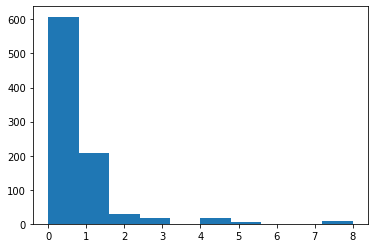

In [2755]:
print(titanic_train["SibSp"].describe())
plt.hist(titanic_train["SibSp"])

count    418.000000
mean       0.447368
std        0.896760
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64


(array([283., 110.,  14.,   4.,   0.,   4.,   1.,   0.,   0.,   2.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

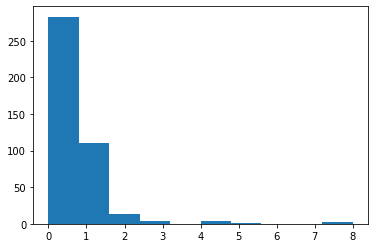

In [2756]:
print(titanic_test["SibSp"].describe())
plt.hist(titanic_test["SibSp"])

In [2757]:
def categorise_siblings(data):
    cut_labels_9 = ['sib_0','sib_1','sib_2','sib_3', 
                    'sib_4','sib_5','sib_6','sib_7', 'sib_8']
    cut_bins = [0,1,2,3,4,5,6,7,8,9]
    data['Sib_cat'] = pd.cut(data['SibSp'], 
                             bins=cut_bins, 
                             labels=cut_labels_9)
    
    data['Sib_cat'] = data.Sib_cat.astype(str)
    data.loc[data["Sib_cat"] == 'nan', "Sib_cat"] = "Sib_Unknown"
    
    return data

def transform_sibling_cat(data):
    factors = data['Sib_cat'].unique()
    gender_columns = pd.get_dummies(data['Sib_cat'])
    columns = range(0,len(factors))
    for column in columns:
        data[factors[column]] = gender_columns.loc[:, factors[column]].astype(float)
        
    return data

In [2758]:
titanic_train = categorise_siblings(titanic_train)
titanic_train = transform_sibling_cat(titanic_train)
titanic_train = titanic_train.drop("SibSp", axis = 1)
titanic_train = titanic_train.drop("Sib_cat", axis = 1)
titanic_train.dtypes

PassengerId    float64
Pclass           int64
Name            object
Sex             object
Age            float64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Survived         int64
S              float64
C              float64
Q              float64
U              float64
sib_0          float64
Sib_Unknown    float64
sib_2          float64
sib_3          float64
sib_1          float64
sib_4          float64
sib_7          float64
dtype: object

In [2759]:
titanic_train.shape

(891, 21)

In [2760]:
titanic_test = categorise_siblings(titanic_test)
titanic_test = transform_sibling_cat(titanic_test)
titanic_test = titanic_test.drop("SibSp", axis = 1)
titanic_test = titanic_test.drop("Sib_cat", axis = 1)
titanic_test.dtypes

PassengerId    float64
Pclass           int64
Name            object
Sex             object
Age            float64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Q              float64
S              float64
C              float64
U              float64
Sib_Unknown    float64
sib_0          float64
sib_1          float64
sib_2          float64
sib_3          float64
sib_4          float64
sib_7          float64
dtype: object

In [2761]:
titanic_test.shape

(418, 20)

### Transforming age into categories
The categorise the age into 9 categories; unknown and one for each decade. The categories are then transformed in hot_coding format. 

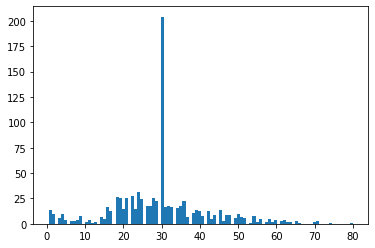

In [2762]:
plt.hist(titanic_train['Age'], bins=100)
plt.show()

In [2763]:
titanic_train['Age'].describe()

count    891.000000
mean      29.758889
std       13.002570
min        0.420000
25%       22.000000
50%       30.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

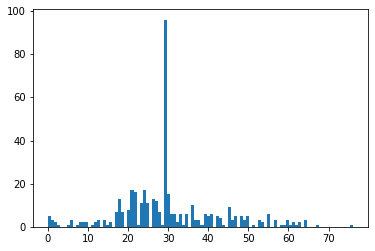

In [2764]:
plt.hist(titanic_test['Age'], bins=100)
plt.show()

In [2765]:
titanic_test['Age'].describe()

count    418.000000
mean      30.010766
std       12.645028
min        0.170000
25%       23.000000
50%       29.000000
75%       35.750000
max       76.000000
Name: Age, dtype: float64

In [2766]:
def transform_age_cat(data):
    factors = data['Age_cat'].unique()
    gender_columns = pd.get_dummies(data['Age_cat'])
    columns = range(0,len(factors))
    for column in columns:
        data[factors[column]] = gender_columns.loc[:, factors[column]].astype(float)
        
    return data


In [2767]:
def categorise_age(data):
    cut_labels_8 = ['age_0-9','age_10-19','age_20-29','age_30-39', 
                    'age_40-49','age_50-59','age_60-69','age_70-79']
    cut_bins = [0,10,20,30,40,50,60,70,80]
    data['Age_cat'] = pd.cut(data['Age'], 
                             bins=cut_bins, 
                             labels=cut_labels_8)
    data['Age_cat'] = data.Age_cat.astype(str)
    data.loc[data["Age"].isna(), "Age_cat"] = "Age_Unknown"
    return data

In [2768]:
titanic_train = categorise_age(titanic_train)
titanic_train = transform_age_cat(titanic_train)
titanic_train = titanic_train.drop("Age", axis = 1)
titanic_train = titanic_train.drop("Age_cat", axis = 1)
titanic_train.dtypes

PassengerId    float64
Pclass           int64
Name            object
Sex             object
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Survived         int64
S              float64
C              float64
Q              float64
U              float64
sib_0          float64
Sib_Unknown    float64
sib_2          float64
sib_3          float64
sib_1          float64
sib_4          float64
sib_7          float64
age_20-29      float64
age_30-39      float64
age_50-59      float64
age_0-9        float64
age_10-19      float64
age_60-69      float64
age_40-49      float64
age_70-79      float64
dtype: object

In [2769]:
titanic_test = categorise_age(titanic_test)
titanic_test = transform_age_cat(titanic_test)
titanic_test = titanic_test.drop("Age", axis = 1)
titanic_test = titanic_test.drop("Age_cat", axis = 1)
titanic_test.dtypes

PassengerId    float64
Pclass           int64
Name            object
Sex             object
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Q              float64
S              float64
C              float64
U              float64
Sib_Unknown    float64
sib_0          float64
sib_1          float64
sib_2          float64
sib_3          float64
sib_4          float64
sib_7          float64
age_30-39      float64
age_40-49      float64
age_60-69      float64
age_20-29      float64
age_10-19      float64
age_50-59      float64
age_0-9        float64
age_70-79      float64
dtype: object

### Gender transformation to hot-coding 
We check the factor values are the same between both datasets. Then, we generate a hot coding of two columns; i.e., male and female. Both columns replace the Sex column.

In [2770]:
titanic_train['Sex'].unique()

array(['male', 'female'], dtype=object)

In [2771]:
titanic_test['Sex'].unique()

array(['male', 'female'], dtype=object)

In [2772]:
def transform_gender(data):
    factors = data['Sex'].unique()
    gender_columns = pd.get_dummies(data['Sex'])
    columns = range(0,len(factors))
    
    for column in columns:
        data[factors[column]] = gender_columns.loc[:,factors[column]].astype(float)
        
    return data
    

In [2773]:
titanic_train = transform_gender(titanic_train)
titanic_train.drop("Sex", axis = 1, inplace = True)
titanic_train.dtypes

PassengerId    float64
Pclass           int64
Name            object
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Survived         int64
S              float64
C              float64
Q              float64
U              float64
sib_0          float64
Sib_Unknown    float64
sib_2          float64
sib_3          float64
sib_1          float64
sib_4          float64
sib_7          float64
age_20-29      float64
age_30-39      float64
age_50-59      float64
age_0-9        float64
age_10-19      float64
age_60-69      float64
age_40-49      float64
age_70-79      float64
male           float64
female         float64
dtype: object

In [2774]:
titanic_test = transform_gender(titanic_test)
titanic_test.drop("Sex", axis = 1,inplace = True)
titanic_test.head()

,PassengerId,Pclass,Name,Parch,Ticket,Fare,Cabin,Q,S,C,...,age_30-39,age_40-49,age_60-69,age_20-29,age_10-19,age_50-59,age_0-9,age_70-79,male,female
0,892.0,3,"Kelly, Mr. James",0,330911,7.8292,NaN,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,893.0,3,"Wilkes, Mrs. James (Ellen Needs)",0,363272,7.0000,NaN,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,894.0,2,"Myles, Mr. Thomas Francis",0,240276,9.6875,NaN,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,895.0,3,"Wirz, Mr. Albert",0,315154,8.6625,NaN,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,896.0,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,3101298,12.2875,NaN,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Cabin and Pclass

The passenger class appears to drive whether a cabin is known. So, we propose to drop the cabin as the percentage of not known values is quite high. We apply an hot encoding the Pclass. 

In [2775]:
titanic_train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [2776]:
print("percentage of cabin  nan values - training ", titanic_train['Cabin'].isna().sum()/titanic_train.shape[0])
print("percentage of cabin  nan values - test ", titanic_test['Cabin'].isna().sum()/titanic_test.shape[0])

percentage of cabin  nan values - training  0.7710437710437711
percentage of cabin  nan values - test  0.7822966507177034


In [2777]:
titanic_train['Pclass'].unique()

array([3, 1, 2])

In [2778]:
titanic_test['Pclass'].unique()

array([3, 2, 1])

In [2779]:
titanic_train.loc[titanic_train['Pclass'] == 1 ,['Pclass','Cabin']]

,Pclass,Cabin
1,1,C85
3,1,C123
6,1,E46
11,1,C103
23,1,A6
...,...,...
871,1,D35
872,1,B51 B53 B55
879,1,C50
887,1,B42


In [2780]:
titanic_train.loc[titanic_train['Pclass'] == 2 ,['Pclass','Cabin']]

,Pclass,Cabin
9,2,NaN
15,2,NaN
17,2,NaN
20,2,NaN
21,2,D56
...,...,...
866,2,NaN
874,2,NaN
880,2,NaN
883,2,NaN


In [2781]:
titanic_train.loc[titanic_train['Pclass'] == 3 ,['Pclass','Cabin']]

,Pclass,Cabin
0,3,NaN
2,3,NaN
4,3,NaN
5,3,NaN
7,3,NaN
...,...,...
882,3,NaN
884,3,NaN
885,3,NaN
888,3,NaN


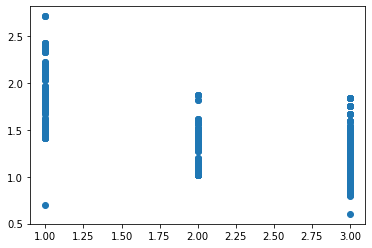

In [2782]:
xs = titanic_train.loc[titanic_train['Fare'] > 0,'Pclass']
ys = np.log10(titanic_train.loc[titanic_train['Fare'] > 0,'Fare'])
plt.scatter(xs,ys)

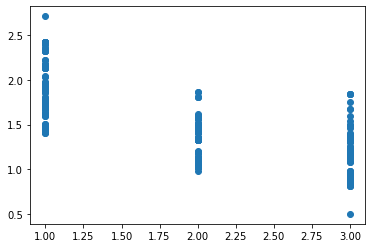

In [2783]:
xs = titanic_test.loc[titanic_test['Fare'] > 0,'Pclass']
ys = np.log10(titanic_test.loc[titanic_test['Fare'] > 0,'Fare'])
plt.scatter(xs,ys)

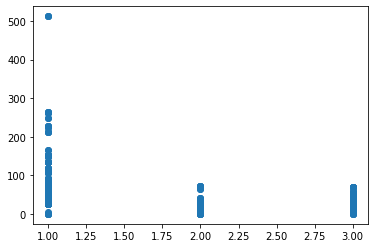

In [2784]:
plt.scatter(titanic_train["Pclass"],titanic_train["Fare"])

In [2785]:
def transform_Pclass(data):
    factors = data['Pclass'].unique()
    Pclass_columns = pd.get_dummies(data['Pclass'])
    columns = range(0,len(factors))
    
    for column in columns:
        col_name = 'Class_' + str(factors[column])
        data[col_name] = Pclass_columns.loc[:,factors[column]].astype(float)
        
    data.drop("Pclass", axis = 1)
    return data
    

In [2786]:
titanic_train = transform_Pclass(titanic_train)
titanic_train.drop("Pclass", axis = 1, inplace = True)
titanic_train.drop("Cabin", axis = 1, inplace = True)
titanic_train.head()

,PassengerId,Name,Parch,Ticket,Fare,Survived,S,C,Q,U,...,age_0-9,age_10-19,age_60-69,age_40-49,age_70-79,male,female,Class_3,Class_1,Class_2
0,1.0,"Braund, Mr. Owen Harris",0,A/5 21171,7.2500,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,2.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,PC 17599,71.2833,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,3.0,"Heikkinen, Miss. Laina",0,STON/O2. 3101282,7.9250,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,4.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,113803,53.1000,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,5.0,"Allen, Mr. William Henry",0,373450,8.0500,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [2787]:
titanic_test = transform_Pclass(titanic_test)
titanic_test.drop("Pclass", axis = 1, inplace = True)
titanic_test.drop("Cabin", axis = 1, inplace = True)
titanic_test.head()

,PassengerId,Name,Parch,Ticket,Fare,Q,S,C,U,Sib_Unknown,...,age_20-29,age_10-19,age_50-59,age_0-9,age_70-79,male,female,Class_3,Class_2,Class_1
0,892.0,"Kelly, Mr. James",0,330911,7.8292,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,893.0,"Wilkes, Mrs. James (Ellen Needs)",0,363272,7.0000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,894.0,"Myles, Mr. Thomas Francis",0,240276,9.6875,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,895.0,"Wirz, Mr. Albert",0,315154,8.6625,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,896.0,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,3101298,12.2875,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


### Tickets and Fare
We remove the tickets, as it brings no additional characteristic for the prediction.

Old version: We reduce the complexity of the Fare by using the log.
New version: The price appears to be dependent on the class, so we drop the price.

In [2788]:
titanic_train.drop("Ticket", axis = 1, inplace = True)
titanic_test.drop("Ticket", axis = 1, inplace = True)

In [2789]:
log_10_values = np.log10(titanic_train.loc[titanic_train['Fare'] > 0,'Fare'])
titanic_train.loc[titanic_train['Fare'] > 0,'Fare'] = log_10_values
titanic_train.Fare.describe()


count    891.000000
mean       1.256781
std        0.435553
min        0.000000
25%        0.898198
50%        1.159994
75%        1.491362
max        2.709549
Name: Fare, dtype: float64

In [2790]:
log_10_values = np.log10(titanic_test.loc[titanic_test['Fare'] > 0,'Fare'])
titanic_test.loc[titanic_test['Fare'] > 0,'Fare'] = log_10_values
titanic_test.Fare.describe()

count    417.000000
mean       1.279591
std        0.437507
min        0.000000
25%        0.897396
50%        1.159994
75%        1.498311
max        2.709549
Name: Fare, dtype: float64

In [2791]:
titanic_train.drop("Fare", axis = 1, inplace = True)
titanic_test.drop("Fare", axis = 1, inplace = True)

### Outcome of data preparations

In [2792]:

print("training datasets : " , titanic_train.shape)
titanic_train.dtypes

training datasets :  (891, 28)


PassengerId    float64
Name            object
Parch            int64
Survived         int64
S              float64
C              float64
Q              float64
U              float64
sib_0          float64
Sib_Unknown    float64
sib_2          float64
sib_3          float64
sib_1          float64
sib_4          float64
sib_7          float64
age_20-29      float64
age_30-39      float64
age_50-59      float64
age_0-9        float64
age_10-19      float64
age_60-69      float64
age_40-49      float64
age_70-79      float64
male           float64
female         float64
Class_3        float64
Class_1        float64
Class_2        float64
dtype: object

In [2793]:
print("testing datasets : " , titanic_test.shape)
titanic_test.dtypes

testing datasets :  (418, 27)


PassengerId    float64
Name            object
Parch            int64
Q              float64
S              float64
C              float64
U              float64
Sib_Unknown    float64
sib_0          float64
sib_1          float64
sib_2          float64
sib_3          float64
sib_4          float64
sib_7          float64
age_30-39      float64
age_40-49      float64
age_60-69      float64
age_20-29      float64
age_10-19      float64
age_50-59      float64
age_0-9        float64
age_70-79      float64
male           float64
female         float64
Class_3        float64
Class_2        float64
Class_1        float64
dtype: object

In [2794]:
train_cols = titanic_train.columns
test_cols = titanic_test.columns

common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)
train_not_test

Index(['Survived'], dtype='object')

In [2795]:
titanic_test.columns

Index(['PassengerId', 'Name', 'Parch', 'Q', 'S', 'C', 'U', 'Sib_Unknown',
       'sib_0', 'sib_1', 'sib_2', 'sib_3', 'sib_4', 'sib_7', 'age_30-39',
       'age_40-49', 'age_60-69', 'age_20-29', 'age_10-19', 'age_50-59',
       'age_0-9', 'age_70-79', 'male', 'female', 'Class_3', 'Class_2',
       'Class_1'],
      dtype='object')

## Cross validation preparation
We use a stratified sampling for the training into a train and test dataset. 

In [2796]:
x_cols = ["PassengerId",'Parch', 'Sib_Unknown', 'sib_0', 'sib_1', 'sib_2', 'sib_3', 'sib_4', 'sib_7', 
          'age_30-39', 'age_40-49', 'age_60-69', 'age_20-29', 'age_10-19', 'age_50-59',
       'age_0-9', 'age_70-79', 'male', 'female', 'Class_3', 'Class_2',
       'Class_1', 'Q', 'S', 'C', 'U']
y_col = 'Survived'
X = titanic_train.copy(deep = True)
X = X[x_cols]
X = X.apply(pd.to_numeric)
y = titanic_train[y_col].apply(pd.to_numeric)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid  = X.iloc[test_valid_index]
    y_valid  = y.iloc[test_valid_index]

# we see our training set follows the same distribution
print(y_train.value_counts(normalize=True), '\n\n')

# we see our test set follows the same distribution
print(y_valid.value_counts(normalize=True))

0    0.616105
1    0.383895
Name: Survived, dtype: float64 


0    0.616246
1    0.383754
Name: Survived, dtype: float64


In [2797]:
x_cols = ['Parch', 'Sib_Unknown', 'sib_0', 'sib_1', 'sib_2', 'sib_3', 'sib_4', 'sib_7', 
          'age_30-39', 'age_40-49', 'age_60-69', 'age_20-29', 'age_10-19', 'age_50-59',
       'age_0-9', 'age_70-79', 'male', 'female', 'Class_3', 'Class_2',
       'Class_1', 'Q', 'S', 'C', 'U']
x_train_pass_id = X_train.PassengerId
X_train = X_train[x_cols]
X_train.shape

(534, 25)

In [2798]:
x_valid_pass_id = X_valid.PassengerId
X_valid = X_valid[x_cols]

X_valid.shape

(357, 25)

In [2799]:
y_train_encode=pd.get_dummies(y_train)
y_valid_encode=pd.get_dummies(y_valid)


In [2800]:
train_cols = X_train.columns
test_cols = titanic_test.columns

common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)
train_not_test

Index([], dtype='object')

In [2801]:
X_test = titanic_test[x_cols]
X_test.dtypes

Parch            int64
Sib_Unknown    float64
sib_0          float64
sib_1          float64
sib_2          float64
sib_3          float64
sib_4          float64
sib_7          float64
age_30-39      float64
age_40-49      float64
age_60-69      float64
age_20-29      float64
age_10-19      float64
age_50-59      float64
age_0-9        float64
age_70-79      float64
male           float64
female         float64
Class_3        float64
Class_2        float64
Class_1        float64
Q              float64
S              float64
C              float64
U              float64
dtype: object

## ANN

We apply an ANN to predict the survival of passengers.  We create a basic architecture made of 5 layers.

In [2802]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

tf.compat.v1.get_default_graph()

no_columns = X_train.shape[1]
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(no_columns,)))
model.add(tf.keras.layers.Dense(32, activation="sigmoid"))
model.add(tf.keras.layers.Dense(32, activation="sigmoid"))
model.add(tf.keras.layers.Dense(32, activation="sigmoid"))
model.add(tf.keras.layers.Dense(2, activation="softmax"))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 25)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                832       
_________________________________________________________________
dense_25 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_26 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 66        
Total params: 3,010
Trainable params: 3,010
Non-trainable params: 0
_________________________________________________________________


In [2803]:

rate = 0.00021
opt = tf.keras.optimizers.Adam(learning_rate = rate)
model.compile(optimizer= opt, 
                  loss = "binary_crossentropy",
                  metrics=["accuracy"])
tf.compat.v1.get_default_graph()
history = model.fit(X_train,
                        y_train_encode,
                        validation_data=(X_valid, y_valid_encode),
                        epochs = 300,
                        verbose = True)


Epoch 1/300
17/17 [==============================] - 1s 22ms/step - loss: 0.7113 - accuracy: 0.3839 - val_loss: 0.7029 - val_accuracy: 0.3838
Epoch 2/300
17/17 [==============================] - 0s 5ms/step - loss: 0.6970 - accuracy: 0.4120 - val_loss: 0.6904 - val_accuracy: 0.6162
Epoch 3/300
17/17 [==============================] - 0s 5ms/step - loss: 0.6866 - accuracy: 0.6161 - val_loss: 0.6815 - val_accuracy: 0.6162
Epoch 4/300
17/17 [==============================] - 0s 5ms/step - loss: 0.6786 - accuracy: 0.6161 - val_loss: 0.6759 - val_accuracy: 0.6162
Epoch 5/300
17/17 [==============================] - 0s 5ms/step - loss: 0.6738 - accuracy: 0.6161 - val_loss: 0.6718 - val_accuracy: 0.6162
Epoch 6/300
17/17 [==============================] - 0s 5ms/step - loss: 0.6706 - accuracy: 0.6161 - val_loss: 0.6691 - val_accuracy: 0.6162
Epoch 7/300
17/17 [==============================] - 0s 5ms/step - loss: 0.6683 - accuracy: 0.6161 - val_loss: 0.6676 - val_accuracy: 0.6162
Epoch 8/300


In [2804]:
_, ann_train_accuracy = model.evaluate(X_train, y_train_encode)
print('Accuracy: %.4f' % (ann_train_accuracy))

17/17 [==============================] - 0s 2ms/step - loss: 0.4283 - accuracy: 0.8221
Accuracy: 0.8221


In [2805]:
_, ann_valid_accuracy = model.evaluate(X_valid, y_valid_encode)
print('Accuracy: %.4f' % (ann_valid_accuracy))

12/12 [==============================] - 0s 2ms/step - loss: 0.4266 - accuracy: 0.8123
Accuracy: 0.8123


### Which passengers were misclassified 

In [2826]:

y_pred = model.predict(X_train)
Y_pred = np.argmax(model.predict(X_train),axis=1)
cm = confusion_matrix(y_train, Y_pred)
cm

array([[303,  26],
       [ 69, 136]])

In [2827]:
accuracy          = (cm[0][0] + cm[1][1])/len(y_pred)
misclassification = (cm[0][1] + cm[1][0])/len(y_pred)
sensitivity       = (cm[0][0])/(cm[0][0] + cm[0][1])
specificity       = (cm[1][1])/(cm[1][0] + cm[1][1])
print("Accuracy         : ", accuracy)
print("Misclassfication : ", misclassification)
print("Sensitivivity    : ", sensitivity)
print("Specificity      : ", specificity)


Accuracy         :  0.8220973782771536
Misclassfication :  0.17790262172284643
Sensitivivity    :  0.9209726443768997
Specificity      :  0.6634146341463415


In [2828]:

y_pred = model.predict(X_valid)
Y_pred = np.argmax(model.predict(X_valid),axis=1)
cm = confusion_matrix(y_valid, Y_pred)
cm

array([[205,  15],
       [ 52,  85]])

In [2829]:
accuracy          = (cm[0][0] + cm[1][1])/len(y_pred)
misclassification = (cm[0][1] + cm[1][0])/len(y_pred)
sensitivity       = (cm[0][0])/(cm[0][0] + cm[0][1])
specificity       = (cm[1][1])/(cm[1][0] + cm[1][1])
print("Accuracy         : ", accuracy)
print("Misclassfication : ", misclassification)
print("Sensitivivity    : ", sensitivity)
print("Specificity      : ", specificity)


Accuracy         :  0.8123249299719888
Misclassfication :  0.1876750700280112
Sensitivivity    :  0.9318181818181818
Specificity      :  0.6204379562043796


#### Capture classification for analysis

In [2830]:
results_train_copy = results_train.copy(deep=True)

In [2831]:

y_pred = np.argmax(model.predict(X_train),axis=1)

ann_pred                 = X_train.copy()
ann_pred["ann_y_pred"]   = y_pred
ann_pred["PassengerId"]  = x_train_pass_id
ann_pred.head()

,Parch,Sib_Unknown,sib_0,sib_1,sib_2,sib_3,sib_4,sib_7,age_30-39,age_40-49,...,female,Class_3,Class_2,Class_1,Q,S,C,U,ann_y_pred,PassengerId
844,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,845.0
316,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,317.0
768,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,769.0
255,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,256.0
130,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,131.0


In [2832]:
results_train = results_train.merge(ann_pred[["PassengerId", "ann_y_pred"]], 
                                     on = "PassengerId", how="outer")

results_train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,fam_members,y,lr_y_pred,knn_y_pred,clf_y_pred_x,rf_y_pred,clf_y_pred_y,clf_y_pred,ann_y_pred_x,ann_y_pred_y
0,1.0,0.0,3.0,1.0,-0.615385,-0.312011,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
1,2.0,1.0,1.0,2.0,0.615385,2.461242,4.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN
2,3.0,1.0,3.0,2.0,-0.307692,-0.282777,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0
3,4.0,1.0,1.0,2.0,0.384615,1.673732,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN
4,5.0,0.0,3.0,1.0,0.384615,-0.277363,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN


In [2813]:

y_pred = np.argmax(model.predict(X_valid),axis=1)
ann_pred = X_valid.copy()
ann_pred["ann_y_pred"] = y_pred
ann_pred["PassengerId"] = x_valid_pass_id
ann_pred.head()

,Parch,Sib_Unknown,sib_0,sib_1,sib_2,sib_3,sib_4,sib_7,age_30-39,age_40-49,...,female,Class_3,Class_2,Class_1,Q,S,C,U,ann_y_pred,PassengerId
369,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,370.0
541,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,542.0
196,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,197.0
810,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,811.0
427,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,428.0


In [2814]:

results_train.loc[results_train.PassengerId.isin(ann_pred.PassengerId), "ann_y_pred"] = ann_pred["ann_y_pred"]
results_train.head()


,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,fam_members,y,lr_y_pred,knn_y_pred,clf_y_pred_x,rf_y_pred,clf_y_pred_y,clf_y_pred,ann_y_pred
0,1.0,0.0,3.0,1.0,-0.615385,-0.312011,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
1,2.0,1.0,1.0,2.0,0.615385,2.461242,4.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0
2,3.0,1.0,3.0,2.0,-0.307692,-0.282777,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,0.0
3,4.0,1.0,1.0,2.0,0.384615,1.673732,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0
4,5.0,0.0,3.0,1.0,0.384615,-0.277363,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0


Overall, the number of survivors misclassified were greater than misclassified passengers who perished. The next step is to identify those passengers to attempt to find the source of the misclassifcation. So far the lowest number  of misclassified passengers who  perished. 

## Predict test dataset

In [2815]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(1)
ann_pred    = pd.DataFrame({"PassengerId": titanic_test["PassengerId"],
                       "ann_y_pred" : y_pred})
ann_pred

,PassengerId,ann_y_pred
0,892.0,0
1,893.0,0
2,894.0,0
3,895.0,0
4,896.0,0
...,...,...
413,1305.0,0
414,1306.0,1
415,1307.0,0
416,1308.0,0


In [2816]:
results_test_copy = results_test.copy(deep=True)

In [2817]:
ann_pred[["PassengerId","ann_y_pred"]]

,PassengerId,ann_y_pred
0,892.0,0
1,893.0,0
2,894.0,0
3,895.0,0
4,896.0,0
...,...,...
413,1305.0,0
414,1306.0,1
415,1307.0,0
416,1308.0,0


In [2818]:
results_test = results_test.merge(ann_pred[["PassengerId","ann_y_pred"]], on = 'PassengerId', how = "outer")
results_test.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,fam_members,lr_y_pred,knn_y_pred,clf_y_pred,rf_y_pred,ann_y_pred
0,892.0,3.0,1.0,0.431373,-0.281005,3.0,0.0,NaN,NaN,0.0,0.0,0.0
1,893.0,3.0,2.0,1.411765,-0.316176,2.0,1.0,NaN,NaN,0.0,0.0,0.0
2,894.0,2.0,1.0,2.588235,-0.202184,3.0,0.0,NaN,NaN,0.0,0.0,0.0
3,895.0,3.0,1.0,-0.156863,-0.245660,2.0,0.0,NaN,NaN,0.0,0.0,0.0
4,896.0,3.0,2.0,-0.549020,-0.091902,2.0,2.0,NaN,NaN,1.0,1.0,0.0


# Findings

We compile all the results in a basic structure. We discover that the logistic regression has achieved the highest accuracy on the validation datasets. ANN came close. Both methods appears not to overfit to the training dataset.

In [2819]:
log_reg_results = {
    "method": "Logistic regression",
    "training_accurary": log_reg_score_train,
    "valid_accuracy": log_reg_score_valid
}

knn_results = {
    "method": "KNN",
    "training_accurary": knn_train_score,
    "valid_accuracy": knn_valid_score
}

clf_results = {
    "method": "decision trees",
    "training_accurary": clf_train_score,
    "valid_accuracy": clf_valid_score
}

rf_results = {
    "method": "Random Forrest",
    "training_accurary": rf_train_score,
    "valid_accuracy": rf_valid_score
}

ann_results = {
    "method": "ANN",
    "training_accurary": ann_train_accuracy,
    "valid_accuracy": ann_valid_accuracy
}

results = [log_reg_results, knn_results, clf_results, rf_results, ann_results]
results

[{'method': 'Logistic regression',
  'training_accurary': 0.7921348314606742,
  'valid_accuracy': 0.8207282913165266},
 {'method': 'KNN',
  'training_accurary': 0.8258426966292135,
  'valid_accuracy': 0.7871148459383753},
 {'method': 'decision trees',
  'training_accurary': 0.9063670411985019,
  'valid_accuracy': 0.8011204481792717},
 {'method': 'Random Forrest',
  'training_accurary': 0.8801498127340824,
  'valid_accuracy': 0.8067226890756303},
 {'method': 'ANN',
  'training_accurary': 0.8220973610877991,
  'valid_accuracy': 0.8123249411582947}]

We analyse differences between each method on the testing data set. 

In [2820]:
results_test.dtypes



PassengerId    float64
Pclass         float64
Sex            float64
Age            float64
Fare           float64
Embarked       float64
fam_members    float64
lr_y_pred      float64
knn_y_pred     float64
clf_y_pred     float64
rf_y_pred      float64
ann_y_pred     float64
dtype: object

In [2821]:
filter_columns = ["PassengerId", "lr_y_pred","knn_y_pred","clf_y_pred","rf_y_pred", "ann_y_pred"] 
results_test[filter_columns]

,PassengerId,lr_y_pred,knn_y_pred,clf_y_pred,rf_y_pred,ann_y_pred
0,892.0,NaN,NaN,0.0,0.0,0.0
1,893.0,NaN,NaN,0.0,0.0,0.0
2,894.0,NaN,NaN,0.0,0.0,0.0
3,895.0,NaN,NaN,0.0,0.0,0.0
4,896.0,NaN,NaN,1.0,1.0,0.0
...,...,...,...,...,...,...
770,175.0,0.0,0.0,NaN,NaN,NaN
771,298.0,1.0,0.0,NaN,NaN,NaN
772,245.0,0.0,0.0,NaN,NaN,NaN
773,39.0,0.0,1.0,NaN,NaN,NaN


count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: sum_pred, dtype: float64

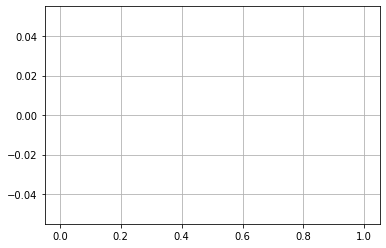

In [2822]:
results_test["sum_pred"] = results_test["lr_y_pred"] + results_test["ann_y_pred"] + results_test["knn_y_pred"] + results_test["rf_y_pred"] + results_test["clf_y_pred"] 

results_test.sum_pred.hist(bins = 5)
results_test.sum_pred.describe()


In [2823]:

print(results_test.sum_pred.value_counts(normalize=True), '\n\n')

Series([], Name: sum_pred, dtype: float64) 




In [2824]:
filter_columns = ["PassengerId", "Pclass", "Sex", "Age", "Fare", "Embarked", "fam_members"] 



# Submission

In [2825]:
submission = pd.DataFrame({
        "PassengerId": X_test["PassengerId"],
        "Survived": Y_pred
    })
# submission.to_csv('../output/submission.csv', index=False)


KeyError: 'PassengerId'